In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

c:\users\mallyaa\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 110233768237333145
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1486906982
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18342276609803811959
physical_device_desc: "device: 0, name: Quadro M600M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
#Import necessary libraries
import numpy as np
np.random.seed(123)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.datasets import mnist
from keras import regularizers
import matplotlib.pyplot as plt
from keras.preprocessing import image

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import cv2
import glob
import time
from collections import deque
from PIL import Image

%matplotlib inline

In [5]:
def load_data():
 # Loading + training,validation test split
    cars0 = glob.glob('Car_dataset/vehicles/GTI_Far/*.png')
    cars0 += glob.glob('Car_dataset/vehicles/GTI_Far/*.jpg')
    cars1 = glob.glob('Car_dataset/vehicles/GTI_MiddleClose/*.png')
    cars2 = glob.glob('Car_dataset/vehicles/GTI_Left/*.png')
    cars3 = glob.glob('Car_dataset/vehicles/GTI_Right/*.png')
    cars4 = glob.glob('Car_dataset/vehicles/KITTI_extracted/*.png')
    
    notcars1 = glob.glob('Car_dataset/non-vehicles/Extras/*.png')
    notcars1 += glob.glob('Car_dataset/non-vehicles/Extras/*.jpg')
    notcars1 += glob.glob('Car_dataset/non-vehicles/GTI/*.png')
    notcars1 += glob.glob('Car_dataset/non-vehicles/Left/*.png')
    notcars1 += glob.glob('Car_dataset/non-vehicles/Right/*.png')
    notcars1 += glob.glob('Car_dataset/non-vehicles/MiddleClose/*.png')
    notcars1 += glob.glob('Car_dataset/non-vehicles/Far/*.png')
    
    # split 70% training 20% validation 10% test set
    frac1 = 0.7
    l0,l1,l2,l3,l4,l5=len(cars0),len(cars1),len(cars2),len(cars3),len(cars4),len(notcars1)
    L1 = (frac1*np.array([l0,l1,l2,l3,l4,l5])).astype('int')
    frac2 = 0.9
    l0,l1,l2,l3,l4,l5=len(cars0),len(cars1),len(cars2),len(cars3),len(cars4),len(notcars1)
    L2 = (frac2*np.array([l0,l1,l2,l3,l4,l5])).astype('int')

    cars_train = cars0[:L1[0]] + cars1[:L1[1]] + cars2[:L1[2]] + cars3[:L1[3]] + cars4[:L1[4]]
    notcars_train = notcars1[:L1[5]]

    cars_val = cars0[L1[0]:L2[0]] + cars1[L1[1]:L2[1]] + cars2[L1[2]:L2[2]] + cars3[L1[3]:L2[3]] + cars4[L1[4]:L2[4]]
    notcars_val = notcars1[L1[5]:L2[5]]

    cars_test = cars0[L2[0]:] + cars1[L2[1]:] + cars2[L2[2]:] + cars3[L2[3]:] + cars4[L2[4]:]
    notcars_test = notcars1[L2[5]:]
    
    return cars_train, notcars_train, cars_val, notcars_val, cars_test, notcars_test

In [6]:
cars_train, notcars_train, cars_val, notcars_val, cars_test, notcars_test = load_data()

cars_train_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_train)):
    cars_train[i] = mpimg.imread(cars_train[i])
cars_train_4d = np.stack(cars_train,axis=0)

cars_test_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_test)):
    cars_test[i] = mpimg.imread(cars_test[i])
cars_test_4d = np.stack(cars_test,axis=0)

cars_val_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_val)):
    cars_val[i] = mpimg.imread(cars_val[i])
cars_val_4d = np.stack(cars_val,axis=0)

notcars_val_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_val)):
    notcars_val[i] = mpimg.imread(notcars_val[i])
notcars_val_4d = np.stack(notcars_val,axis=0)

notcars_train_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_train)):
    notcars_train[i] = mpimg.imread(notcars_train[i])
notcars_train_4d = np.stack(notcars_train,axis=0)

notcars_test_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_test)):
    notcars_test[i] = mpimg.imread(notcars_test[i])
notcars_test_4d = np.stack(notcars_test,axis=0)

print("shapes of arrays:", cars_train_4d.shape, notcars_train_4d.shape, 
    cars_val_4d.shape, notcars_val_4d.shape, cars_test_4d.shape, notcars_test_4d.shape)

shapes of arrays: (6591, 64, 64, 3) (9032, 64, 64, 3) (1883, 64, 64, 3) (2580, 64, 64, 3) (944, 64, 64, 3) (1291, 64, 64, 3)


In [7]:
#Create an array stack of feature vectors
X_train = np.vstack((cars_train_4d, notcars_train_4d))
X_val = np.vstack((cars_val_4d, notcars_val_4d))
X_test = np.vstack((cars_test_4d, notcars_test_4d))
y_train = np.hstack((np.ones(len(cars_train_4d)),np.zeros(len(notcars_train_4d))))
y_val = np.hstack((np.ones(len(cars_val_4d)),np.zeros(len(notcars_val_4d))))
y_test = np.hstack((np.ones(len(cars_test_4d)),np.zeros(len(notcars_test_4d))))

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(15623, 64, 64, 3) (4463, 64, 64, 3) (2235, 64, 64, 3) (15623,) (4463,) (2235,)


In [6]:
# Initializing the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(16, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(48, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(96, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1, activation='sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



In [7]:
#gather history info
history = classifier.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size=32, epochs=100, verbose=1)

# list all data in history
print(history.history.keys())
classifier.save('CNNmodel1.h5')

Train on 15623 samples, validate on 4463 samples
Epoch 1/100
15623/15623 [==============================] - ETA: 19:19 - loss: 0.6980 - acc: 0.46 - ETA: 4:56 - loss: 0.7237 - acc: 0.5391 - ETA: 3:21 - loss: 0.7151 - acc: 0.541 - ETA: 2:33 - loss: 0.7054 - acc: 0.558 - ETA: 2:04 - loss: 0.7020 - acc: 0.553 - ETA: 1:45 - loss: 0.6979 - acc: 0.559 - ETA: 1:31 - loss: 0.6952 - acc: 0.562 - ETA: 1:21 - loss: 0.6929 - acc: 0.568 - ETA: 1:13 - loss: 0.6921 - acc: 0.564 - ETA: 1:04 - loss: 0.6869 - acc: 0.575 - ETA: 57s - loss: 0.6859 - acc: 0.584 - ETA: 51s - loss: 0.6793 - acc: 0.60 - ETA: 47s - loss: 0.6722 - acc: 0.61 - ETA: 43s - loss: 0.6630 - acc: 0.62 - ETA: 40s - loss: 0.6536 - acc: 0.64 - ETA: 38s - loss: 0.6471 - acc: 0.64 - ETA: 35s - loss: 0.6306 - acc: 0.66 - ETA: 33s - loss: 0.6307 - acc: 0.67 - ETA: 32s - loss: 0.6194 - acc: 0.67 - ETA: 30s - loss: 0.6082 - acc: 0.68 - ETA: 29s - loss: 0.5956 - acc: 0.69 - ETA: 28s - loss: 0.5873 - acc: 0.70 - ETA: 27s - loss: 0.5821 - acc: 0.7

15623/15623 [==============================] - ETA: 10s - loss: 0.1743 - acc: 0.87 - ETA: 10s - loss: 0.0989 - acc: 0.95 - ETA: 10s - loss: 0.1167 - acc: 0.95 - ETA: 10s - loss: 0.1258 - acc: 0.95 - ETA: 10s - loss: 0.1095 - acc: 0.96 - ETA: 10s - loss: 0.1254 - acc: 0.95 - ETA: 10s - loss: 0.1418 - acc: 0.95 - ETA: 10s - loss: 0.1357 - acc: 0.95 - ETA: 10s - loss: 0.1578 - acc: 0.95 - ETA: 10s - loss: 0.1556 - acc: 0.95 - ETA: 9s - loss: 0.1586 - acc: 0.9506 - ETA: 9s - loss: 0.1659 - acc: 0.951 - ETA: 9s - loss: 0.1655 - acc: 0.950 - ETA: 9s - loss: 0.1619 - acc: 0.951 - ETA: 9s - loss: 0.1600 - acc: 0.951 - ETA: 9s - loss: 0.1577 - acc: 0.951 - ETA: 9s - loss: 0.1529 - acc: 0.952 - ETA: 9s - loss: 0.1576 - acc: 0.953 - ETA: 9s - loss: 0.1538 - acc: 0.954 - ETA: 9s - loss: 0.1541 - acc: 0.953 - ETA: 9s - loss: 0.1510 - acc: 0.954 - ETA: 9s - loss: 0.1463 - acc: 0.955 - ETA: 9s - loss: 0.1433 - acc: 0.955 - ETA: 9s - loss: 0.1391 - acc: 0.957 - ETA: 9s - loss: 0.1387 - acc: 0.956 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0358 - acc: 1.00 - ETA: 10s - loss: 0.2946 - acc: 0.96 - ETA: 10s - loss: 0.2530 - acc: 0.96 - ETA: 10s - loss: 0.2328 - acc: 0.96 - ETA: 10s - loss: 0.2035 - acc: 0.96 - ETA: 10s - loss: 0.1718 - acc: 0.97 - ETA: 10s - loss: 0.1459 - acc: 0.97 - ETA: 10s - loss: 0.1287 - acc: 0.97 - ETA: 10s - loss: 0.1162 - acc: 0.98 - ETA: 9s - loss: 0.1057 - acc: 0.9821 - ETA: 9s - loss: 0.1002 - acc: 0.982 - ETA: 9s - loss: 0.0941 - acc: 0.982 - ETA: 9s - loss: 0.1046 - acc: 0.981 - ETA: 9s - loss: 0.1119 - acc: 0.980 - ETA: 9s - loss: 0.1057 - acc: 0.981 - ETA: 9s - loss: 0.0996 - acc: 0.981 - ETA: 9s - loss: 0.0978 - acc: 0.981 - ETA: 9s - loss: 0.0984 - acc: 0.980 - ETA: 9s - loss: 0.0932 - acc: 0.981 - ETA: 9s - loss: 0.0913 - acc: 0.981 - ETA: 9s - loss: 0.0875 - acc: 0.982 - ETA: 9s - loss: 0.0852 - acc: 0.982 - ETA: 9s - loss: 0.0820 - acc: 0.983 - ETA: 9s - loss: 0.0864 - acc: 0.983 - ETA: 8s - loss: 0.0848 - acc: 0.982 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0404 - acc: 0.96 - ETA: 10s - loss: 0.1440 - acc: 0.98 - ETA: 10s - loss: 0.1576 - acc: 0.98 - ETA: 10s - loss: 0.1148 - acc: 0.99 - ETA: 10s - loss: 0.0901 - acc: 0.99 - ETA: 10s - loss: 0.0827 - acc: 0.99 - ETA: 10s - loss: 0.0701 - acc: 0.99 - ETA: 10s - loss: 0.0626 - acc: 0.99 - ETA: 10s - loss: 0.0763 - acc: 0.99 - ETA: 10s - loss: 0.0699 - acc: 0.99 - ETA: 10s - loss: 0.0636 - acc: 0.99 - ETA: 10s - loss: 0.0588 - acc: 0.99 - ETA: 9s - loss: 0.0678 - acc: 0.9941 - ETA: 9s - loss: 0.0694 - acc: 0.993 - ETA: 9s - loss: 0.0668 - acc: 0.992 - ETA: 9s - loss: 0.0629 - acc: 0.992 - ETA: 9s - loss: 0.0592 - acc: 0.993 - ETA: 9s - loss: 0.0575 - acc: 0.992 - ETA: 9s - loss: 0.0544 - acc: 0.993 - ETA: 9s - loss: 0.0608 - acc: 0.993 - ETA: 9s - loss: 0.0775 - acc: 0.991 - ETA: 9s - loss: 0.0749 - acc: 0.991 - ETA: 9s - loss: 0.0721 - acc: 0.992 - ETA: 9s - loss: 0.0693 - acc: 0.992 - ETA: 9s - loss: 0.0685 - acc: 0.991 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0015 - acc: 1.00 - ETA: 10s - loss: 0.1259 - acc: 0.99 - ETA: 10s - loss: 0.0740 - acc: 0.99 - ETA: 10s - loss: 0.1022 - acc: 0.99 - ETA: 10s - loss: 0.0792 - acc: 0.99 - ETA: 10s - loss: 0.0667 - acc: 0.99 - ETA: 10s - loss: 0.0586 - acc: 0.99 - ETA: 10s - loss: 0.0517 - acc: 0.99 - ETA: 10s - loss: 0.0459 - acc: 0.99 - ETA: 10s - loss: 0.0417 - acc: 0.99 - ETA: 10s - loss: 0.0400 - acc: 0.99 - ETA: 10s - loss: 0.0368 - acc: 0.99 - ETA: 9s - loss: 0.0353 - acc: 0.9949 - ETA: 9s - loss: 0.0329 - acc: 0.995 - ETA: 9s - loss: 0.0314 - acc: 0.994 - ETA: 9s - loss: 0.0299 - acc: 0.994 - ETA: 9s - loss: 0.0284 - acc: 0.994 - ETA: 9s - loss: 0.0369 - acc: 0.994 - ETA: 9s - loss: 0.0378 - acc: 0.993 - ETA: 9s - loss: 0.0449 - acc: 0.993 - ETA: 9s - loss: 0.0429 - acc: 0.993 - ETA: 9s - loss: 0.0410 - acc: 0.993 - ETA: 9s - loss: 0.0467 - acc: 0.993 - ETA: 9s - loss: 0.0449 - acc: 0.993 - ETA: 9s - loss: 0.0434 - acc: 0.994 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0019 - acc: 1.00 - ETA: 10s - loss: 0.0124 - acc: 0.99 - ETA: 10s - loss: 0.0095 - acc: 0.99 - ETA: 10s - loss: 0.0070 - acc: 0.99 - ETA: 10s - loss: 0.0062 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0066 - acc: 0.99 - ETA: 10s - loss: 0.0067 - acc: 0.99 - ETA: 10s - loss: 0.0065 - acc: 0.99 - ETA: 10s - loss: 0.0071 - acc: 0.99 - ETA: 10s - loss: 0.0072 - acc: 0.99 - ETA: 10s - loss: 0.0071 - acc: 0.99 - ETA: 10s - loss: 0.0085 - acc: 0.99 - ETA: 9s - loss: 0.0081 - acc: 0.9977 - ETA: 9s - loss: 0.0209 - acc: 0.996 - ETA: 9s - loss: 0.0204 - acc: 0.995 - ETA: 9s - loss: 0.0295 - acc: 0.995 - ETA: 9s - loss: 0.0281 - acc: 0.995 - ETA: 9s - loss: 0.0268 - acc: 0.996 - ETA: 9s - loss: 0.0255 - acc: 0.996 - ETA: 9s - loss: 0.0244 - acc: 0.996 - ETA: 9s - loss: 0.0237 - acc: 0.996 - ETA: 9s - loss: 0.0228 - acc: 0.996 - ETA: 9s - loss: 0.0221 - acc: 0.996 - ETA: 9s - loss: 0.0212 - acc: 0.997 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0552 - acc: 0.96 - ETA: 10s - loss: 0.2642 - acc: 0.97 - ETA: 10s - loss: 0.1608 - acc: 0.98 - ETA: 10s - loss: 0.1166 - acc: 0.98 - ETA: 10s - loss: 0.0942 - acc: 0.99 - ETA: 10s - loss: 0.0769 - acc: 0.99 - ETA: 10s - loss: 0.0660 - acc: 0.99 - ETA: 10s - loss: 0.0573 - acc: 0.99 - ETA: 10s - loss: 0.0510 - acc: 0.99 - ETA: 10s - loss: 0.0458 - acc: 0.99 - ETA: 10s - loss: 0.0415 - acc: 0.99 - ETA: 10s - loss: 0.0387 - acc: 0.99 - ETA: 10s - loss: 0.0491 - acc: 0.99 - ETA: 10s - loss: 0.0456 - acc: 0.99 - ETA: 10s - loss: 0.0425 - acc: 0.99 - ETA: 9s - loss: 0.0398 - acc: 0.9966 - ETA: 9s - loss: 0.0375 - acc: 0.996 - ETA: 9s - loss: 0.0360 - acc: 0.996 - ETA: 9s - loss: 0.0341 - acc: 0.996 - ETA: 9s - loss: 0.0325 - acc: 0.996 - ETA: 9s - loss: 0.0311 - acc: 0.996 - ETA: 9s - loss: 0.0297 - acc: 0.997 - ETA: 9s - loss: 0.0285 - acc: 0.997 - ETA: 9s - loss: 0.0273 - acc: 0.997 - ETA: 9s - loss: 0.0262 - acc: 0.997 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0014 - acc: 1.00 - ETA: 10s - loss: 0.0178 - acc: 0.99 - ETA: 10s - loss: 0.0192 - acc: 0.99 - ETA: 10s - loss: 0.0158 - acc: 0.99 - ETA: 10s - loss: 0.0125 - acc: 0.99 - ETA: 10s - loss: 0.0199 - acc: 0.99 - ETA: 10s - loss: 0.0431 - acc: 0.99 - ETA: 10s - loss: 0.0409 - acc: 0.99 - ETA: 10s - loss: 0.0374 - acc: 0.99 - ETA: 10s - loss: 0.0394 - acc: 0.99 - ETA: 10s - loss: 0.0367 - acc: 0.99 - ETA: 10s - loss: 0.0337 - acc: 0.99 - ETA: 9s - loss: 0.0322 - acc: 0.9916 - ETA: 9s - loss: 0.0301 - acc: 0.992 - ETA: 9s - loss: 0.0403 - acc: 0.992 - ETA: 9s - loss: 0.0380 - acc: 0.992 - ETA: 9s - loss: 0.0459 - acc: 0.992 - ETA: 9s - loss: 0.0435 - acc: 0.992 - ETA: 9s - loss: 0.0424 - acc: 0.992 - ETA: 9s - loss: 0.0489 - acc: 0.992 - ETA: 9s - loss: 0.0467 - acc: 0.992 - ETA: 9s - loss: 0.0524 - acc: 0.992 - ETA: 9s - loss: 0.0542 - acc: 0.992 - ETA: 9s - loss: 0.0593 - acc: 0.992 - ETA: 9s - loss: 0.0579 - acc: 0.991 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0391 - acc: 0.96 - ETA: 11s - loss: 0.0233 - acc: 0.98 - ETA: 11s - loss: 0.0427 - acc: 0.97 - ETA: 10s - loss: 0.0367 - acc: 0.98 - ETA: 10s - loss: 0.0290 - acc: 0.98 - ETA: 10s - loss: 0.0259 - acc: 0.98 - ETA: 10s - loss: 0.0222 - acc: 0.99 - ETA: 10s - loss: 0.0201 - acc: 0.99 - ETA: 10s - loss: 0.0193 - acc: 0.99 - ETA: 10s - loss: 0.0176 - acc: 0.99 - ETA: 10s - loss: 0.0178 - acc: 0.99 - ETA: 10s - loss: 0.0206 - acc: 0.99 - ETA: 10s - loss: 0.0190 - acc: 0.99 - ETA: 10s - loss: 0.0193 - acc: 0.99 - ETA: 10s - loss: 0.0185 - acc: 0.99 - ETA: 9s - loss: 0.0295 - acc: 0.9924 - ETA: 9s - loss: 0.0278 - acc: 0.992 - ETA: 9s - loss: 0.0287 - acc: 0.992 - ETA: 9s - loss: 0.0290 - acc: 0.991 - ETA: 9s - loss: 0.0367 - acc: 0.991 - ETA: 9s - loss: 0.0353 - acc: 0.992 - ETA: 9s - loss: 0.0418 - acc: 0.992 - ETA: 9s - loss: 0.0411 - acc: 0.992 - ETA: 9s - loss: 0.0471 - acc: 0.991 - ETA: 9s - loss: 0.0454 - acc: 0.992 - ET

15623/15623 [==============================] - ETA: 10s - loss: 2.5940e-04 - acc: 1.00 - ETA: 10s - loss: 0.0013 - acc: 1.0000   - ETA: 10s - loss: 0.0021 - acc: 1.00 - ETA: 10s - loss: 0.0027 - acc: 1.00 - ETA: 10s - loss: 0.0021 - acc: 1.00 - ETA: 10s - loss: 0.0020 - acc: 1.00 - ETA: 10s - loss: 0.0280 - acc: 0.99 - ETA: 10s - loss: 0.0243 - acc: 0.99 - ETA: 10s - loss: 0.0215 - acc: 0.99 - ETA: 10s - loss: 0.0197 - acc: 0.99 - ETA: 10s - loss: 0.0181 - acc: 0.99 - ETA: 10s - loss: 0.0314 - acc: 0.99 - ETA: 9s - loss: 0.0289 - acc: 0.9983 - ETA: 9s - loss: 0.0284 - acc: 0.996 - ETA: 9s - loss: 0.0265 - acc: 0.997 - ETA: 9s - loss: 0.0358 - acc: 0.996 - ETA: 9s - loss: 0.0339 - acc: 0.996 - ETA: 9s - loss: 0.0322 - acc: 0.997 - ETA: 9s - loss: 0.0305 - acc: 0.997 - ETA: 9s - loss: 0.0291 - acc: 0.997 - ETA: 9s - loss: 0.0276 - acc: 0.997 - ETA: 9s - loss: 0.0264 - acc: 0.997 - ETA: 9s - loss: 0.0254 - acc: 0.997 - ETA: 9s - loss: 0.0244 - acc: 0.997 - ETA: 9s - loss: 0.0303 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 0.0291 - acc: 0.96 - ETA: 10s - loss: 0.0391 - acc: 0.98 - ETA: 10s - loss: 0.0269 - acc: 0.98 - ETA: 10s - loss: 0.0233 - acc: 0.98 - ETA: 10s - loss: 0.0195 - acc: 0.99 - ETA: 10s - loss: 0.0185 - acc: 0.99 - ETA: 10s - loss: 0.0438 - acc: 0.98 - ETA: 10s - loss: 0.0387 - acc: 0.99 - ETA: 10s - loss: 0.0411 - acc: 0.98 - ETA: 10s - loss: 0.0374 - acc: 0.99 - ETA: 10s - loss: 0.0521 - acc: 0.98 - ETA: 9s - loss: 0.0491 - acc: 0.9890 - ETA: 9s - loss: 0.0475 - acc: 0.989 - ETA: 9s - loss: 0.0441 - acc: 0.989 - ETA: 9s - loss: 0.0413 - acc: 0.990 - ETA: 9s - loss: 0.0405 - acc: 0.990 - ETA: 9s - loss: 0.0397 - acc: 0.990 - ETA: 9s - loss: 0.0376 - acc: 0.991 - ETA: 9s - loss: 0.0385 - acc: 0.990 - ETA: 9s - loss: 0.0384 - acc: 0.990 - ETA: 9s - loss: 0.0382 - acc: 0.990 - ETA: 9s - loss: 0.0366 - acc: 0.990 - ETA: 9s - loss: 0.0378 - acc: 0.990 - ETA: 9s - loss: 0.0365 - acc: 0.990 - ETA: 9s - loss: 0.0352 - acc: 0.991 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0024 - acc: 1.00 - ETA: 10s - loss: 0.0077 - acc: 0.99 - ETA: 10s - loss: 0.0102 - acc: 0.99 - ETA: 10s - loss: 0.0107 - acc: 0.99 - ETA: 10s - loss: 0.0086 - acc: 0.99 - ETA: 10s - loss: 0.0085 - acc: 0.99 - ETA: 10s - loss: 0.0083 - acc: 0.99 - ETA: 10s - loss: 0.0072 - acc: 0.99 - ETA: 10s - loss: 0.0281 - acc: 0.99 - ETA: 10s - loss: 0.0259 - acc: 0.99 - ETA: 9s - loss: 0.0235 - acc: 0.9960 - ETA: 9s - loss: 0.0218 - acc: 0.996 - ETA: 9s - loss: 0.0201 - acc: 0.996 - ETA: 9s - loss: 0.0188 - acc: 0.996 - ETA: 9s - loss: 0.0174 - acc: 0.997 - ETA: 9s - loss: 0.0165 - acc: 0.997 - ETA: 9s - loss: 0.0156 - acc: 0.997 - ETA: 9s - loss: 0.0147 - acc: 0.997 - ETA: 9s - loss: 0.0140 - acc: 0.997 - ETA: 9s - loss: 0.0133 - acc: 0.997 - ETA: 9s - loss: 0.0133 - acc: 0.997 - ETA: 9s - loss: 0.0127 - acc: 0.997 - ETA: 9s - loss: 0.0122 - acc: 0.997 - ETA: 9s - loss: 0.0117 - acc: 0.997 - ETA: 9s - loss: 0.0113 - acc: 0.997 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0028 - acc: 1.00 - ETA: 10s - loss: 0.0082 - acc: 1.00 - ETA: 10s - loss: 0.0052 - acc: 1.00 - ETA: 10s - loss: 0.0094 - acc: 0.99 - ETA: 10s - loss: 0.0096 - acc: 0.99 - ETA: 10s - loss: 0.0082 - acc: 0.99 - ETA: 10s - loss: 0.0120 - acc: 0.99 - ETA: 10s - loss: 0.0104 - acc: 0.99 - ETA: 10s - loss: 0.0092 - acc: 0.99 - ETA: 10s - loss: 0.0085 - acc: 0.99 - ETA: 10s - loss: 0.0085 - acc: 0.99 - ETA: 9s - loss: 0.0094 - acc: 0.9972 - ETA: 9s - loss: 0.0089 - acc: 0.997 - ETA: 9s - loss: 0.0082 - acc: 0.997 - ETA: 9s - loss: 0.0077 - acc: 0.997 - ETA: 9s - loss: 0.0080 - acc: 0.998 - ETA: 9s - loss: 0.0080 - acc: 0.997 - ETA: 9s - loss: 0.0079 - acc: 0.997 - ETA: 9s - loss: 0.0075 - acc: 0.997 - ETA: 9s - loss: 0.0073 - acc: 0.997 - ETA: 9s - loss: 0.0072 - acc: 0.998 - ETA: 9s - loss: 0.0072 - acc: 0.998 - ETA: 9s - loss: 0.0077 - acc: 0.997 - ETA: 9s - loss: 0.0075 - acc: 0.997 - ETA: 9s - loss: 0.0072 - acc: 0.997 - ET

15623/15623 [==============================] - ETA: 10s - loss: 9.5528e-04 - acc: 1.00 - ETA: 10s - loss: 0.0095 - acc: 0.9922   - ETA: 10s - loss: 0.0058 - acc: 0.99 - ETA: 10s - loss: 0.0045 - acc: 0.99 - ETA: 10s - loss: 0.0038 - acc: 0.99 - ETA: 10s - loss: 0.0032 - acc: 0.99 - ETA: 10s - loss: 0.0027 - acc: 0.99 - ETA: 10s - loss: 0.0024 - acc: 0.99 - ETA: 10s - loss: 0.0022 - acc: 0.99 - ETA: 10s - loss: 0.0197 - acc: 0.99 - ETA: 10s - loss: 0.0180 - acc: 0.99 - ETA: 10s - loss: 0.0164 - acc: 0.99 - ETA: 10s - loss: 0.0156 - acc: 0.99 - ETA: 10s - loss: 0.0270 - acc: 0.99 - ETA: 9s - loss: 0.0367 - acc: 0.9971 - ETA: 9s - loss: 0.0346 - acc: 0.997 - ETA: 9s - loss: 0.0325 - acc: 0.997 - ETA: 9s - loss: 0.0308 - acc: 0.997 - ETA: 9s - loss: 0.0292 - acc: 0.997 - ETA: 9s - loss: 0.0278 - acc: 0.997 - ETA: 9s - loss: 0.0266 - acc: 0.998 - ETA: 9s - loss: 0.0259 - acc: 0.997 - ETA: 9s - loss: 0.0248 - acc: 0.997 - ETA: 9s - loss: 0.0237 - acc: 0.997 - ETA: 9s - loss: 0.0228 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 0.0369 - acc: 0.96 - ETA: 10s - loss: 0.1356 - acc: 0.98 - ETA: 10s - loss: 0.0780 - acc: 0.99 - ETA: 10s - loss: 0.1088 - acc: 0.98 - ETA: 10s - loss: 0.0839 - acc: 0.99 - ETA: 10s - loss: 0.0707 - acc: 0.99 - ETA: 10s - loss: 0.0634 - acc: 0.99 - ETA: 10s - loss: 0.0548 - acc: 0.99 - ETA: 10s - loss: 0.0483 - acc: 0.99 - ETA: 9s - loss: 0.0434 - acc: 0.9944 - ETA: 9s - loss: 0.0392 - acc: 0.995 - ETA: 9s - loss: 0.0371 - acc: 0.994 - ETA: 9s - loss: 0.0349 - acc: 0.994 - ETA: 9s - loss: 0.0324 - acc: 0.994 - ETA: 9s - loss: 0.0301 - acc: 0.994 - ETA: 9s - loss: 0.0283 - acc: 0.995 - ETA: 9s - loss: 0.0266 - acc: 0.995 - ETA: 9s - loss: 0.0265 - acc: 0.995 - ETA: 9s - loss: 0.0255 - acc: 0.995 - ETA: 9s - loss: 0.0245 - acc: 0.995 - ETA: 9s - loss: 0.0233 - acc: 0.995 - ETA: 9s - loss: 0.0223 - acc: 0.996 - ETA: 9s - loss: 0.0227 - acc: 0.995 - ETA: 9s - loss: 0.0217 - acc: 0.996 - ETA: 9s - loss: 0.0215 - acc: 0.995 - ET

15623/15623 [==============================] - ETA: 10s - loss: 0.0051 - acc: 1.00 - ETA: 10s - loss: 0.0075 - acc: 1.00 - ETA: 10s - loss: 0.0064 - acc: 1.00 - ETA: 10s - loss: 0.0048 - acc: 1.00 - ETA: 10s - loss: 0.0038 - acc: 1.00 - ETA: 10s - loss: 0.0035 - acc: 1.00 - ETA: 10s - loss: 0.0348 - acc: 0.99 - ETA: 10s - loss: 0.0302 - acc: 0.99 - ETA: 10s - loss: 0.0269 - acc: 0.99 - ETA: 9s - loss: 0.0240 - acc: 0.9978 - ETA: 9s - loss: 0.0217 - acc: 0.998 - ETA: 9s - loss: 0.0200 - acc: 0.998 - ETA: 9s - loss: 0.0186 - acc: 0.998 - ETA: 9s - loss: 0.0173 - acc: 0.998 - ETA: 9s - loss: 0.0161 - acc: 0.998 - ETA: 9s - loss: 0.0153 - acc: 0.998 - ETA: 9s - loss: 0.0156 - acc: 0.998 - ETA: 9s - loss: 0.0243 - acc: 0.997 - ETA: 9s - loss: 0.0231 - acc: 0.997 - ETA: 9s - loss: 0.0219 - acc: 0.997 - ETA: 9s - loss: 0.0208 - acc: 0.998 - ETA: 9s - loss: 0.0199 - acc: 0.998 - ETA: 9s - loss: 0.0191 - acc: 0.998 - ETA: 9s - loss: 0.0184 - acc: 0.998 - ETA: 9s - loss: 0.0195 - acc: 0.997 - ET

15623/15623 [==============================] - ETA: 10s - loss: 2.4385e-04 - acc: 1.00 - ETA: 10s - loss: 0.0044 - acc: 1.0000   - ETA: 10s - loss: 0.0077 - acc: 1.00 - ETA: 10s - loss: 0.0138 - acc: 0.99 - ETA: 10s - loss: 0.0136 - acc: 0.99 - ETA: 10s - loss: 0.0113 - acc: 0.99 - ETA: 10s - loss: 0.0111 - acc: 0.99 - ETA: 10s - loss: 0.0097 - acc: 0.99 - ETA: 10s - loss: 0.0134 - acc: 0.99 - ETA: 9s - loss: 0.0168 - acc: 0.9944 - ETA: 9s - loss: 0.0155 - acc: 0.995 - ETA: 9s - loss: 0.0142 - acc: 0.995 - ETA: 9s - loss: 0.0132 - acc: 0.995 - ETA: 9s - loss: 0.0123 - acc: 0.996 - ETA: 9s - loss: 0.0115 - acc: 0.996 - ETA: 9s - loss: 0.0108 - acc: 0.996 - ETA: 9s - loss: 0.0103 - acc: 0.996 - ETA: 9s - loss: 0.0100 - acc: 0.997 - ETA: 9s - loss: 0.0095 - acc: 0.997 - ETA: 9s - loss: 0.0092 - acc: 0.997 - ETA: 9s - loss: 0.0089 - acc: 0.997 - ETA: 9s - loss: 0.0085 - acc: 0.997 - ETA: 9s - loss: 0.0081 - acc: 0.997 - ETA: 9s - loss: 0.0156 - acc: 0.996 - ETA: 9s - loss: 0.0150 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 2.4633e-05 - acc: 1.00 - ETA: 10s - loss: 0.0012 - acc: 1.0000   - ETA: 10s - loss: 0.0011 - acc: 1.00 - ETA: 10s - loss: 8.8397e-04 - acc: 1.00 - ETA: 10s - loss: 9.1715e-04 - acc: 1.00 - ETA: 10s - loss: 0.0013 - acc: 1.0000   - ETA: 10s - loss: 0.0015 - acc: 1.00 - ETA: 10s - loss: 0.0013 - acc: 1.00 - ETA: 10s - loss: 0.0011 - acc: 1.00 - ETA: 10s - loss: 0.0010 - acc: 1.00 - ETA: 10s - loss: 9.7074e-04 - acc: 1.00 - ETA: 9s - loss: 8.9517e-04 - acc: 1.0000 - ETA: 9s - loss: 8.4793e-04 - acc: 1.000 - ETA: 9s - loss: 9.3526e-04 - acc: 1.000 - ETA: 9s - loss: 0.0020 - acc: 0.9993    - ETA: 9s - loss: 0.0019 - acc: 0.999 - ETA: 9s - loss: 0.0048 - acc: 0.998 - ETA: 9s - loss: 0.0046 - acc: 0.998 - ETA: 9s - loss: 0.0047 - acc: 0.998 - ETA: 9s - loss: 0.0046 - acc: 0.998 - ETA: 9s - loss: 0.0046 - acc: 0.999 - ETA: 9s - loss: 0.0044 - acc: 0.999 - ETA: 9s - loss: 0.0057 - acc: 0.998 - ETA: 9s - loss: 0.0056 - acc: 0.998 - 

15623/15623 [==============================] - ETA: 10s - loss: 0.0469 - acc: 0.96 - ETA: 10s - loss: 0.1204 - acc: 0.94 - ETA: 10s - loss: 0.0980 - acc: 0.95 - ETA: 10s - loss: 0.1056 - acc: 0.96 - ETA: 10s - loss: 0.0952 - acc: 0.96 - ETA: 10s - loss: 0.0861 - acc: 0.96 - ETA: 10s - loss: 0.0824 - acc: 0.97 - ETA: 10s - loss: 0.0748 - acc: 0.97 - ETA: 10s - loss: 0.0735 - acc: 0.97 - ETA: 9s - loss: 0.0713 - acc: 0.9754 - ETA: 9s - loss: 0.0673 - acc: 0.976 - ETA: 9s - loss: 0.0632 - acc: 0.978 - ETA: 9s - loss: 0.0607 - acc: 0.978 - ETA: 9s - loss: 0.0594 - acc: 0.979 - ETA: 9s - loss: 0.0564 - acc: 0.980 - ETA: 9s - loss: 0.0547 - acc: 0.980 - ETA: 9s - loss: 0.0531 - acc: 0.980 - ETA: 9s - loss: 0.0513 - acc: 0.981 - ETA: 9s - loss: 0.0542 - acc: 0.980 - ETA: 9s - loss: 0.0519 - acc: 0.981 - ETA: 9s - loss: 0.0502 - acc: 0.982 - ETA: 9s - loss: 0.0485 - acc: 0.982 - ETA: 9s - loss: 0.0511 - acc: 0.982 - ETA: 9s - loss: 0.0496 - acc: 0.982 - ETA: 9s - loss: 0.0497 - acc: 0.982 - ET

15623/15623 [==============================] - ETA: 10s - loss: 1.7444e-04 - acc: 1.00 - ETA: 10s - loss: 0.0103 - acc: 0.9922   - ETA: 10s - loss: 0.0062 - acc: 0.99 - ETA: 10s - loss: 0.0050 - acc: 0.99 - ETA: 10s - loss: 0.0039 - acc: 0.99 - ETA: 10s - loss: 0.0037 - acc: 0.99 - ETA: 10s - loss: 0.0034 - acc: 0.99 - ETA: 10s - loss: 0.0031 - acc: 0.99 - ETA: 10s - loss: 0.0031 - acc: 0.99 - ETA: 10s - loss: 0.0033 - acc: 0.99 - ETA: 10s - loss: 0.0031 - acc: 0.99 - ETA: 9s - loss: 0.0029 - acc: 0.9991 - ETA: 9s - loss: 0.0028 - acc: 0.999 - ETA: 9s - loss: 0.0039 - acc: 0.998 - ETA: 9s - loss: 0.0040 - acc: 0.998 - ETA: 9s - loss: 0.0039 - acc: 0.998 - ETA: 9s - loss: 0.0041 - acc: 0.998 - ETA: 9s - loss: 0.0039 - acc: 0.998 - ETA: 9s - loss: 0.0040 - acc: 0.998 - ETA: 9s - loss: 0.0039 - acc: 0.998 - ETA: 9s - loss: 0.0037 - acc: 0.999 - ETA: 9s - loss: 0.0045 - acc: 0.998 - ETA: 9s - loss: 0.0117 - acc: 0.998 - ETA: 9s - loss: 0.0116 - acc: 0.998 - ETA: 9s - loss: 0.0111 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 0.0018 - acc: 1.00 - ETA: 10s - loss: 7.3127e-04 - acc: 1.00 - ETA: 10s - loss: 4.6442e-04 - acc: 1.00 - ETA: 10s - loss: 0.0045 - acc: 0.9969   - ETA: 10s - loss: 0.0035 - acc: 0.99 - ETA: 10s - loss: 0.0030 - acc: 0.99 - ETA: 10s - loss: 0.0026 - acc: 0.99 - ETA: 10s - loss: 0.0024 - acc: 0.99 - ETA: 10s - loss: 0.0021 - acc: 0.99 - ETA: 9s - loss: 0.0019 - acc: 0.9989 - ETA: 9s - loss: 0.0018 - acc: 0.999 - ETA: 9s - loss: 0.0052 - acc: 0.997 - ETA: 9s - loss: 0.0048 - acc: 0.997 - ETA: 9s - loss: 0.0046 - acc: 0.997 - ETA: 9s - loss: 0.0051 - acc: 0.997 - ETA: 9s - loss: 0.0057 - acc: 0.996 - ETA: 9s - loss: 0.0054 - acc: 0.996 - ETA: 9s - loss: 0.0051 - acc: 0.997 - ETA: 9s - loss: 0.0048 - acc: 0.997 - ETA: 9s - loss: 0.0046 - acc: 0.997 - ETA: 9s - loss: 0.0044 - acc: 0.997 - ETA: 9s - loss: 0.0042 - acc: 0.997 - ETA: 9s - loss: 0.0040 - acc: 0.997 - ETA: 9s - loss: 0.0046 - acc: 0.997 - ETA: 9s - loss: 0.0059 - acc

15623/15623 [==============================] - ETA: 10s - loss: 0.0081 - acc: 1.00 - ETA: 10s - loss: 0.0021 - acc: 1.00 - ETA: 10s - loss: 0.0034 - acc: 1.00 - ETA: 10s - loss: 0.0046 - acc: 1.00 - ETA: 10s - loss: 0.0037 - acc: 1.00 - ETA: 10s - loss: 0.0031 - acc: 1.00 - ETA: 10s - loss: 0.0029 - acc: 1.00 - ETA: 10s - loss: 0.0028 - acc: 1.00 - ETA: 10s - loss: 0.0026 - acc: 1.00 - ETA: 9s - loss: 0.0024 - acc: 1.0000 - ETA: 9s - loss: 0.0021 - acc: 1.000 - ETA: 9s - loss: 0.0020 - acc: 1.000 - ETA: 9s - loss: 0.0021 - acc: 1.000 - ETA: 9s - loss: 0.0020 - acc: 1.000 - ETA: 9s - loss: 0.0019 - acc: 1.000 - ETA: 9s - loss: 0.0017 - acc: 1.000 - ETA: 9s - loss: 0.0016 - acc: 1.000 - ETA: 9s - loss: 0.0015 - acc: 1.000 - ETA: 9s - loss: 0.0015 - acc: 1.000 - ETA: 9s - loss: 0.0014 - acc: 1.000 - ETA: 9s - loss: 0.0014 - acc: 1.000 - ETA: 9s - loss: 0.0013 - acc: 1.000 - ETA: 9s - loss: 0.0012 - acc: 1.000 - ETA: 9s - loss: 0.0012 - acc: 1.000 - ETA: 9s - loss: 0.0014 - acc: 1.000 - ET

15623/15623 [==============================] - ETA: 10s - loss: 8.1984e-05 - acc: 1.00 - ETA: 10s - loss: 3.5842e-05 - acc: 1.00 - ETA: 10s - loss: 4.0640e-05 - acc: 1.00 - ETA: 10s - loss: 0.0406 - acc: 0.9969   - ETA: 10s - loss: 0.0313 - acc: 0.99 - ETA: 10s - loss: 0.0291 - acc: 0.99 - ETA: 10s - loss: 0.0274 - acc: 0.99 - ETA: 10s - loss: 0.0391 - acc: 0.99 - ETA: 10s - loss: 0.0346 - acc: 0.99 - ETA: 10s - loss: 0.0315 - acc: 0.99 - ETA: 9s - loss: 0.0346 - acc: 0.9940 - ETA: 9s - loss: 0.0317 - acc: 0.994 - ETA: 9s - loss: 0.0295 - acc: 0.994 - ETA: 9s - loss: 0.0288 - acc: 0.994 - ETA: 9s - loss: 0.0269 - acc: 0.994 - ETA: 9s - loss: 0.0255 - acc: 0.995 - ETA: 9s - loss: 0.0343 - acc: 0.994 - ETA: 9s - loss: 0.0330 - acc: 0.994 - ETA: 9s - loss: 0.0314 - acc: 0.994 - ETA: 9s - loss: 0.0298 - acc: 0.995 - ETA: 9s - loss: 0.0287 - acc: 0.995 - ETA: 9s - loss: 0.0274 - acc: 0.995 - ETA: 9s - loss: 0.0287 - acc: 0.995 - ETA: 9s - loss: 0.0283 - acc: 0.995 - ETA: 9s - loss: 0.0273 -

15623/15623 [==============================] - ETA: 10s - loss: 4.9563e-05 - acc: 1.00 - ETA: 10s - loss: 0.0011 - acc: 1.0000   - ETA: 10s - loss: 0.0079 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0043 - acc: 0.99 - ETA: 10s - loss: 0.0035 - acc: 0.99 - ETA: 10s - loss: 0.0030 - acc: 0.99 - ETA: 10s - loss: 0.0032 - acc: 0.99 - ETA: 10s - loss: 0.0095 - acc: 0.99 - ETA: 9s - loss: 0.0095 - acc: 0.9978 - ETA: 9s - loss: 0.0086 - acc: 0.998 - ETA: 9s - loss: 0.0084 - acc: 0.998 - ETA: 9s - loss: 0.0078 - acc: 0.998 - ETA: 9s - loss: 0.0080 - acc: 0.997 - ETA: 9s - loss: 0.0092 - acc: 0.995 - ETA: 9s - loss: 0.0103 - acc: 0.995 - ETA: 9s - loss: 0.0099 - acc: 0.995 - ETA: 9s - loss: 0.0095 - acc: 0.995 - ETA: 9s - loss: 0.0092 - acc: 0.996 - ETA: 9s - loss: 0.0098 - acc: 0.995 - ETA: 9s - loss: 0.0096 - acc: 0.995 - ETA: 9s - loss: 0.0103 - acc: 0.995 - ETA: 9s - loss: 0.0101 - acc: 0.995 - ETA: 9s - loss: 0.0097 - acc: 0.996 - ETA: 9s - loss: 0.0093 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 5.7738e-06 - acc: 1.00 - ETA: 10s - loss: 5.9008e-05 - acc: 1.00 - ETA: 10s - loss: 3.8057e-05 - acc: 1.00 - ETA: 10s - loss: 2.7730e-05 - acc: 1.00 - ETA: 10s - loss: 2.1624e-05 - acc: 1.00 - ETA: 10s - loss: 4.2486e-05 - acc: 1.00 - ETA: 10s - loss: 3.5920e-05 - acc: 1.00 - ETA: 10s - loss: 6.0000e-05 - acc: 1.00 - ETA: 10s - loss: 5.4055e-05 - acc: 1.00 - ETA: 10s - loss: 5.0228e-05 - acc: 1.00 - ETA: 9s - loss: 9.4691e-05 - acc: 1.0000 - ETA: 9s - loss: 8.6628e-05 - acc: 1.000 - ETA: 9s - loss: 8.2106e-05 - acc: 1.000 - ETA: 9s - loss: 9.0637e-05 - acc: 1.000 - ETA: 9s - loss: 8.6957e-05 - acc: 1.000 - ETA: 9s - loss: 8.9456e-05 - acc: 1.000 - ETA: 9s - loss: 8.4150e-05 - acc: 1.000 - ETA: 9s - loss: 8.0804e-05 - acc: 1.000 - ETA: 9s - loss: 1.0033e-04 - acc: 1.000 - ETA: 9s - loss: 9.5280e-05 - acc: 1.000 - ETA: 9s - loss: 9.2982e-05 - acc: 1.000 - ETA: 9s - loss: 8.9713e-05 - acc: 1.000 - ETA: 9s - loss: 8.5897e-05 -

15623/15623 [==============================] - ETA: 10s - loss: 3.8839e-04 - acc: 1.00 - ETA: 10s - loss: 1.2252e-04 - acc: 1.00 - ETA: 10s - loss: 0.0018 - acc: 1.0000   - ETA: 10s - loss: 0.0014 - acc: 1.00 - ETA: 10s - loss: 0.0011 - acc: 1.00 - ETA: 10s - loss: 9.9051e-04 - acc: 1.00 - ETA: 10s - loss: 9.1560e-04 - acc: 1.00 - ETA: 10s - loss: 7.9487e-04 - acc: 1.00 - ETA: 10s - loss: 8.3674e-04 - acc: 1.00 - ETA: 10s - loss: 7.8836e-04 - acc: 1.00 - ETA: 9s - loss: 0.0012 - acc: 1.0000     - ETA: 9s - loss: 0.0011 - acc: 1.000 - ETA: 9s - loss: 0.0010 - acc: 1.000 - ETA: 9s - loss: 9.6740e-04 - acc: 1.000 - ETA: 9s - loss: 9.0052e-04 - acc: 1.000 - ETA: 9s - loss: 8.5203e-04 - acc: 1.000 - ETA: 9s - loss: 8.0519e-04 - acc: 1.000 - ETA: 9s - loss: 7.5911e-04 - acc: 1.000 - ETA: 9s - loss: 7.2092e-04 - acc: 1.000 - ETA: 9s - loss: 6.9977e-04 - acc: 1.000 - ETA: 9s - loss: 7.0434e-04 - acc: 1.000 - ETA: 9s - loss: 6.8447e-04 - acc: 1.000 - ETA: 9s - loss: 6.5622e-04 - acc: 1.000 - ET

15623/15623 [==============================] - ETA: 10s - loss: 6.7490e-04 - acc: 1.00 - ETA: 10s - loss: 0.0460 - acc: 0.9766   - ETA: 10s - loss: 0.0324 - acc: 0.98 - ETA: 10s - loss: 0.0331 - acc: 0.98 - ETA: 10s - loss: 0.0401 - acc: 0.98 - ETA: 10s - loss: 0.0336 - acc: 0.98 - ETA: 10s - loss: 0.0340 - acc: 0.98 - ETA: 10s - loss: 0.0328 - acc: 0.98 - ETA: 10s - loss: 0.0298 - acc: 0.98 - ETA: 10s - loss: 0.0279 - acc: 0.98 - ETA: 9s - loss: 0.0256 - acc: 0.9889 - ETA: 9s - loss: 0.0253 - acc: 0.989 - ETA: 9s - loss: 0.0240 - acc: 0.989 - ETA: 9s - loss: 0.0232 - acc: 0.989 - ETA: 9s - loss: 0.0219 - acc: 0.990 - ETA: 9s - loss: 0.0208 - acc: 0.991 - ETA: 9s - loss: 0.0197 - acc: 0.991 - ETA: 9s - loss: 0.0212 - acc: 0.991 - ETA: 9s - loss: 0.0203 - acc: 0.992 - ETA: 9s - loss: 0.0221 - acc: 0.990 - ETA: 9s - loss: 0.0213 - acc: 0.991 - ETA: 9s - loss: 0.0203 - acc: 0.991 - ETA: 9s - loss: 0.0196 - acc: 0.992 - ETA: 9s - loss: 0.0189 - acc: 0.992 - ETA: 9s - loss: 0.0186 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 6.0060e-05 - acc: 1.00 - ETA: 10s - loss: 9.5669e-04 - acc: 1.00 - ETA: 10s - loss: 5.4678e-04 - acc: 1.00 - ETA: 10s - loss: 3.8407e-04 - acc: 1.00 - ETA: 10s - loss: 0.0387 - acc: 0.9976   - ETA: 10s - loss: 0.0314 - acc: 0.99 - ETA: 10s - loss: 0.0264 - acc: 0.99 - ETA: 10s - loss: 0.0228 - acc: 0.99 - ETA: 10s - loss: 0.0201 - acc: 0.99 - ETA: 10s - loss: 0.0180 - acc: 0.99 - ETA: 9s - loss: 0.0163 - acc: 0.9990 - ETA: 9s - loss: 0.0149 - acc: 0.999 - ETA: 9s - loss: 0.0141 - acc: 0.999 - ETA: 9s - loss: 0.0130 - acc: 0.999 - ETA: 9s - loss: 0.0121 - acc: 0.999 - ETA: 9s - loss: 0.0113 - acc: 0.999 - ETA: 9s - loss: 0.0106 - acc: 0.999 - ETA: 9s - loss: 0.0100 - acc: 0.999 - ETA: 9s - loss: 0.0095 - acc: 0.999 - ETA: 9s - loss: 0.0176 - acc: 0.998 - ETA: 9s - loss: 0.0167 - acc: 0.999 - ETA: 9s - loss: 0.0159 - acc: 0.999 - ETA: 9s - loss: 0.0227 - acc: 0.998 - ETA: 9s - loss: 0.0217 - acc: 0.998 - ETA: 9s - loss: 0.02

15623/15623 [==============================] - ETA: 10s - loss: 0.0065 - acc: 1.00 - ETA: 10s - loss: 0.0016 - acc: 1.00 - ETA: 10s - loss: 9.3326e-04 - acc: 1.00 - ETA: 10s - loss: 0.0071 - acc: 0.9969   - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 10s - loss: 0.0045 - acc: 0.99 - ETA: 10s - loss: 0.0038 - acc: 0.99 - ETA: 10s - loss: 0.0033 - acc: 0.99 - ETA: 10s - loss: 0.0030 - acc: 0.99 - ETA: 10s - loss: 0.0027 - acc: 0.99 - ETA: 10s - loss: 0.0056 - acc: 0.99 - ETA: 10s - loss: 0.0051 - acc: 0.99 - ETA: 10s - loss: 0.0047 - acc: 0.99 - ETA: 9s - loss: 0.0044 - acc: 0.9984 - ETA: 9s - loss: 0.0041 - acc: 0.998 - ETA: 9s - loss: 0.0039 - acc: 0.998 - ETA: 9s - loss: 0.0036 - acc: 0.998 - ETA: 9s - loss: 0.0034 - acc: 0.998 - ETA: 9s - loss: 0.0032 - acc: 0.998 - ETA: 9s - loss: 0.0117 - acc: 0.998 - ETA: 9s - loss: 0.0111 - acc: 0.998 - ETA: 9s - loss: 0.0106 - acc: 0.998 - ETA: 9s - loss: 0.0101 - acc: 0.998 - ETA: 9s - loss: 0.0097 - acc: 0.998 - ETA: 9s - loss: 0.0093 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 0.0037 - acc: 1.00 - ETA: 10s - loss: 0.0011 - acc: 1.00 - ETA: 10s - loss: 6.5428e-04 - acc: 1.00 - ETA: 10s - loss: 4.5854e-04 - acc: 1.00 - ETA: 10s - loss: 3.8784e-04 - acc: 1.00 - ETA: 10s - loss: 3.1544e-04 - acc: 1.00 - ETA: 10s - loss: 2.6594e-04 - acc: 1.00 - ETA: 10s - loss: 2.2975e-04 - acc: 1.00 - ETA: 10s - loss: 2.1601e-04 - acc: 1.00 - ETA: 9s - loss: 2.0092e-04 - acc: 1.0000 - ETA: 9s - loss: 2.0499e-04 - acc: 1.000 - ETA: 9s - loss: 1.9116e-04 - acc: 1.000 - ETA: 9s - loss: 1.7568e-04 - acc: 1.000 - ETA: 9s - loss: 2.2670e-04 - acc: 1.000 - ETA: 9s - loss: 2.1177e-04 - acc: 1.000 - ETA: 9s - loss: 1.9856e-04 - acc: 1.000 - ETA: 9s - loss: 1.8661e-04 - acc: 1.000 - ETA: 9s - loss: 1.7587e-04 - acc: 1.000 - ETA: 9s - loss: 1.7136e-04 - acc: 1.000 - ETA: 9s - loss: 2.1571e-04 - acc: 1.000 - ETA: 9s - loss: 2.0516e-04 - acc: 1.000 - ETA: 9s - loss: 2.0459e-04 - acc: 1.000 - ETA: 9s - loss: 1.9568e-04 - acc: 1.

15623/15623 [==============================] - ETA: 10s - loss: 3.5082e-07 - acc: 1.00 - ETA: 10s - loss: 0.0075 - acc: 0.9922   - ETA: 10s - loss: 0.0044 - acc: 0.99 - ETA: 10s - loss: 0.0031 - acc: 0.99 - ETA: 10s - loss: 0.0025 - acc: 0.99 - ETA: 10s - loss: 0.0021 - acc: 0.99 - ETA: 10s - loss: 0.0017 - acc: 0.99 - ETA: 10s - loss: 0.0020 - acc: 0.99 - ETA: 10s - loss: 0.0018 - acc: 0.99 - ETA: 9s - loss: 0.0017 - acc: 0.9989 - ETA: 9s - loss: 0.0016 - acc: 0.999 - ETA: 9s - loss: 0.0015 - acc: 0.999 - ETA: 9s - loss: 0.0014 - acc: 0.999 - ETA: 9s - loss: 0.0013 - acc: 0.999 - ETA: 9s - loss: 0.0012 - acc: 0.999 - ETA: 9s - loss: 0.0011 - acc: 0.999 - ETA: 9s - loss: 0.0010 - acc: 0.999 - ETA: 9s - loss: 9.8351e-04 - acc: 0.999 - ETA: 9s - loss: 0.0010 - acc: 0.9994    - ETA: 9s - loss: 9.5038e-04 - acc: 0.999 - ETA: 9s - loss: 0.0017 - acc: 0.9990    - ETA: 9s - loss: 0.0017 - acc: 0.999 - ETA: 9s - loss: 0.0017 - acc: 0.999 - ETA: 9s - loss: 0.0087 - acc: 0.998 - ETA: 9s - loss: 

15623/15623 [==============================] - ETA: 10s - loss: 1.4529e-06 - acc: 1.00 - ETA: 10s - loss: 4.6866e-04 - acc: 1.00 - ETA: 10s - loss: 6.2222e-04 - acc: 1.00 - ETA: 10s - loss: 5.4177e-04 - acc: 1.00 - ETA: 10s - loss: 5.6977e-04 - acc: 1.00 - ETA: 10s - loss: 0.0035 - acc: 0.9980   - ETA: 10s - loss: 0.0039 - acc: 0.99 - ETA: 10s - loss: 0.0063 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 9s - loss: 0.0049 - acc: 0.9978 - ETA: 9s - loss: 0.0212 - acc: 0.997 - ETA: 9s - loss: 0.0193 - acc: 0.997 - ETA: 9s - loss: 0.0177 - acc: 0.997 - ETA: 9s - loss: 0.0164 - acc: 0.997 - ETA: 9s - loss: 0.0164 - acc: 0.997 - ETA: 9s - loss: 0.0154 - acc: 0.997 - ETA: 9s - loss: 0.0148 - acc: 0.997 - ETA: 9s - loss: 0.0148 - acc: 0.997 - ETA: 9s - loss: 0.0140 - acc: 0.997 - ETA: 9s - loss: 0.0133 - acc: 0.997 - ETA: 9s - loss: 0.0126 - acc: 0.997 - ETA: 9s - loss: 0.0120 - acc: 0.997 - ETA: 9s - loss: 0.0195 - acc: 0.996 - ETA: 9s - loss: 0.0186 - acc: 0.996 - ETA: 9s - loss: 

15623/15623 [==============================] - ETA: 10s - loss: 3.2795e-04 - acc: 1.00 - ETA: 10s - loss: 1.8236e-04 - acc: 1.00 - ETA: 10s - loss: 5.3779e-04 - acc: 1.00 - ETA: 10s - loss: 3.9016e-04 - acc: 1.00 - ETA: 10s - loss: 3.3492e-04 - acc: 1.00 - ETA: 10s - loss: 2.7564e-04 - acc: 1.00 - ETA: 10s - loss: 2.3714e-04 - acc: 1.00 - ETA: 10s - loss: 0.0229 - acc: 0.9986   - ETA: 10s - loss: 0.0202 - acc: 0.99 - ETA: 9s - loss: 0.0180 - acc: 0.9989 - ETA: 9s - loss: 0.0163 - acc: 0.999 - ETA: 9s - loss: 0.0149 - acc: 0.999 - ETA: 9s - loss: 0.0137 - acc: 0.999 - ETA: 9s - loss: 0.0127 - acc: 0.999 - ETA: 9s - loss: 0.0118 - acc: 0.999 - ETA: 9s - loss: 0.0110 - acc: 0.999 - ETA: 9s - loss: 0.0205 - acc: 0.998 - ETA: 9s - loss: 0.0193 - acc: 0.998 - ETA: 9s - loss: 0.0183 - acc: 0.998 - ETA: 9s - loss: 0.0174 - acc: 0.998 - ETA: 9s - loss: 0.0165 - acc: 0.999 - ETA: 9s - loss: 0.0157 - acc: 0.999 - ETA: 9s - loss: 0.0150 - acc: 0.999 - ETA: 9s - loss: 0.0215 - acc: 0.998 - ETA: 9s 

15623/15623 [==============================] - ETA: 10s - loss: 9.0178e-05 - acc: 1.00 - ETA: 10s - loss: 3.5924e-04 - acc: 1.00 - ETA: 10s - loss: 3.2183e-04 - acc: 1.00 - ETA: 10s - loss: 4.5774e-04 - acc: 1.00 - ETA: 10s - loss: 3.8424e-04 - acc: 1.00 - ETA: 10s - loss: 7.3337e-04 - acc: 1.00 - ETA: 10s - loss: 0.0016 - acc: 1.0000   - ETA: 10s - loss: 0.0017 - acc: 1.00 - ETA: 10s - loss: 0.0015 - acc: 1.00 - ETA: 10s - loss: 0.0013 - acc: 1.00 - ETA: 9s - loss: 0.0021 - acc: 0.9990 - ETA: 9s - loss: 0.0020 - acc: 0.999 - ETA: 9s - loss: 0.0020 - acc: 0.999 - ETA: 9s - loss: 0.0018 - acc: 0.999 - ETA: 9s - loss: 0.0017 - acc: 0.999 - ETA: 9s - loss: 0.0016 - acc: 0.999 - ETA: 9s - loss: 0.0018 - acc: 0.999 - ETA: 9s - loss: 0.0019 - acc: 0.999 - ETA: 9s - loss: 0.0018 - acc: 0.999 - ETA: 9s - loss: 0.0018 - acc: 0.999 - ETA: 9s - loss: 0.0017 - acc: 0.999 - ETA: 9s - loss: 0.0024 - acc: 0.999 - ETA: 9s - loss: 0.0024 - acc: 0.999 - ETA: 9s - loss: 0.0023 - acc: 0.999 - ETA: 9s - lo

15623/15623 [==============================] - ETA: 10s - loss: 1.1285e-05 - acc: 1.00 - ETA: 10s - loss: 1.1779e-04 - acc: 1.00 - ETA: 10s - loss: 5.6012e-04 - acc: 1.00 - ETA: 10s - loss: 4.0002e-04 - acc: 1.00 - ETA: 10s - loss: 0.0023 - acc: 0.9976   - ETA: 10s - loss: 0.0019 - acc: 0.99 - ETA: 10s - loss: 0.0017 - acc: 0.99 - ETA: 10s - loss: 0.0015 - acc: 0.99 - ETA: 10s - loss: 0.0014 - acc: 0.99 - ETA: 10s - loss: 0.0015 - acc: 0.99 - ETA: 9s - loss: 0.0017 - acc: 0.9990 - ETA: 9s - loss: 0.0016 - acc: 0.999 - ETA: 9s - loss: 0.0017 - acc: 0.999 - ETA: 9s - loss: 0.0016 - acc: 0.999 - ETA: 9s - loss: 0.0015 - acc: 0.999 - ETA: 9s - loss: 0.0014 - acc: 0.999 - ETA: 9s - loss: 0.0014 - acc: 0.999 - ETA: 9s - loss: 0.0013 - acc: 0.999 - ETA: 9s - loss: 0.0012 - acc: 0.999 - ETA: 9s - loss: 0.0012 - acc: 0.999 - ETA: 9s - loss: 0.0011 - acc: 0.999 - ETA: 9s - loss: 0.0013 - acc: 0.999 - ETA: 9s - loss: 0.0013 - acc: 0.999 - ETA: 9s - loss: 0.0013 - acc: 0.999 - ETA: 9s - loss: 0.00

15623/15623 [==============================] - ETA: 10s - loss: 0.0014 - acc: 1.00 - ETA: 10s - loss: 0.1258 - acc: 0.99 - ETA: 10s - loss: 0.0727 - acc: 0.99 - ETA: 10s - loss: 0.0510 - acc: 0.99 - ETA: 10s - loss: 0.0393 - acc: 0.99 - ETA: 10s - loss: 0.0633 - acc: 0.99 - ETA: 10s - loss: 0.0557 - acc: 0.99 - ETA: 10s - loss: 0.0502 - acc: 0.99 - ETA: 10s - loss: 0.0450 - acc: 0.99 - ETA: 10s - loss: 0.0442 - acc: 0.99 - ETA: 9s - loss: 0.0399 - acc: 0.9950 - ETA: 9s - loss: 0.0366 - acc: 0.995 - ETA: 9s - loss: 0.0336 - acc: 0.995 - ETA: 9s - loss: 0.0311 - acc: 0.996 - ETA: 9s - loss: 0.0291 - acc: 0.996 - ETA: 9s - loss: 0.0273 - acc: 0.996 - ETA: 9s - loss: 0.0256 - acc: 0.996 - ETA: 9s - loss: 0.0242 - acc: 0.997 - ETA: 9s - loss: 0.0229 - acc: 0.997 - ETA: 9s - loss: 0.0219 - acc: 0.997 - ETA: 9s - loss: 0.0212 - acc: 0.996 - ETA: 9s - loss: 0.0202 - acc: 0.997 - ETA: 9s - loss: 0.0205 - acc: 0.996 - ETA: 9s - loss: 0.0201 - acc: 0.996 - ETA: 9s - loss: 0.0261 - acc: 0.996 - ET

15623/15623 [==============================] - ETA: 10s - loss: 5.4341e-07 - acc: 1.00 - ETA: 10s - loss: 4.4396e-07 - acc: 1.00 - ETA: 10s - loss: 2.9323e-05 - acc: 1.00 - ETA: 10s - loss: 2.0866e-05 - acc: 1.00 - ETA: 10s - loss: 1.0976e-04 - acc: 1.00 - ETA: 10s - loss: 9.0638e-05 - acc: 1.00 - ETA: 10s - loss: 9.0577e-05 - acc: 1.00 - ETA: 10s - loss: 7.8602e-05 - acc: 1.00 - ETA: 9s - loss: 7.1785e-05 - acc: 1.0000 - ETA: 9s - loss: 7.0647e-05 - acc: 1.000 - ETA: 9s - loss: 6.3938e-05 - acc: 1.000 - ETA: 9s - loss: 5.8321e-05 - acc: 1.000 - ETA: 9s - loss: 5.5345e-05 - acc: 1.000 - ETA: 9s - loss: 5.1332e-05 - acc: 1.000 - ETA: 9s - loss: 4.9280e-05 - acc: 1.000 - ETA: 9s - loss: 4.6303e-05 - acc: 1.000 - ETA: 9s - loss: 3.4914e-04 - acc: 1.000 - ETA: 9s - loss: 3.2915e-04 - acc: 1.000 - ETA: 9s - loss: 3.1126e-04 - acc: 1.000 - ETA: 9s - loss: 3.1822e-04 - acc: 1.000 - ETA: 9s - loss: 9.4032e-04 - acc: 0.999 - ETA: 9s - loss: 9.4371e-04 - acc: 0.999 - ETA: 9s - loss: 9.0192e-04 -

15623/15623 [==============================] - ETA: 10s - loss: 3.0275e-06 - acc: 1.00 - ETA: 10s - loss: 0.2470 - acc: 0.9688   - ETA: 10s - loss: 0.2120 - acc: 0.97 - ETA: 10s - loss: 0.1812 - acc: 0.97 - ETA: 10s - loss: 0.1721 - acc: 0.97 - ETA: 10s - loss: 0.1914 - acc: 0.97 - ETA: 10s - loss: 0.1855 - acc: 0.97 - ETA: 10s - loss: 0.1637 - acc: 0.97 - ETA: 10s - loss: 0.1590 - acc: 0.97 - ETA: 9s - loss: 0.1614 - acc: 0.9732 - ETA: 9s - loss: 0.1466 - acc: 0.975 - ETA: 9s - loss: 0.1424 - acc: 0.977 - ETA: 9s - loss: 0.1343 - acc: 0.978 - ETA: 9s - loss: 0.1276 - acc: 0.978 - ETA: 9s - loss: 0.1214 - acc: 0.979 - ETA: 9s - loss: 0.1199 - acc: 0.978 - ETA: 9s - loss: 0.1127 - acc: 0.980 - ETA: 9s - loss: 0.1068 - acc: 0.981 - ETA: 9s - loss: 0.1017 - acc: 0.981 - ETA: 9s - loss: 0.0965 - acc: 0.982 - ETA: 9s - loss: 0.0918 - acc: 0.983 - ETA: 9s - loss: 0.0883 - acc: 0.983 - ETA: 9s - loss: 0.0845 - acc: 0.984 - ETA: 9s - loss: 0.0810 - acc: 0.985 - ETA: 9s - loss: 0.0821 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 1.3676e-05 - acc: 1.00 - ETA: 10s - loss: 1.1302e-05 - acc: 1.00 - ETA: 10s - loss: 8.8684e-04 - acc: 1.00 - ETA: 10s - loss: 6.3142e-04 - acc: 1.00 - ETA: 10s - loss: 0.0060 - acc: 0.9976   - ETA: 10s - loss: 0.0050 - acc: 0.99 - ETA: 10s - loss: 0.0042 - acc: 0.99 - ETA: 10s - loss: 0.0037 - acc: 0.99 - ETA: 10s - loss: 0.0061 - acc: 0.99 - ETA: 10s - loss: 0.0055 - acc: 0.99 - ETA: 9s - loss: 0.0055 - acc: 0.9970 - ETA: 9s - loss: 0.0051 - acc: 0.997 - ETA: 9s - loss: 0.0053 - acc: 0.997 - ETA: 9s - loss: 0.0062 - acc: 0.996 - ETA: 9s - loss: 0.0058 - acc: 0.997 - ETA: 9s - loss: 0.0064 - acc: 0.996 - ETA: 9s - loss: 0.0060 - acc: 0.996 - ETA: 9s - loss: 0.0058 - acc: 0.997 - ETA: 9s - loss: 0.0056 - acc: 0.997 - ETA: 9s - loss: 0.0053 - acc: 0.997 - ETA: 9s - loss: 0.0051 - acc: 0.997 - ETA: 9s - loss: 0.0049 - acc: 0.997 - ETA: 9s - loss: 0.0048 - acc: 0.997 - ETA: 9s - loss: 0.0046 - acc: 0.997 - ETA: 9s - loss: 0.00

15623/15623 [==============================] - ETA: 10s - loss: 5.1021e-07 - acc: 1.00 - ETA: 10s - loss: 2.6838e-07 - acc: 1.00 - ETA: 10s - loss: 3.1034e-06 - acc: 1.00 - ETA: 10s - loss: 4.0481e-06 - acc: 1.00 - ETA: 10s - loss: 3.1861e-06 - acc: 1.00 - ETA: 10s - loss: 6.7096e-06 - acc: 1.00 - ETA: 10s - loss: 6.4052e-06 - acc: 1.00 - ETA: 10s - loss: 5.8211e-06 - acc: 1.00 - ETA: 10s - loss: 9.7102e-06 - acc: 1.00 - ETA: 9s - loss: 9.1758e-06 - acc: 1.0000 - ETA: 9s - loss: 8.3641e-06 - acc: 1.000 - ETA: 9s - loss: 8.8719e-06 - acc: 1.000 - ETA: 9s - loss: 8.4472e-06 - acc: 1.000 - ETA: 9s - loss: 8.2982e-06 - acc: 1.000 - ETA: 9s - loss: 7.8857e-06 - acc: 1.000 - ETA: 9s - loss: 7.3943e-06 - acc: 1.000 - ETA: 9s - loss: 1.5437e-05 - acc: 1.000 - ETA: 9s - loss: 5.1344e-05 - acc: 1.000 - ETA: 9s - loss: 4.8567e-05 - acc: 1.000 - ETA: 9s - loss: 4.6159e-05 - acc: 1.000 - ETA: 9s - loss: 4.3895e-05 - acc: 1.000 - ETA: 9s - loss: 4.1845e-05 - acc: 1.000 - ETA: 9s - loss: 3.9995e-05 -

15623/15623 [==============================] - ETA: 10s - loss: 1.0032e-06 - acc: 1.00 - ETA: 10s - loss: 3.4684e-07 - acc: 1.00 - ETA: 10s - loss: 2.6395e-07 - acc: 1.00 - ETA: 10s - loss: 2.2043e-07 - acc: 1.00 - ETA: 10s - loss: 4.1627e-07 - acc: 1.00 - ETA: 10s - loss: 3.8829e-07 - acc: 1.00 - ETA: 10s - loss: 2.0085e-05 - acc: 1.00 - ETA: 10s - loss: 1.7402e-05 - acc: 1.00 - ETA: 10s - loss: 1.5823e-05 - acc: 1.00 - ETA: 9s - loss: 1.4267e-05 - acc: 1.0000 - ETA: 9s - loss: 1.2916e-05 - acc: 1.000 - ETA: 9s - loss: 1.2048e-05 - acc: 1.000 - ETA: 9s - loss: 1.1348e-05 - acc: 1.000 - ETA: 9s - loss: 1.0511e-05 - acc: 1.000 - ETA: 9s - loss: 9.9830e-06 - acc: 1.000 - ETA: 9s - loss: 9.5139e-06 - acc: 1.000 - ETA: 9s - loss: 6.6370e-05 - acc: 1.000 - ETA: 9s - loss: 6.2555e-05 - acc: 1.000 - ETA: 9s - loss: 5.9153e-05 - acc: 1.000 - ETA: 9s - loss: 5.6118e-05 - acc: 1.000 - ETA: 9s - loss: 5.4491e-05 - acc: 1.000 - ETA: 9s - loss: 5.1951e-05 - acc: 1.000 - ETA: 9s - loss: 4.9771e-05 -

15623/15623 [==============================] - ETA: 10s - loss: 1.1303e-07 - acc: 1.00 - ETA: 10s - loss: 0.0026 - acc: 1.0000   - ETA: 10s - loss: 0.0015 - acc: 1.00 - ETA: 10s - loss: 0.0011 - acc: 1.00 - ETA: 10s - loss: 0.0015 - acc: 1.00 - ETA: 10s - loss: 0.0020 - acc: 1.00 - ETA: 10s - loss: 0.0018 - acc: 1.00 - ETA: 10s - loss: 0.0015 - acc: 1.00 - ETA: 10s - loss: 0.0014 - acc: 1.00 - ETA: 10s - loss: 0.0013 - acc: 1.00 - ETA: 10s - loss: 0.0011 - acc: 1.00 - ETA: 10s - loss: 0.0016 - acc: 1.00 - ETA: 10s - loss: 0.0023 - acc: 0.99 - ETA: 9s - loss: 0.0021 - acc: 0.9992 - ETA: 9s - loss: 0.0020 - acc: 0.999 - ETA: 9s - loss: 0.0019 - acc: 0.999 - ETA: 9s - loss: 0.0018 - acc: 0.999 - ETA: 9s - loss: 0.0017 - acc: 0.999 - ETA: 9s - loss: 0.0016 - acc: 0.999 - ETA: 9s - loss: 0.0015 - acc: 0.999 - ETA: 9s - loss: 0.0043 - acc: 0.998 - ETA: 9s - loss: 0.0043 - acc: 0.998 - ETA: 9s - loss: 0.0041 - acc: 0.998 - ETA: 9s - loss: 0.0065 - acc: 0.997 - ETA: 9s - loss: 0.0086 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 6.5611e-07 - acc: 1.00 - ETA: 10s - loss: 0.0038 - acc: 1.0000   - ETA: 10s - loss: 0.0026 - acc: 1.00 - ETA: 10s - loss: 0.0077 - acc: 0.99 - ETA: 10s - loss: 0.0059 - acc: 0.99 - ETA: 10s - loss: 0.0048 - acc: 0.99 - ETA: 10s - loss: 0.0041 - acc: 0.99 - ETA: 10s - loss: 0.0035 - acc: 0.99 - ETA: 10s - loss: 0.0031 - acc: 0.99 - ETA: 10s - loss: 0.0028 - acc: 0.99 - ETA: 10s - loss: 0.0026 - acc: 0.99 - ETA: 9s - loss: 0.0025 - acc: 0.9991 - ETA: 9s - loss: 0.0025 - acc: 0.999 - ETA: 9s - loss: 0.0023 - acc: 0.999 - ETA: 9s - loss: 0.0022 - acc: 0.999 - ETA: 9s - loss: 0.0020 - acc: 0.999 - ETA: 9s - loss: 0.0020 - acc: 0.999 - ETA: 9s - loss: 0.0024 - acc: 0.998 - ETA: 9s - loss: 0.0022 - acc: 0.998 - ETA: 9s - loss: 0.0025 - acc: 0.998 - ETA: 9s - loss: 0.0024 - acc: 0.999 - ETA: 9s - loss: 0.0023 - acc: 0.999 - ETA: 9s - loss: 0.0022 - acc: 0.999 - ETA: 9s - loss: 0.0021 - acc: 0.999 - ETA: 9s - loss: 0.0020 - acc: 0.

15623/15623 [==============================] - ETA: 10s - loss: 1.1093e-07 - acc: 1.00 - ETA: 10s - loss: 1.1256e-07 - acc: 1.00 - ETA: 10s - loss: 7.2875e-07 - acc: 1.00 - ETA: 10s - loss: 1.0806e-05 - acc: 1.00 - ETA: 10s - loss: 9.7898e-06 - acc: 1.00 - ETA: 10s - loss: 8.4267e-06 - acc: 1.00 - ETA: 10s - loss: 7.1266e-06 - acc: 1.00 - ETA: 10s - loss: 6.2697e-06 - acc: 1.00 - ETA: 10s - loss: 7.1080e-06 - acc: 1.00 - ETA: 10s - loss: 6.3616e-06 - acc: 1.00 - ETA: 10s - loss: 5.7860e-06 - acc: 1.00 - ETA: 10s - loss: 7.8141e-06 - acc: 1.00 - ETA: 9s - loss: 7.2886e-06 - acc: 1.0000 - ETA: 9s - loss: 6.7757e-06 - acc: 1.000 - ETA: 9s - loss: 6.4629e-06 - acc: 1.000 - ETA: 9s - loss: 6.0492e-06 - acc: 1.000 - ETA: 9s - loss: 5.8651e-06 - acc: 1.000 - ETA: 9s - loss: 6.2695e-06 - acc: 1.000 - ETA: 9s - loss: 5.9579e-06 - acc: 1.000 - ETA: 9s - loss: 1.0482e-04 - acc: 1.000 - ETA: 9s - loss: 9.9732e-05 - acc: 1.000 - ETA: 9s - loss: 9.5062e-05 - acc: 1.000 - ETA: 9s - loss: 9.0811e-05 -

15623/15623 [==============================] - ETA: 10s - loss: 7.2956e-07 - acc: 1.00 - ETA: 10s - loss: 8.7960e-04 - acc: 1.00 - ETA: 10s - loss: 8.1658e-04 - acc: 1.00 - ETA: 10s - loss: 6.0342e-04 - acc: 1.00 - ETA: 10s - loss: 5.2711e-04 - acc: 1.00 - ETA: 10s - loss: 4.6668e-04 - acc: 1.00 - ETA: 10s - loss: 4.4284e-04 - acc: 1.00 - ETA: 10s - loss: 3.8324e-04 - acc: 1.00 - ETA: 10s - loss: 7.0178e-04 - acc: 1.00 - ETA: 10s - loss: 7.6716e-04 - acc: 1.00 - ETA: 10s - loss: 6.9685e-04 - acc: 1.00 - ETA: 10s - loss: 9.2699e-04 - acc: 1.00 - ETA: 9s - loss: 8.7706e-04 - acc: 1.0000 - ETA: 9s - loss: 8.1579e-04 - acc: 1.000 - ETA: 9s - loss: 8.5893e-04 - acc: 1.000 - ETA: 9s - loss: 9.6157e-04 - acc: 1.000 - ETA: 9s - loss: 0.0013 - acc: 1.0000    - ETA: 9s - loss: 0.0012 - acc: 1.000 - ETA: 9s - loss: 0.0012 - acc: 1.000 - ETA: 9s - loss: 0.0012 - acc: 1.000 - ETA: 9s - loss: 0.0012 - acc: 1.000 - ETA: 9s - loss: 0.0012 - acc: 1.000 - ETA: 9s - loss: 0.0087 - acc: 0.999 - ETA: 9s - 

15623/15623 [==============================] - ETA: 10s - loss: 2.5599e-07 - acc: 1.00 - ETA: 10s - loss: 1.2821e-05 - acc: 1.00 - ETA: 10s - loss: 3.2474e-05 - acc: 1.00 - ETA: 10s - loss: 3.4018e-05 - acc: 1.00 - ETA: 10s - loss: 2.6392e-05 - acc: 1.00 - ETA: 10s - loss: 2.5244e-04 - acc: 1.00 - ETA: 10s - loss: 0.0028 - acc: 0.9984   - ETA: 10s - loss: 0.0025 - acc: 0.99 - ETA: 10s - loss: 0.0022 - acc: 0.99 - ETA: 10s - loss: 0.0026 - acc: 0.99 - ETA: 10s - loss: 0.0024 - acc: 0.99 - ETA: 10s - loss: 0.0022 - acc: 0.99 - ETA: 10s - loss: 0.0020 - acc: 0.99 - ETA: 9s - loss: 0.0021 - acc: 0.9992 - ETA: 9s - loss: 0.0019 - acc: 0.999 - ETA: 9s - loss: 0.0018 - acc: 0.999 - ETA: 9s - loss: 0.0017 - acc: 0.999 - ETA: 9s - loss: 0.0016 - acc: 0.999 - ETA: 9s - loss: 0.0015 - acc: 0.999 - ETA: 9s - loss: 0.0014 - acc: 0.999 - ETA: 9s - loss: 0.0014 - acc: 0.999 - ETA: 9s - loss: 0.0013 - acc: 0.999 - ETA: 9s - loss: 0.0013 - acc: 0.999 - ETA: 9s - loss: 0.0013 - acc: 0.999 - ETA: 9s - lo

15623/15623 [==============================] - ETA: 10s - loss: 1.0840e-07 - acc: 1.00 - ETA: 10s - loss: 1.4804e-07 - acc: 1.00 - ETA: 10s - loss: 1.4317e-07 - acc: 1.00 - ETA: 10s - loss: 1.3232e-07 - acc: 1.00 - ETA: 10s - loss: 1.4018e-07 - acc: 1.00 - ETA: 10s - loss: 1.6852e-04 - acc: 1.00 - ETA: 10s - loss: 1.4193e-04 - acc: 1.00 - ETA: 10s - loss: 1.2259e-04 - acc: 1.00 - ETA: 10s - loss: 1.1032e-04 - acc: 1.00 - ETA: 10s - loss: 9.8542e-05 - acc: 1.00 - ETA: 10s - loss: 8.9046e-05 - acc: 1.00 - ETA: 10s - loss: 8.1203e-05 - acc: 1.00 - ETA: 10s - loss: 7.4627e-05 - acc: 1.00 - ETA: 9s - loss: 1.0201e-04 - acc: 1.0000 - ETA: 9s - loss: 9.4897e-05 - acc: 1.000 - ETA: 9s - loss: 8.8731e-05 - acc: 1.000 - ETA: 9s - loss: 8.3305e-05 - acc: 1.000 - ETA: 9s - loss: 7.8516e-05 - acc: 1.000 - ETA: 9s - loss: 7.4241e-05 - acc: 1.000 - ETA: 9s - loss: 7.0407e-05 - acc: 1.000 - ETA: 9s - loss: 6.7305e-05 - acc: 1.000 - ETA: 9s - loss: 6.4636e-05 - acc: 1.000 - ETA: 9s - loss: 6.1747e-05 -

15623/15623 [==============================] - ETA: 10s - loss: 3.2502e-07 - acc: 1.00 - ETA: 10s - loss: 7.6928e-04 - acc: 1.00 - ETA: 10s - loss: 4.5256e-04 - acc: 1.00 - ETA: 10s - loss: 3.3237e-04 - acc: 1.00 - ETA: 10s - loss: 2.5905e-04 - acc: 1.00 - ETA: 10s - loss: 2.1645e-04 - acc: 1.00 - ETA: 10s - loss: 0.0063 - acc: 0.9967   - ETA: 10s - loss: 0.0054 - acc: 0.99 - ETA: 10s - loss: 0.0050 - acc: 0.99 - ETA: 9s - loss: 0.0113 - acc: 0.9967 - ETA: 9s - loss: 0.0102 - acc: 0.997 - ETA: 9s - loss: 0.0093 - acc: 0.997 - ETA: 9s - loss: 0.0086 - acc: 0.997 - ETA: 9s - loss: 0.0080 - acc: 0.997 - ETA: 9s - loss: 0.0075 - acc: 0.997 - ETA: 9s - loss: 0.0128 - acc: 0.997 - ETA: 9s - loss: 0.0121 - acc: 0.997 - ETA: 9s - loss: 0.0114 - acc: 0.997 - ETA: 9s - loss: 0.0109 - acc: 0.997 - ETA: 9s - loss: 0.0103 - acc: 0.997 - ETA: 9s - loss: 0.0099 - acc: 0.998 - ETA: 9s - loss: 0.0099 - acc: 0.998 - ETA: 9s - loss: 0.0096 - acc: 0.998 - ETA: 9s - loss: 0.0167 - acc: 0.997 - ETA: 9s - lo

15623/15623 [==============================] - ETA: 10s - loss: 1.0960e-07 - acc: 1.00 - ETA: 10s - loss: 2.2457e-05 - acc: 1.00 - ETA: 10s - loss: 1.3011e-05 - acc: 1.00 - ETA: 10s - loss: 1.0076e-05 - acc: 1.00 - ETA: 10s - loss: 8.1344e-06 - acc: 1.00 - ETA: 10s - loss: 6.7466e-06 - acc: 1.00 - ETA: 10s - loss: 5.7153e-06 - acc: 1.00 - ETA: 10s - loss: 3.9408e-05 - acc: 1.00 - ETA: 10s - loss: 3.5346e-05 - acc: 1.00 - ETA: 10s - loss: 3.1780e-05 - acc: 1.00 - ETA: 10s - loss: 3.1410e-05 - acc: 1.00 - ETA: 10s - loss: 2.5165e-04 - acc: 1.00 - ETA: 9s - loss: 2.3155e-04 - acc: 1.0000 - ETA: 9s - loss: 2.6391e-04 - acc: 1.000 - ETA: 9s - loss: 2.4562e-04 - acc: 1.000 - ETA: 9s - loss: 2.2963e-04 - acc: 1.000 - ETA: 9s - loss: 2.1558e-04 - acc: 1.000 - ETA: 9s - loss: 2.0315e-04 - acc: 1.000 - ETA: 9s - loss: 1.9216e-04 - acc: 1.000 - ETA: 9s - loss: 1.8230e-04 - acc: 1.000 - ETA: 9s - loss: 1.7347e-04 - acc: 1.000 - ETA: 9s - loss: 1.6535e-04 - acc: 1.000 - ETA: 9s - loss: 1.5805e-04 -

15623/15623 [==============================] - ETA: 10s - loss: 3.1747e-06 - acc: 1.00 - ETA: 10s - loss: 2.7510e-05 - acc: 1.00 - ETA: 10s - loss: 1.5965e-05 - acc: 1.00 - ETA: 10s - loss: 3.3648e-04 - acc: 1.00 - ETA: 10s - loss: 2.6218e-04 - acc: 1.00 - ETA: 10s - loss: 2.2944e-04 - acc: 1.00 - ETA: 10s - loss: 1.9914e-04 - acc: 1.00 - ETA: 10s - loss: 7.0597e-04 - acc: 1.00 - ETA: 10s - loss: 6.2221e-04 - acc: 1.00 - ETA: 9s - loss: 5.5923e-04 - acc: 1.0000 - ETA: 9s - loss: 7.5121e-04 - acc: 1.000 - ETA: 9s - loss: 7.0062e-04 - acc: 1.000 - ETA: 9s - loss: 6.4430e-04 - acc: 1.000 - ETA: 9s - loss: 0.0018 - acc: 0.9992    - ETA: 9s - loss: 0.0017 - acc: 0.999 - ETA: 9s - loss: 0.0016 - acc: 0.999 - ETA: 9s - loss: 0.0018 - acc: 0.999 - ETA: 9s - loss: 0.0030 - acc: 0.998 - ETA: 9s - loss: 0.0029 - acc: 0.998 - ETA: 9s - loss: 0.0036 - acc: 0.998 - ETA: 9s - loss: 0.0037 - acc: 0.998 - ETA: 9s - loss: 0.0036 - acc: 0.998 - ETA: 9s - loss: 0.0034 - acc: 0.998 - ETA: 9s - loss: 0.0033

In [1]:
from keras.models import load_model
classifier = load_model('CNNmodel.h5')

c:\users\mallyaa\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


100


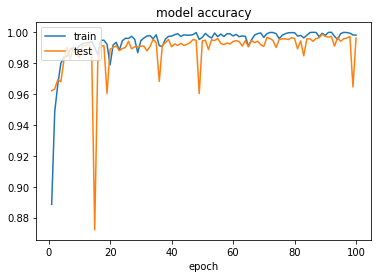

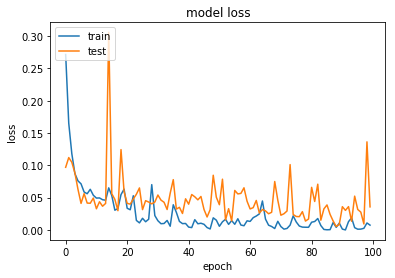

In [8]:
#Print training and validation plots

%matplotlib inline
# summarize history for accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc)+1)
print(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.title('model accuracy')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The test image is a: car


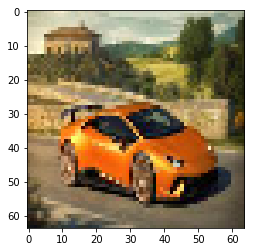

In [9]:
# Test model on single image

test_image = image.load_img('mytrainingdata/lambo.jpg', target_size = (64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'car'
else:
    prediction = 'non-car'

print("The test image is a:",prediction)

In [10]:
#Draw bounding box function

def draw_box(img, bboxes, color=(255,0,0), thickness=6):
    cpyimg = np.copy(img)
    random_color=False;
    for bbox in bboxes:
        if color=='random'or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        #Draw box using opencv
        cv2.rectangle(cpyimg, bbox[0], bbox[1], color, thickness)
        
    #return manipulated image with box
    return cpyimg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


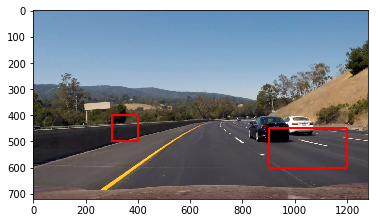

In [11]:
# Test box drawing on sample test_frame image

cars_frame_test_path = glob.glob('Car_dataset/test_images/*')
cars_frame_test =  mpimg.imread(cars_frame_test_path[7])
sample_coordinates = [((300,400),(400,500)),((900,450),(1200,600))]
bboxes = sample_coordinates
box_example_image = cars_frame_test
result = draw_box(box_example_image, bboxes, color=(255,0,0))
plt.imshow(result)

In [12]:
def final_box(heatmap, bboxes):
    # Iterate through list of bboxes
    if bboxes:
        for bbox in bboxes:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
            # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [13]:
def draw_labeled_bboxes(img, labels, color=(0,0,255), thick=4):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, 4)
    # Return the image
    return img

In [14]:
# Calculate how many 64x64 grid squares are in the image(consider image row only from below 400)

rows = cars_frame_test[400:,:].shape[0]/80
cols = cars_frame_test[400:,:].shape[1]/128
rows = int(rows)
cols = int(cols)
print(rows,cols)

# define the amount of overlap between grid cells

OVERLAP = 0.75
grid_rows = int((rows-1)/(1-OVERLAP))+1
grid_cols = int((cols-1)/(1-OVERLAP))+1

print("Image has",(rows, cols),"blocks of 256 pixels, with overlap",OVERLAP,"grid_size =",(grid_rows, grid_cols))


4 10
Image has (4, 10) blocks of 256 pixels, with overlap 0.75 grid_size = (13, 37)


In [26]:
#Function that implements sliding windows and draws heatmap, bounding boxes around vehicles

def slidingwindows(image):
    pixels=[]
    groups = []
    bboxes = []
    # Initialize an empty array for the detections
    heatmap = np.zeros((grid_rows,grid_cols))
    window_height, window_width = 80, 128
    
    imagecpy = image[400:,:]
    
    for i in range(0,grid_rows):
        for j in range(0,grid_cols):
            start_row = i*window_height*(1-OVERLAP)
            start_row = int(start_row)
            start_col = j*window_width*(1-OVERLAP)
            start_col = int(start_col)
        
            # Iterate over each grid square using the model to make a class prediction
            grid_square = imagecpy[start_row:start_row + window_height, start_col:start_col + window_width]
            grid_square_resized = cv2.resize(grid_square,(64,64))
            grid_square_4d = np.expand_dims(grid_square_resized, axis = 0)
            
            # make prediction
            prediction = classifier.predict([grid_square_4d])
            #print(prediction)
            if prediction >0.8:          
            #Store pixel values of originally scaled image when a vehicle is detected in that pixel range
                pixels.append([(start_row+400+int(window_height/2)),(start_col+int(window_width/2))])              
    # Draw boxes around vehicles found in an image
    for k in range(0,len(pixels)):
        groups.append(((pixels[k][1]-int(window_width/2),pixels[k][0]-int(window_height/2)),(pixels[k][1]+int(window_width/2),pixels[k][0]+int(window_height/2))))
        bboxes.append(groups[k])
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap  = final_box(heatmap, bboxes)
    heatmap  = apply_threshold(heatmap,1)
    
    labels = label(heatmap)
    print(labels[1],'cars found')
                
    #frame_test_result = draw_box(image, bboxes, color=(0,255,255))
    frame_test_result = draw_labeled_bboxes(image, labels)
    #printheat(frame_test_result,labels)
    
    return frame_test_result

In [16]:
def printheat(frame_test_result,labels):
#Print heatmap with original image
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(labels[0],cmap='hot')
    ax1.set_title('Heatmap', fontsize=40)

    ax2.imshow(frame_test_result)
    ax2.set_title('Boxes drawn on vehicles', fontsize=40)
    plt.show()

In [17]:
#Function to test my classifier on test frame image pieces

def predict_on_testframe(image,row_number,col_number):
    
    imgcpy = image[row_number-40:row_number+40, col_number-64:col_number+64]
    imgcpy_resized = cv2.resize(imgcpy,(64,64))
    plt.imshow(imgcpy_resized)
    #plt.imsave('mytrainingdata/a25.png',imgcpy_resized)
    imgcpy_4d = np.expand_dims(imgcpy_resized, axis = 0)
    result = classifier.predict(imgcpy_4d)
    if result[0][0] == 1:
        prediction = 'car'
    else:
        prediction = 'non-car'
    print("The test image is a:",prediction)
    

The test image is a: car


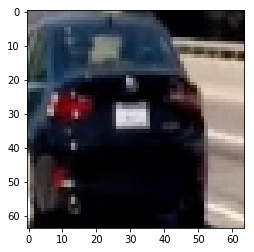

In [24]:
#Predict test frame piece

predict_on_testframe(cars_frame_test_all,450, 900)

2 cars found


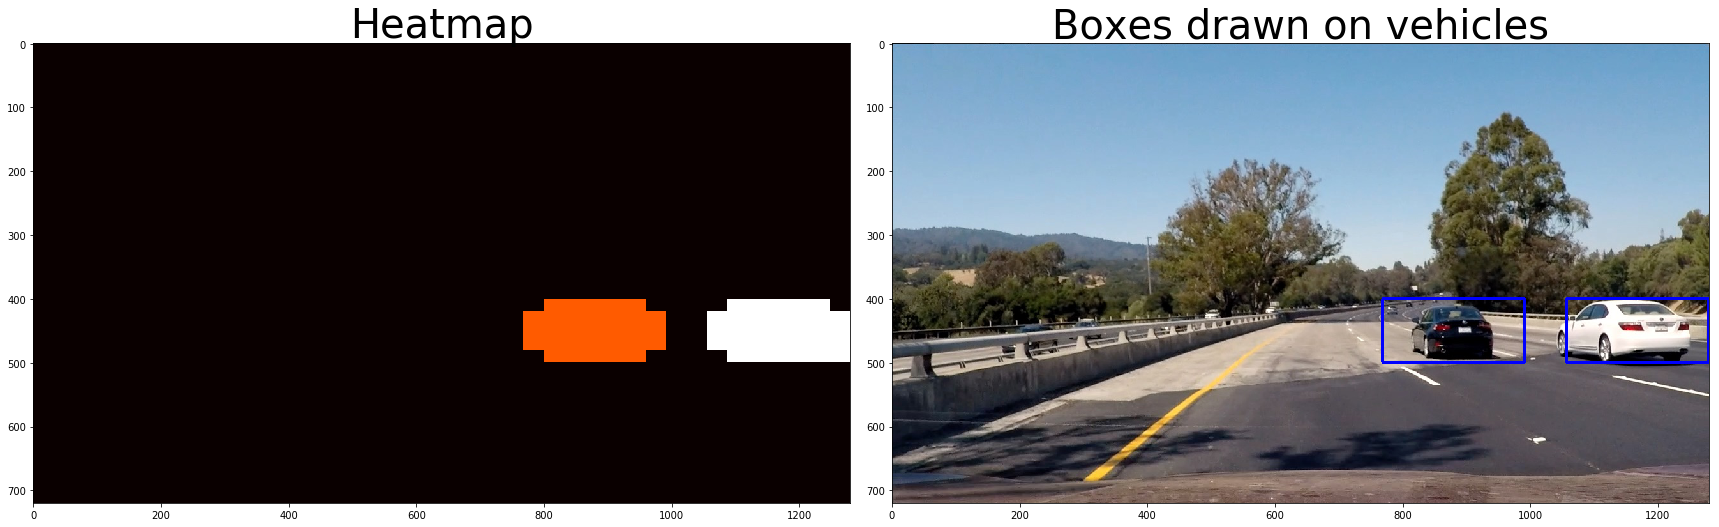

Total time taken for sliding windows on frames 1.6916344165802002


In [22]:
# Start time to count the time for predicting all test frames
start = time.time()

# Predict on all test frame mages
#for k in range(0,len(cars_frame_test_path)):
cars_frame_test_all = mpimg.imread(cars_frame_test_path[13])
slidingwindows(cars_frame_test_all)

end = time.time()

#Calculate time
print("Total time taken for sliding windows on frames",(end-start))

In [27]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(slidingwindows)
%time clip_test_out.write_videofile(test_out_file, audio=False)

2 cars found
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

1 cars found



  3%|██▏                                                                                | 1/39 [00:01<00:39,  1.04s/it]

2 cars found



  5%|████▎                                                                              | 2/39 [00:02<00:37,  1.02s/it]

3 cars found



  8%|██████▍                                                                            | 3/39 [00:02<00:35,  1.01it/s]

2 cars found



 10%|████████▌                                                                          | 4/39 [00:03<00:34,  1.01it/s]

3 cars found



 13%|██████████▋                                                                        | 5/39 [00:05<00:34,  1.01s/it]

2 cars found



 15%|████████████▊                                                                      | 6/39 [00:06<00:33,  1.01s/it]

2 cars found



 18%|██████████████▉                                                                    | 7/39 [00:07<00:32,  1.01s/it]

2 cars found



 21%|█████████████████                                                                  | 8/39 [00:08<00:31,  1.01s/it]

3 cars found



 23%|███████████████████▏                                                               | 9/39 [00:09<00:30,  1.01s/it]

2 cars found



 26%|█████████████████████                                                             | 10/39 [00:10<00:29,  1.01s/it]

2 cars found



 28%|███████████████████████▏                                                          | 11/39 [00:11<00:28,  1.01s/it]

2 cars found



 31%|█████████████████████████▏                                                        | 12/39 [00:12<00:27,  1.01s/it]

2 cars found



 33%|███████████████████████████▎                                                      | 13/39 [00:13<00:26,  1.02s/it]

2 cars found



 36%|█████████████████████████████▍                                                    | 14/39 [00:14<00:25,  1.02s/it]

2 cars found



 38%|███████████████████████████████▌                                                  | 15/39 [00:15<00:24,  1.02s/it]

2 cars found



 41%|█████████████████████████████████▋                                                | 16/39 [00:16<00:23,  1.02s/it]

2 cars found



 44%|███████████████████████████████████▋                                              | 17/39 [00:17<00:22,  1.02s/it]

2 cars found



 46%|█████████████████████████████████████▊                                            | 18/39 [00:18<00:21,  1.02s/it]

2 cars found



 49%|███████████████████████████████████████▉                                          | 19/39 [00:19<00:20,  1.02s/it]

2 cars found



 51%|██████████████████████████████████████████                                        | 20/39 [00:20<00:19,  1.02s/it]

2 cars found



 54%|████████████████████████████████████████████▏                                     | 21/39 [00:21<00:18,  1.02s/it]

2 cars found



 56%|██████████████████████████████████████████████▎                                   | 22/39 [00:22<00:17,  1.02s/it]

2 cars found



 59%|████████████████████████████████████████████████▎                                 | 23/39 [00:23<00:16,  1.02s/it]

2 cars found



 62%|██████████████████████████████████████████████████▍                               | 24/39 [00:24<00:15,  1.02s/it]

2 cars found



 64%|████████████████████████████████████████████████████▌                             | 25/39 [00:25<00:14,  1.03s/it]

2 cars found



 67%|██████████████████████████████████████████████████████▋                           | 26/39 [00:26<00:13,  1.03s/it]

2 cars found



 69%|████████████████████████████████████████████████████████▊                         | 27/39 [00:27<00:12,  1.03s/it]

2 cars found



 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [00:28<00:11,  1.03s/it]

2 cars found



 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [00:29<00:10,  1.03s/it]

2 cars found



 77%|███████████████████████████████████████████████████████████████                   | 30/39 [00:30<00:09,  1.03s/it]

2 cars found



 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [00:31<00:08,  1.03s/it]

2 cars found



 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [00:33<00:07,  1.03s/it]

2 cars found



 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [00:34<00:06,  1.03s/it]

2 cars found



 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [00:35<00:05,  1.04s/it]

2 cars found



 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [00:36<00:04,  1.04s/it]

2 cars found



 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [00:37<00:03,  1.04s/it]

2 cars found



 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [00:38<00:02,  1.04s/it]

2 cars found



 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:39<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 40.4 s


In [49]:
output_file = 'project_video_out.mp4'
proj_input = VideoFileClip('project_video.mp4')
clip_proj_out = proj_input.fl_image(slidingwindows)
%time clip_proj_out.write_videofile(output_file, audio=False)

1 cars found
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

1 cars found


  0%|                                                                               | 1/1261 [00:05<1:56:20,  5.54s/it]

1 cars found


  0%|▏                                                                              | 2/1261 [00:11<1:57:06,  5.58s/it]

1 cars found


  0%|▏                                                                              | 3/1261 [00:16<1:55:51,  5.53s/it]

1 cars found


  0%|▎                                                                              | 4/1261 [00:22<1:55:47,  5.53s/it]

1 cars found


  0%|▎                                                                              | 5/1261 [00:27<1:56:14,  5.55s/it]

0 cars found


  0%|▍                                                                              | 6/1261 [00:33<1:55:59,  5.55s/it]

0 cars found


  1%|▍                                                                              | 7/1261 [00:38<1:56:22,  5.57s/it]

0 cars found


  1%|▌                                                                              | 8/1261 [00:44<1:56:09,  5.56s/it]

0 cars found


  1%|▌                                                                              | 9/1261 [00:50<1:55:59,  5.56s/it]

0 cars found


  1%|▌                                                                             | 10/1261 [00:55<1:55:47,  5.55s/it]

0 cars found


  1%|▋                                                                             | 11/1261 [01:00<1:55:14,  5.53s/it]

0 cars found


  1%|▋                                                                             | 12/1261 [01:06<1:54:56,  5.52s/it]

0 cars found


  1%|▊                                                                             | 13/1261 [01:11<1:54:48,  5.52s/it]

0 cars found


  1%|▊                                                                             | 14/1261 [01:17<1:54:37,  5.52s/it]

0 cars found


  1%|▉                                                                             | 15/1261 [01:22<1:54:26,  5.51s/it]

0 cars found


  1%|▉                                                                             | 16/1261 [01:28<1:54:12,  5.50s/it]

0 cars found


  1%|█                                                                             | 17/1261 [01:33<1:54:07,  5.50s/it]

0 cars found


  1%|█                                                                             | 18/1261 [01:39<1:53:57,  5.50s/it]

0 cars found


  2%|█▏                                                                            | 19/1261 [01:44<1:54:00,  5.51s/it]

0 cars found


  2%|█▏                                                                            | 20/1261 [01:50<1:54:03,  5.51s/it]

0 cars found


  2%|█▎                                                                            | 21/1261 [01:55<1:53:56,  5.51s/it]

0 cars found


  2%|█▎                                                                            | 22/1261 [02:01<1:53:42,  5.51s/it]

0 cars found


  2%|█▍                                                                            | 23/1261 [02:06<1:53:45,  5.51s/it]

0 cars found


  2%|█▍                                                                            | 24/1261 [02:12<1:53:53,  5.52s/it]

0 cars found


  2%|█▌                                                                            | 25/1261 [02:18<1:53:53,  5.53s/it]

0 cars found


  2%|█▌                                                                            | 26/1261 [02:23<1:53:48,  5.53s/it]

0 cars found


  2%|█▋                                                                            | 27/1261 [02:29<1:53:59,  5.54s/it]

0 cars found


  2%|█▋                                                                            | 28/1261 [02:35<1:54:09,  5.56s/it]

0 cars found


  2%|█▊                                                                            | 29/1261 [02:41<1:54:19,  5.57s/it]

0 cars found


  2%|█▊                                                                            | 30/1261 [02:47<1:54:15,  5.57s/it]

0 cars found


  2%|█▉                                                                            | 31/1261 [02:52<1:54:11,  5.57s/it]

0 cars found


  3%|█▉                                                                            | 32/1261 [02:58<1:54:16,  5.58s/it]

0 cars found


  3%|██                                                                            | 33/1261 [03:04<1:54:26,  5.59s/it]

0 cars found


  3%|██                                                                            | 34/1261 [03:10<1:54:32,  5.60s/it]

0 cars found


  3%|██▏                                                                           | 35/1261 [03:16<1:54:38,  5.61s/it]

0 cars found


  3%|██▏                                                                           | 36/1261 [03:22<1:54:44,  5.62s/it]

0 cars found


  3%|██▎                                                                           | 37/1261 [03:28<1:54:48,  5.63s/it]

0 cars found


  3%|██▎                                                                           | 38/1261 [03:34<1:54:50,  5.63s/it]

0 cars found


  3%|██▍                                                                           | 39/1261 [03:40<1:54:53,  5.64s/it]

0 cars found


  3%|██▍                                                                           | 40/1261 [03:45<1:54:51,  5.64s/it]

0 cars found


  3%|██▌                                                                           | 41/1261 [03:51<1:54:45,  5.64s/it]

0 cars found


  3%|██▌                                                                           | 42/1261 [03:57<1:54:43,  5.65s/it]

0 cars found


  3%|██▋                                                                           | 43/1261 [04:02<1:54:37,  5.65s/it]

0 cars found


  3%|██▋                                                                           | 44/1261 [04:08<1:54:31,  5.65s/it]

0 cars found


  4%|██▊                                                                           | 45/1261 [04:14<1:54:32,  5.65s/it]

0 cars found


  4%|██▊                                                                           | 46/1261 [04:20<1:54:32,  5.66s/it]

0 cars found


  4%|██▉                                                                           | 47/1261 [04:26<1:54:34,  5.66s/it]

0 cars found


  4%|██▉                                                                           | 48/1261 [04:32<1:54:35,  5.67s/it]

0 cars found


  4%|███                                                                           | 49/1261 [04:37<1:54:34,  5.67s/it]

0 cars found


  4%|███                                                                           | 50/1261 [04:43<1:54:28,  5.67s/it]

0 cars found


  4%|███▏                                                                          | 51/1261 [04:49<1:54:24,  5.67s/it]

0 cars found


  4%|███▏                                                                          | 52/1261 [04:54<1:54:18,  5.67s/it]

0 cars found


  4%|███▎                                                                          | 53/1261 [05:00<1:54:15,  5.68s/it]

0 cars found


  4%|███▎                                                                          | 54/1261 [05:06<1:54:20,  5.68s/it]

0 cars found


  4%|███▍                                                                          | 55/1261 [05:12<1:54:18,  5.69s/it]

0 cars found


  4%|███▍                                                                          | 56/1261 [05:18<1:54:15,  5.69s/it]

0 cars found


  5%|███▌                                                                          | 57/1261 [05:24<1:54:04,  5.68s/it]

0 cars found


  5%|███▌                                                                          | 58/1261 [05:29<1:53:55,  5.68s/it]

0 cars found


  5%|███▋                                                                          | 59/1261 [05:35<1:53:52,  5.68s/it]

0 cars found


  5%|███▋                                                                          | 60/1261 [05:41<1:53:50,  5.69s/it]

0 cars found


  5%|███▊                                                                          | 61/1261 [05:46<1:53:45,  5.69s/it]

0 cars found


  5%|███▊                                                                          | 62/1261 [05:52<1:53:41,  5.69s/it]

0 cars found


  5%|███▉                                                                          | 63/1261 [05:58<1:53:36,  5.69s/it]

0 cars found


  5%|███▉                                                                          | 64/1261 [06:04<1:53:28,  5.69s/it]

0 cars found


  5%|████                                                                          | 65/1261 [06:09<1:53:21,  5.69s/it]

0 cars found


  5%|████                                                                          | 66/1261 [06:15<1:53:15,  5.69s/it]

0 cars found


  5%|████▏                                                                         | 67/1261 [06:21<1:53:11,  5.69s/it]

0 cars found


  5%|████▏                                                                         | 68/1261 [06:27<1:53:12,  5.69s/it]

0 cars found


  5%|████▎                                                                         | 69/1261 [06:33<1:53:10,  5.70s/it]

0 cars found


  6%|████▎                                                                         | 70/1261 [06:39<1:53:14,  5.70s/it]

0 cars found


  6%|████▍                                                                         | 71/1261 [06:45<1:53:12,  5.71s/it]

0 cars found


  6%|████▍                                                                         | 72/1261 [06:51<1:53:09,  5.71s/it]

0 cars found


  6%|████▌                                                                         | 73/1261 [06:57<1:53:07,  5.71s/it]

0 cars found


  6%|████▌                                                                         | 74/1261 [07:02<1:53:05,  5.72s/it]

0 cars found


  6%|████▋                                                                         | 75/1261 [07:08<1:53:00,  5.72s/it]

0 cars found


  6%|████▋                                                                         | 76/1261 [07:14<1:52:58,  5.72s/it]

0 cars found


  6%|████▊                                                                         | 77/1261 [07:20<1:52:59,  5.73s/it]

0 cars found


  6%|████▊                                                                         | 78/1261 [07:26<1:52:57,  5.73s/it]

0 cars found


  6%|████▉                                                                         | 79/1261 [07:32<1:52:57,  5.73s/it]

0 cars found


  6%|████▉                                                                         | 80/1261 [07:39<1:53:00,  5.74s/it]

0 cars found


  6%|█████                                                                         | 81/1261 [07:45<1:52:54,  5.74s/it]

0 cars found


  7%|█████                                                                         | 82/1261 [07:50<1:52:46,  5.74s/it]

0 cars found


  7%|█████▏                                                                        | 83/1261 [07:56<1:52:38,  5.74s/it]

0 cars found


  7%|█████▏                                                                        | 84/1261 [08:01<1:52:30,  5.74s/it]

0 cars found


  7%|█████▎                                                                        | 85/1261 [08:07<1:52:21,  5.73s/it]

0 cars found


  7%|█████▎                                                                        | 86/1261 [08:12<1:52:13,  5.73s/it]

0 cars found


  7%|█████▍                                                                        | 87/1261 [08:18<1:52:07,  5.73s/it]

0 cars found


  7%|█████▍                                                                        | 88/1261 [08:24<1:52:01,  5.73s/it]

0 cars found


  7%|█████▌                                                                        | 89/1261 [08:30<1:51:56,  5.73s/it]

0 cars found


  7%|█████▌                                                                        | 90/1261 [08:35<1:51:52,  5.73s/it]

0 cars found


  7%|█████▋                                                                        | 91/1261 [08:41<1:51:47,  5.73s/it]

0 cars found


  7%|█████▋                                                                        | 92/1261 [08:47<1:51:43,  5.73s/it]

0 cars found


  7%|█████▊                                                                        | 93/1261 [08:52<1:51:33,  5.73s/it]

0 cars found


  7%|█████▊                                                                        | 94/1261 [08:58<1:51:26,  5.73s/it]

0 cars found


  8%|█████▉                                                                        | 95/1261 [09:04<1:51:18,  5.73s/it]

0 cars found


  8%|█████▉                                                                        | 96/1261 [09:09<1:51:11,  5.73s/it]

0 cars found


  8%|██████                                                                        | 97/1261 [09:15<1:51:04,  5.73s/it]

0 cars found


  8%|██████                                                                        | 98/1261 [09:21<1:50:59,  5.73s/it]

0 cars found


  8%|██████                                                                        | 99/1261 [09:26<1:50:54,  5.73s/it]

0 cars found


  8%|██████                                                                       | 100/1261 [09:32<1:50:52,  5.73s/it]

0 cars found


  8%|██████▏                                                                      | 101/1261 [09:38<1:50:45,  5.73s/it]

0 cars found


  8%|██████▏                                                                      | 102/1261 [09:44<1:50:42,  5.73s/it]

0 cars found


  8%|██████▎                                                                      | 103/1261 [09:50<1:50:41,  5.74s/it]

0 cars found


  8%|██████▎                                                                      | 104/1261 [09:56<1:50:38,  5.74s/it]

0 cars found


  8%|██████▍                                                                      | 105/1261 [10:02<1:50:35,  5.74s/it]

0 cars found


  8%|██████▍                                                                      | 106/1261 [10:08<1:50:32,  5.74s/it]

0 cars found


  8%|██████▌                                                                      | 107/1261 [10:14<1:50:28,  5.74s/it]

0 cars found


  9%|██████▌                                                                      | 108/1261 [10:20<1:50:24,  5.75s/it]

0 cars found


  9%|██████▋                                                                      | 109/1261 [10:26<1:50:19,  5.75s/it]

0 cars found


  9%|██████▋                                                                      | 110/1261 [10:32<1:50:17,  5.75s/it]

0 cars found


  9%|██████▊                                                                      | 111/1261 [10:38<1:50:17,  5.75s/it]

0 cars found


  9%|██████▊                                                                      | 112/1261 [10:44<1:50:13,  5.76s/it]

0 cars found


  9%|██████▉                                                                      | 113/1261 [10:50<1:50:10,  5.76s/it]

0 cars found


  9%|██████▉                                                                      | 114/1261 [10:56<1:50:07,  5.76s/it]

0 cars found


  9%|███████                                                                      | 115/1261 [11:02<1:50:04,  5.76s/it]

0 cars found


  9%|███████                                                                      | 116/1261 [11:08<1:49:58,  5.76s/it]

0 cars found


  9%|███████▏                                                                     | 117/1261 [11:14<1:49:53,  5.76s/it]

0 cars found


  9%|███████▏                                                                     | 118/1261 [11:20<1:49:49,  5.76s/it]

0 cars found


  9%|███████▎                                                                     | 119/1261 [11:25<1:49:40,  5.76s/it]

1 cars found


 10%|███████▎                                                                     | 120/1261 [11:31<1:49:34,  5.76s/it]

1 cars found


 10%|███████▍                                                                     | 121/1261 [11:37<1:49:30,  5.76s/it]

1 cars found


 10%|███████▍                                                                     | 122/1261 [11:43<1:49:25,  5.76s/it]

1 cars found


 10%|███████▌                                                                     | 123/1261 [11:49<1:49:23,  5.77s/it]

1 cars found


 10%|███████▌                                                                     | 124/1261 [11:55<1:49:17,  5.77s/it]

1 cars found


 10%|███████▋                                                                     | 125/1261 [12:00<1:49:12,  5.77s/it]

1 cars found


 10%|███████▋                                                                     | 126/1261 [12:06<1:49:04,  5.77s/it]

1 cars found


 10%|███████▊                                                                     | 127/1261 [12:12<1:48:59,  5.77s/it]

1 cars found


 10%|███████▊                                                                     | 128/1261 [12:18<1:48:54,  5.77s/it]

1 cars found


 10%|███████▉                                                                     | 129/1261 [12:23<1:48:47,  5.77s/it]

1 cars found


 10%|███████▉                                                                     | 130/1261 [12:29<1:48:40,  5.77s/it]

1 cars found


 10%|███████▉                                                                     | 131/1261 [12:35<1:48:34,  5.77s/it]

1 cars found


 10%|████████                                                                     | 132/1261 [12:40<1:48:28,  5.77s/it]

1 cars found


 11%|████████                                                                     | 133/1261 [12:46<1:48:22,  5.77s/it]

1 cars found


 11%|████████▏                                                                    | 134/1261 [12:52<1:48:19,  5.77s/it]

1 cars found


 11%|████████▏                                                                    | 135/1261 [12:58<1:48:14,  5.77s/it]

1 cars found


 11%|████████▎                                                                    | 136/1261 [13:04<1:48:06,  5.77s/it]

1 cars found


 11%|████████▎                                                                    | 137/1261 [13:09<1:47:59,  5.77s/it]

0 cars found


 11%|████████▍                                                                    | 138/1261 [13:15<1:47:50,  5.76s/it]

0 cars found


 11%|████████▍                                                                    | 139/1261 [13:21<1:47:48,  5.76s/it]

0 cars found


 11%|████████▌                                                                    | 140/1261 [13:27<1:47:44,  5.77s/it]

0 cars found


 11%|████████▌                                                                    | 141/1261 [13:33<1:47:38,  5.77s/it]

0 cars found


 11%|████████▋                                                                    | 142/1261 [13:38<1:47:32,  5.77s/it]

0 cars found


 11%|████████▋                                                                    | 143/1261 [13:44<1:47:27,  5.77s/it]

0 cars found


 11%|████████▊                                                                    | 144/1261 [13:50<1:47:23,  5.77s/it]

0 cars found


 11%|████████▊                                                                    | 145/1261 [13:56<1:47:17,  5.77s/it]

0 cars found


 12%|████████▉                                                                    | 146/1261 [14:02<1:47:13,  5.77s/it]

0 cars found


 12%|████████▉                                                                    | 147/1261 [14:08<1:47:09,  5.77s/it]

0 cars found


 12%|█████████                                                                    | 148/1261 [14:14<1:47:04,  5.77s/it]

0 cars found


 12%|█████████                                                                    | 149/1261 [14:19<1:46:56,  5.77s/it]

0 cars found


 12%|█████████▏                                                                   | 150/1261 [14:24<1:46:46,  5.77s/it]

0 cars found


 12%|█████████▏                                                                   | 151/1261 [14:30<1:46:38,  5.76s/it]

0 cars found


 12%|█████████▎                                                                   | 152/1261 [14:35<1:46:30,  5.76s/it]

0 cars found


 12%|█████████▎                                                                   | 153/1261 [14:41<1:46:22,  5.76s/it]

0 cars found


 12%|█████████▍                                                                   | 154/1261 [14:46<1:46:14,  5.76s/it]

0 cars found


 12%|█████████▍                                                                   | 155/1261 [14:52<1:46:05,  5.76s/it]

0 cars found


 12%|█████████▌                                                                   | 156/1261 [14:57<1:45:57,  5.75s/it]

0 cars found


 12%|█████████▌                                                                   | 157/1261 [15:03<1:45:50,  5.75s/it]

0 cars found


 13%|█████████▋                                                                   | 158/1261 [15:08<1:45:43,  5.75s/it]

0 cars found


 13%|█████████▋                                                                   | 159/1261 [15:14<1:45:35,  5.75s/it]

0 cars found


 13%|█████████▊                                                                   | 160/1261 [15:19<1:45:28,  5.75s/it]

0 cars found


 13%|█████████▊                                                                   | 161/1261 [15:25<1:45:20,  5.75s/it]

0 cars found


 13%|█████████▉                                                                   | 162/1261 [15:30<1:45:12,  5.74s/it]

0 cars found


 13%|█████████▉                                                                   | 163/1261 [15:35<1:45:04,  5.74s/it]

0 cars found


 13%|██████████                                                                   | 164/1261 [15:41<1:44:57,  5.74s/it]

0 cars found


 13%|██████████                                                                   | 165/1261 [15:46<1:44:49,  5.74s/it]

0 cars found


 13%|██████████▏                                                                  | 166/1261 [15:52<1:44:42,  5.74s/it]

0 cars found


 13%|██████████▏                                                                  | 167/1261 [15:57<1:44:35,  5.74s/it]

0 cars found


 13%|██████████▎                                                                  | 168/1261 [16:03<1:44:26,  5.73s/it]

0 cars found


 13%|██████████▎                                                                  | 169/1261 [16:08<1:44:17,  5.73s/it]

0 cars found


 13%|██████████▍                                                                  | 170/1261 [16:13<1:44:10,  5.73s/it]

0 cars found


 14%|██████████▍                                                                  | 171/1261 [16:19<1:44:02,  5.73s/it]

0 cars found


 14%|██████████▌                                                                  | 172/1261 [16:24<1:43:55,  5.73s/it]

0 cars found


 14%|██████████▌                                                                  | 173/1261 [16:30<1:43:47,  5.72s/it]

0 cars found


 14%|██████████▌                                                                  | 174/1261 [16:35<1:43:40,  5.72s/it]

0 cars found


 14%|██████████▋                                                                  | 175/1261 [16:41<1:43:33,  5.72s/it]

0 cars found


 14%|██████████▋                                                                  | 176/1261 [16:46<1:43:26,  5.72s/it]

0 cars found


 14%|██████████▊                                                                  | 177/1261 [16:52<1:43:17,  5.72s/it]

0 cars found


 14%|██████████▊                                                                  | 178/1261 [16:57<1:43:10,  5.72s/it]

0 cars found


 14%|██████████▉                                                                  | 179/1261 [17:02<1:43:03,  5.71s/it]

0 cars found


 14%|██████████▉                                                                  | 180/1261 [17:08<1:42:55,  5.71s/it]

0 cars found


 14%|███████████                                                                  | 181/1261 [17:13<1:42:48,  5.71s/it]

0 cars found


 14%|███████████                                                                  | 182/1261 [17:19<1:42:41,  5.71s/it]

0 cars found


 15%|███████████▏                                                                 | 183/1261 [17:24<1:42:33,  5.71s/it]

0 cars found


 15%|███████████▏                                                                 | 184/1261 [17:30<1:42:26,  5.71s/it]

0 cars found


 15%|███████████▎                                                                 | 185/1261 [17:35<1:42:19,  5.71s/it]

0 cars found


 15%|███████████▎                                                                 | 186/1261 [17:40<1:42:11,  5.70s/it]

0 cars found


 15%|███████████▍                                                                 | 187/1261 [17:46<1:42:04,  5.70s/it]

0 cars found


 15%|███████████▍                                                                 | 188/1261 [17:51<1:41:57,  5.70s/it]

0 cars found


 15%|███████████▌                                                                 | 189/1261 [17:57<1:41:50,  5.70s/it]

0 cars found


 15%|███████████▌                                                                 | 190/1261 [18:02<1:41:43,  5.70s/it]

0 cars found


 15%|███████████▋                                                                 | 191/1261 [18:08<1:41:36,  5.70s/it]

0 cars found


 15%|███████████▋                                                                 | 192/1261 [18:13<1:41:28,  5.70s/it]

0 cars found


 15%|███████████▊                                                                 | 193/1261 [18:19<1:41:22,  5.70s/it]

1 cars found


 15%|███████████▊                                                                 | 194/1261 [18:24<1:41:14,  5.69s/it]

1 cars found


 15%|███████████▉                                                                 | 195/1261 [18:29<1:41:07,  5.69s/it]

1 cars found


 16%|███████████▉                                                                 | 196/1261 [18:35<1:41:00,  5.69s/it]

0 cars found


 16%|████████████                                                                 | 197/1261 [18:40<1:40:53,  5.69s/it]

1 cars found


 16%|████████████                                                                 | 198/1261 [18:46<1:40:46,  5.69s/it]

1 cars found


 16%|████████████▏                                                                | 199/1261 [18:51<1:40:39,  5.69s/it]

1 cars found


 16%|████████████▏                                                                | 200/1261 [18:57<1:40:32,  5.69s/it]

1 cars found


 16%|████████████▎                                                                | 201/1261 [19:02<1:40:26,  5.69s/it]

1 cars found


 16%|████████████▎                                                                | 202/1261 [19:08<1:40:19,  5.68s/it]

1 cars found


 16%|████████████▍                                                                | 203/1261 [19:13<1:40:12,  5.68s/it]

1 cars found


 16%|████████████▍                                                                | 204/1261 [19:19<1:40:05,  5.68s/it]

1 cars found


 16%|████████████▌                                                                | 205/1261 [19:24<1:39:58,  5.68s/it]

1 cars found


 16%|████████████▌                                                                | 206/1261 [19:29<1:39:51,  5.68s/it]

1 cars found


 16%|████████████▋                                                                | 207/1261 [19:35<1:39:44,  5.68s/it]

1 cars found


 16%|████████████▋                                                                | 208/1261 [19:40<1:39:37,  5.68s/it]

1 cars found


 17%|████████████▊                                                                | 209/1261 [19:46<1:39:31,  5.68s/it]

1 cars found


 17%|████████████▊                                                                | 210/1261 [19:51<1:39:23,  5.67s/it]

1 cars found


 17%|████████████▉                                                                | 211/1261 [19:57<1:39:16,  5.67s/it]

1 cars found


 17%|████████████▉                                                                | 212/1261 [20:02<1:39:09,  5.67s/it]

1 cars found


 17%|█████████████                                                                | 213/1261 [20:07<1:39:02,  5.67s/it]

1 cars found


 17%|█████████████                                                                | 214/1261 [20:13<1:38:55,  5.67s/it]

1 cars found


 17%|█████████████▏                                                               | 215/1261 [20:18<1:38:49,  5.67s/it]

1 cars found


 17%|█████████████▏                                                               | 216/1261 [20:24<1:38:42,  5.67s/it]

1 cars found


 17%|█████████████▎                                                               | 217/1261 [20:29<1:38:35,  5.67s/it]

1 cars found


 17%|█████████████▎                                                               | 218/1261 [20:35<1:38:28,  5.67s/it]

1 cars found


 17%|█████████████▎                                                               | 219/1261 [20:40<1:38:22,  5.66s/it]

1 cars found


 17%|█████████████▍                                                               | 220/1261 [20:45<1:38:15,  5.66s/it]

1 cars found


 18%|█████████████▍                                                               | 221/1261 [20:51<1:38:08,  5.66s/it]

1 cars found


 18%|█████████████▌                                                               | 222/1261 [20:56<1:38:01,  5.66s/it]

1 cars found


 18%|█████████████▌                                                               | 223/1261 [21:02<1:37:55,  5.66s/it]

1 cars found


 18%|█████████████▋                                                               | 224/1261 [21:07<1:37:48,  5.66s/it]

1 cars found


 18%|█████████████▋                                                               | 225/1261 [21:13<1:37:41,  5.66s/it]

1 cars found


 18%|█████████████▊                                                               | 226/1261 [21:18<1:37:35,  5.66s/it]

1 cars found


 18%|█████████████▊                                                               | 227/1261 [21:23<1:37:28,  5.66s/it]

2 cars found


 18%|█████████████▉                                                               | 228/1261 [21:29<1:37:21,  5.66s/it]

1 cars found


 18%|█████████████▉                                                               | 229/1261 [21:35<1:37:16,  5.66s/it]

1 cars found


 18%|██████████████                                                               | 230/1261 [21:40<1:37:11,  5.66s/it]

1 cars found


 18%|██████████████                                                               | 231/1261 [21:46<1:37:05,  5.66s/it]

1 cars found


 18%|██████████████▏                                                              | 232/1261 [21:52<1:37:01,  5.66s/it]

1 cars found


 18%|██████████████▏                                                              | 233/1261 [21:58<1:36:56,  5.66s/it]

1 cars found


 19%|██████████████▎                                                              | 234/1261 [22:04<1:36:51,  5.66s/it]

1 cars found


 19%|██████████████▎                                                              | 235/1261 [22:10<1:36:47,  5.66s/it]

1 cars found


 19%|██████████████▍                                                              | 236/1261 [22:16<1:36:42,  5.66s/it]

1 cars found


 19%|██████████████▍                                                              | 237/1261 [22:21<1:36:37,  5.66s/it]

1 cars found


 19%|██████████████▌                                                              | 238/1261 [22:27<1:36:32,  5.66s/it]

1 cars found


 19%|██████████████▌                                                              | 239/1261 [22:33<1:36:27,  5.66s/it]

1 cars found


 19%|██████████████▋                                                              | 240/1261 [22:38<1:36:21,  5.66s/it]

1 cars found


 19%|██████████████▋                                                              | 241/1261 [22:45<1:36:17,  5.66s/it]

1 cars found


 19%|██████████████▊                                                              | 242/1261 [22:50<1:36:12,  5.66s/it]

1 cars found


 19%|██████████████▊                                                              | 243/1261 [22:56<1:36:07,  5.67s/it]

1 cars found


 19%|██████████████▉                                                              | 244/1261 [23:02<1:36:02,  5.67s/it]

1 cars found


 19%|██████████████▉                                                              | 245/1261 [23:08<1:35:56,  5.67s/it]

2 cars found


 20%|███████████████                                                              | 246/1261 [23:14<1:35:52,  5.67s/it]

1 cars found


 20%|███████████████                                                              | 247/1261 [23:19<1:35:47,  5.67s/it]

1 cars found


 20%|███████████████▏                                                             | 248/1261 [23:26<1:35:43,  5.67s/it]

2 cars found


 20%|███████████████▏                                                             | 249/1261 [23:32<1:35:38,  5.67s/it]

1 cars found


 20%|███████████████▎                                                             | 250/1261 [23:38<1:35:34,  5.67s/it]

1 cars found


 20%|███████████████▎                                                             | 251/1261 [23:44<1:35:30,  5.67s/it]

1 cars found


 20%|███████████████▍                                                             | 252/1261 [23:50<1:35:25,  5.67s/it]

1 cars found


 20%|███████████████▍                                                             | 253/1261 [23:55<1:35:20,  5.68s/it]

1 cars found


 20%|███████████████▌                                                             | 254/1261 [24:01<1:35:15,  5.68s/it]

1 cars found


 20%|███████████████▌                                                             | 255/1261 [24:07<1:35:10,  5.68s/it]

1 cars found


 20%|███████████████▋                                                             | 256/1261 [24:13<1:35:07,  5.68s/it]

1 cars found


 20%|███████████████▋                                                             | 257/1261 [24:20<1:35:03,  5.68s/it]

1 cars found


 20%|███████████████▊                                                             | 258/1261 [24:26<1:34:59,  5.68s/it]

1 cars found


 21%|███████████████▊                                                             | 259/1261 [24:32<1:34:55,  5.68s/it]

1 cars found


 21%|███████████████▉                                                             | 260/1261 [24:38<1:34:50,  5.68s/it]

1 cars found


 21%|███████████████▉                                                             | 261/1261 [24:44<1:34:46,  5.69s/it]

1 cars found


 21%|███████████████▉                                                             | 262/1261 [24:49<1:34:39,  5.69s/it]

1 cars found


 21%|████████████████                                                             | 263/1261 [24:55<1:34:33,  5.68s/it]

1 cars found


 21%|████████████████                                                             | 264/1261 [25:00<1:34:26,  5.68s/it]

1 cars found


 21%|████████████████▏                                                            | 265/1261 [25:05<1:34:19,  5.68s/it]

1 cars found


 21%|████████████████▏                                                            | 266/1261 [25:11<1:34:12,  5.68s/it]

1 cars found


 21%|████████████████▎                                                            | 267/1261 [25:16<1:34:06,  5.68s/it]

1 cars found


 21%|████████████████▎                                                            | 268/1261 [25:22<1:33:59,  5.68s/it]

1 cars found


 21%|████████████████▍                                                            | 269/1261 [25:27<1:33:53,  5.68s/it]

1 cars found


 21%|████████████████▍                                                            | 270/1261 [25:32<1:33:46,  5.68s/it]

1 cars found


 21%|████████████████▌                                                            | 271/1261 [25:38<1:33:40,  5.68s/it]

1 cars found


 22%|████████████████▌                                                            | 272/1261 [25:44<1:33:34,  5.68s/it]

1 cars found


 22%|████████████████▋                                                            | 273/1261 [25:49<1:33:29,  5.68s/it]

1 cars found


 22%|████████████████▋                                                            | 274/1261 [25:55<1:33:23,  5.68s/it]

1 cars found


 22%|████████████████▊                                                            | 275/1261 [26:01<1:33:17,  5.68s/it]

1 cars found


 22%|████████████████▊                                                            | 276/1261 [26:06<1:33:11,  5.68s/it]

1 cars found


 22%|████████████████▉                                                            | 277/1261 [26:12<1:33:04,  5.68s/it]

1 cars found


 22%|████████████████▉                                                            | 278/1261 [26:17<1:32:58,  5.68s/it]

1 cars found


 22%|█████████████████                                                            | 279/1261 [26:23<1:32:52,  5.67s/it]

1 cars found


 22%|█████████████████                                                            | 280/1261 [26:28<1:32:46,  5.67s/it]

1 cars found


 22%|█████████████████▏                                                           | 281/1261 [26:34<1:32:39,  5.67s/it]

1 cars found


 22%|█████████████████▏                                                           | 282/1261 [26:39<1:32:34,  5.67s/it]

1 cars found


 22%|█████████████████▎                                                           | 283/1261 [26:45<1:32:28,  5.67s/it]

1 cars found


 23%|█████████████████▎                                                           | 284/1261 [26:51<1:32:22,  5.67s/it]

1 cars found


 23%|█████████████████▍                                                           | 285/1261 [26:56<1:32:15,  5.67s/it]

1 cars found


 23%|█████████████████▍                                                           | 286/1261 [27:01<1:32:08,  5.67s/it]

1 cars found


 23%|█████████████████▌                                                           | 287/1261 [27:07<1:32:02,  5.67s/it]

1 cars found


 23%|█████████████████▌                                                           | 288/1261 [27:12<1:31:56,  5.67s/it]

1 cars found


 23%|█████████████████▋                                                           | 289/1261 [27:18<1:31:49,  5.67s/it]

1 cars found


 23%|█████████████████▋                                                           | 290/1261 [27:23<1:31:43,  5.67s/it]

1 cars found


 23%|█████████████████▊                                                           | 291/1261 [27:29<1:31:37,  5.67s/it]

1 cars found


 23%|█████████████████▊                                                           | 292/1261 [27:34<1:31:31,  5.67s/it]

1 cars found


 23%|█████████████████▉                                                           | 293/1261 [27:40<1:31:25,  5.67s/it]

1 cars found


 23%|█████████████████▉                                                           | 294/1261 [27:45<1:31:19,  5.67s/it]

1 cars found


 23%|██████████████████                                                           | 295/1261 [27:51<1:31:13,  5.67s/it]

1 cars found


 23%|██████████████████                                                           | 296/1261 [27:56<1:31:06,  5.67s/it]

1 cars found


 24%|██████████████████▏                                                          | 297/1261 [28:02<1:31:00,  5.66s/it]

1 cars found


 24%|██████████████████▏                                                          | 298/1261 [28:07<1:30:54,  5.66s/it]

1 cars found


 24%|██████████████████▎                                                          | 299/1261 [28:13<1:30:48,  5.66s/it]

1 cars found


 24%|██████████████████▎                                                          | 300/1261 [28:18<1:30:42,  5.66s/it]

1 cars found


 24%|██████████████████▍                                                          | 301/1261 [28:24<1:30:36,  5.66s/it]

1 cars found


 24%|██████████████████▍                                                          | 302/1261 [28:29<1:30:30,  5.66s/it]

1 cars found


 24%|██████████████████▌                                                          | 303/1261 [28:35<1:30:23,  5.66s/it]

1 cars found


 24%|██████████████████▌                                                          | 304/1261 [28:41<1:30:17,  5.66s/it]

1 cars found


 24%|██████████████████▌                                                          | 305/1261 [28:46<1:30:11,  5.66s/it]

1 cars found


 24%|██████████████████▋                                                          | 306/1261 [28:52<1:30:05,  5.66s/it]

1 cars found


 24%|██████████████████▋                                                          | 307/1261 [28:57<1:29:59,  5.66s/it]

1 cars found


 24%|██████████████████▊                                                          | 308/1261 [29:02<1:29:52,  5.66s/it]

1 cars found


 25%|██████████████████▊                                                          | 309/1261 [29:08<1:29:46,  5.66s/it]

1 cars found


 25%|██████████████████▉                                                          | 310/1261 [29:13<1:29:40,  5.66s/it]

1 cars found


 25%|██████████████████▉                                                          | 311/1261 [29:19<1:29:34,  5.66s/it]

1 cars found


 25%|███████████████████                                                          | 312/1261 [29:24<1:29:28,  5.66s/it]

1 cars found


 25%|███████████████████                                                          | 313/1261 [29:30<1:29:22,  5.66s/it]

1 cars found


 25%|███████████████████▏                                                         | 314/1261 [29:35<1:29:16,  5.66s/it]

1 cars found


 25%|███████████████████▏                                                         | 315/1261 [29:41<1:29:10,  5.66s/it]

1 cars found


 25%|███████████████████▎                                                         | 316/1261 [29:47<1:29:04,  5.66s/it]

1 cars found


 25%|███████████████████▎                                                         | 317/1261 [29:52<1:28:57,  5.65s/it]

1 cars found


 25%|███████████████████▍                                                         | 318/1261 [29:57<1:28:51,  5.65s/it]

1 cars found


 25%|███████████████████▍                                                         | 319/1261 [30:03<1:28:45,  5.65s/it]

1 cars found


 25%|███████████████████▌                                                         | 320/1261 [30:08<1:28:39,  5.65s/it]

1 cars found


 25%|███████████████████▌                                                         | 321/1261 [30:14<1:28:33,  5.65s/it]

1 cars found


 26%|███████████████████▋                                                         | 322/1261 [30:19<1:28:27,  5.65s/it]

1 cars found


 26%|███████████████████▋                                                         | 323/1261 [30:25<1:28:20,  5.65s/it]

1 cars found


 26%|███████████████████▊                                                         | 324/1261 [30:30<1:28:14,  5.65s/it]

1 cars found


 26%|███████████████████▊                                                         | 325/1261 [30:36<1:28:08,  5.65s/it]

1 cars found


 26%|███████████████████▉                                                         | 326/1261 [30:41<1:28:02,  5.65s/it]

1 cars found


 26%|███████████████████▉                                                         | 327/1261 [30:47<1:27:56,  5.65s/it]

1 cars found


 26%|████████████████████                                                         | 328/1261 [30:52<1:27:49,  5.65s/it]

1 cars found


 26%|████████████████████                                                         | 329/1261 [30:58<1:27:43,  5.65s/it]

1 cars found


 26%|████████████████████▏                                                        | 330/1261 [31:03<1:27:37,  5.65s/it]

1 cars found


 26%|████████████████████▏                                                        | 331/1261 [31:09<1:27:31,  5.65s/it]

1 cars found


 26%|████████████████████▎                                                        | 332/1261 [31:14<1:27:25,  5.65s/it]

1 cars found


 26%|████████████████████▎                                                        | 333/1261 [31:20<1:27:20,  5.65s/it]

1 cars found


 26%|████████████████████▍                                                        | 334/1261 [31:26<1:27:14,  5.65s/it]

1 cars found


 27%|████████████████████▍                                                        | 335/1261 [31:31<1:27:09,  5.65s/it]

1 cars found


 27%|████████████████████▌                                                        | 336/1261 [31:37<1:27:03,  5.65s/it]

1 cars found


 27%|████████████████████▌                                                        | 337/1261 [31:43<1:26:58,  5.65s/it]

1 cars found


 27%|████████████████████▋                                                        | 338/1261 [31:49<1:26:53,  5.65s/it]

1 cars found


 27%|████████████████████▋                                                        | 339/1261 [31:54<1:26:48,  5.65s/it]

1 cars found


 27%|████████████████████▊                                                        | 340/1261 [32:01<1:26:43,  5.65s/it]

1 cars found


 27%|████████████████████▊                                                        | 341/1261 [32:06<1:26:37,  5.65s/it]

1 cars found


 27%|████████████████████▉                                                        | 342/1261 [32:12<1:26:32,  5.65s/it]

1 cars found


 27%|████████████████████▉                                                        | 343/1261 [32:18<1:26:27,  5.65s/it]

1 cars found


 27%|█████████████████████                                                        | 344/1261 [32:24<1:26:22,  5.65s/it]

1 cars found


 27%|█████████████████████                                                        | 345/1261 [32:30<1:26:17,  5.65s/it]

1 cars found


 27%|█████████████████████▏                                                       | 346/1261 [32:36<1:26:13,  5.65s/it]

1 cars found


 28%|█████████████████████▏                                                       | 347/1261 [32:42<1:26:08,  5.65s/it]

1 cars found


 28%|█████████████████████▏                                                       | 348/1261 [32:48<1:26:03,  5.66s/it]

1 cars found


 28%|█████████████████████▎                                                       | 349/1261 [32:54<1:25:58,  5.66s/it]

1 cars found


 28%|█████████████████████▎                                                       | 350/1261 [33:00<1:25:53,  5.66s/it]

1 cars found


 28%|█████████████████████▍                                                       | 351/1261 [33:05<1:25:48,  5.66s/it]

1 cars found


 28%|█████████████████████▍                                                       | 352/1261 [33:11<1:25:43,  5.66s/it]

1 cars found


 28%|█████████████████████▌                                                       | 353/1261 [33:17<1:25:38,  5.66s/it]

1 cars found


 28%|█████████████████████▌                                                       | 354/1261 [33:23<1:25:32,  5.66s/it]

1 cars found


 28%|█████████████████████▋                                                       | 355/1261 [33:29<1:25:27,  5.66s/it]

1 cars found


 28%|█████████████████████▋                                                       | 356/1261 [33:35<1:25:22,  5.66s/it]

1 cars found


 28%|█████████████████████▊                                                       | 357/1261 [33:40<1:25:17,  5.66s/it]

1 cars found


 28%|█████████████████████▊                                                       | 358/1261 [33:46<1:25:11,  5.66s/it]

1 cars found


 28%|█████████████████████▉                                                       | 359/1261 [33:51<1:25:05,  5.66s/it]

1 cars found


 29%|█████████████████████▉                                                       | 360/1261 [33:57<1:24:59,  5.66s/it]

1 cars found


 29%|██████████████████████                                                       | 361/1261 [34:03<1:24:54,  5.66s/it]

1 cars found


 29%|██████████████████████                                                       | 362/1261 [34:08<1:24:48,  5.66s/it]

1 cars found


 29%|██████████████████████▏                                                      | 363/1261 [34:14<1:24:43,  5.66s/it]

1 cars found


 29%|██████████████████████▏                                                      | 364/1261 [34:20<1:24:38,  5.66s/it]

1 cars found


 29%|██████████████████████▎                                                      | 365/1261 [34:26<1:24:33,  5.66s/it]

1 cars found


 29%|██████████████████████▎                                                      | 366/1261 [34:32<1:24:27,  5.66s/it]

1 cars found


 29%|██████████████████████▍                                                      | 367/1261 [34:38<1:24:23,  5.66s/it]

1 cars found


 29%|██████████████████████▍                                                      | 368/1261 [34:44<1:24:18,  5.66s/it]

1 cars found


 29%|██████████████████████▌                                                      | 369/1261 [34:50<1:24:13,  5.67s/it]

1 cars found


 29%|██████████████████████▌                                                      | 370/1261 [34:56<1:24:08,  5.67s/it]

1 cars found


 29%|██████████████████████▋                                                      | 371/1261 [35:02<1:24:04,  5.67s/it]

1 cars found


 30%|██████████████████████▋                                                      | 372/1261 [35:08<1:23:58,  5.67s/it]

1 cars found


 30%|██████████████████████▊                                                      | 373/1261 [35:14<1:23:54,  5.67s/it]

1 cars found


 30%|██████████████████████▊                                                      | 374/1261 [35:20<1:23:49,  5.67s/it]

1 cars found


 30%|██████████████████████▉                                                      | 375/1261 [35:26<1:23:44,  5.67s/it]

1 cars found


 30%|██████████████████████▉                                                      | 376/1261 [35:32<1:23:39,  5.67s/it]

1 cars found


 30%|███████████████████████                                                      | 377/1261 [35:38<1:23:34,  5.67s/it]

1 cars found


 30%|███████████████████████                                                      | 378/1261 [35:44<1:23:29,  5.67s/it]

1 cars found


 30%|███████████████████████▏                                                     | 379/1261 [35:50<1:23:24,  5.67s/it]

1 cars found


 30%|███████████████████████▏                                                     | 380/1261 [35:55<1:23:18,  5.67s/it]

1 cars found


 30%|███████████████████████▎                                                     | 381/1261 [36:01<1:23:12,  5.67s/it]

1 cars found


 30%|███████████████████████▎                                                     | 382/1261 [36:07<1:23:07,  5.67s/it]

1 cars found


 30%|███████████████████████▍                                                     | 383/1261 [36:13<1:23:03,  5.68s/it]

1 cars found


 30%|███████████████████████▍                                                     | 384/1261 [36:19<1:22:58,  5.68s/it]

1 cars found


 31%|███████████████████████▌                                                     | 385/1261 [36:25<1:22:52,  5.68s/it]

1 cars found


 31%|███████████████████████▌                                                     | 386/1261 [36:31<1:22:48,  5.68s/it]

1 cars found


 31%|███████████████████████▋                                                     | 387/1261 [36:37<1:22:43,  5.68s/it]

1 cars found


 31%|███████████████████████▋                                                     | 388/1261 [36:43<1:22:38,  5.68s/it]

1 cars found


 31%|███████████████████████▊                                                     | 389/1261 [36:49<1:22:32,  5.68s/it]

1 cars found


 31%|███████████████████████▊                                                     | 390/1261 [36:54<1:22:26,  5.68s/it]

1 cars found


 31%|███████████████████████▉                                                     | 391/1261 [37:00<1:22:20,  5.68s/it]

1 cars found


 31%|███████████████████████▉                                                     | 392/1261 [37:05<1:22:14,  5.68s/it]

1 cars found


 31%|███████████████████████▉                                                     | 393/1261 [37:11<1:22:08,  5.68s/it]

1 cars found


 31%|████████████████████████                                                     | 394/1261 [37:17<1:22:02,  5.68s/it]

1 cars found


 31%|████████████████████████                                                     | 395/1261 [37:22<1:21:57,  5.68s/it]

1 cars found


 31%|████████████████████████▏                                                    | 396/1261 [37:28<1:21:51,  5.68s/it]

1 cars found


 31%|████████████████████████▏                                                    | 397/1261 [37:34<1:21:46,  5.68s/it]

1 cars found


 32%|████████████████████████▎                                                    | 398/1261 [37:40<1:21:41,  5.68s/it]

1 cars found


 32%|████████████████████████▎                                                    | 399/1261 [37:45<1:21:35,  5.68s/it]

1 cars found


 32%|████████████████████████▍                                                    | 400/1261 [37:51<1:21:29,  5.68s/it]

1 cars found


 32%|████████████████████████▍                                                    | 401/1261 [37:57<1:21:24,  5.68s/it]

1 cars found


 32%|████████████████████████▌                                                    | 402/1261 [38:03<1:21:18,  5.68s/it]

1 cars found


 32%|████████████████████████▌                                                    | 403/1261 [38:08<1:21:13,  5.68s/it]

1 cars found


 32%|████████████████████████▋                                                    | 404/1261 [38:14<1:21:08,  5.68s/it]

1 cars found


 32%|████████████████████████▋                                                    | 405/1261 [38:20<1:21:03,  5.68s/it]

1 cars found


 32%|████████████████████████▊                                                    | 406/1261 [38:26<1:20:58,  5.68s/it]

1 cars found


 32%|████████████████████████▊                                                    | 407/1261 [38:33<1:20:53,  5.68s/it]

1 cars found


 32%|████████████████████████▉                                                    | 408/1261 [38:38<1:20:47,  5.68s/it]

1 cars found


 32%|████████████████████████▉                                                    | 409/1261 [38:44<1:20:42,  5.68s/it]

1 cars found


 33%|█████████████████████████                                                    | 410/1261 [38:50<1:20:37,  5.68s/it]

1 cars found


 33%|█████████████████████████                                                    | 411/1261 [38:56<1:20:31,  5.68s/it]

1 cars found


 33%|█████████████████████████▏                                                   | 412/1261 [39:02<1:20:26,  5.68s/it]

1 cars found


 33%|█████████████████████████▏                                                   | 413/1261 [39:07<1:20:21,  5.69s/it]

1 cars found


 33%|█████████████████████████▎                                                   | 414/1261 [39:13<1:20:16,  5.69s/it]

1 cars found


 33%|█████████████████████████▎                                                   | 415/1261 [39:19<1:20:10,  5.69s/it]

1 cars found


 33%|█████████████████████████▍                                                   | 416/1261 [39:25<1:20:05,  5.69s/it]

1 cars found


 33%|█████████████████████████▍                                                   | 417/1261 [39:31<1:19:59,  5.69s/it]

1 cars found


 33%|█████████████████████████▌                                                   | 418/1261 [39:37<1:19:54,  5.69s/it]

1 cars found


 33%|█████████████████████████▌                                                   | 419/1261 [39:43<1:19:49,  5.69s/it]

1 cars found


 33%|█████████████████████████▋                                                   | 420/1261 [39:49<1:19:45,  5.69s/it]

1 cars found


 33%|█████████████████████████▋                                                   | 421/1261 [39:55<1:19:40,  5.69s/it]

1 cars found


 33%|█████████████████████████▊                                                   | 422/1261 [40:01<1:19:35,  5.69s/it]

1 cars found


 34%|█████████████████████████▊                                                   | 423/1261 [40:07<1:19:29,  5.69s/it]

1 cars found


 34%|█████████████████████████▉                                                   | 424/1261 [40:13<1:19:24,  5.69s/it]

1 cars found


 34%|█████████████████████████▉                                                   | 425/1261 [40:19<1:19:19,  5.69s/it]

1 cars found


 34%|██████████████████████████                                                   | 426/1261 [40:25<1:19:14,  5.69s/it]

1 cars found


 34%|██████████████████████████                                                   | 427/1261 [40:31<1:19:09,  5.69s/it]

1 cars found


 34%|██████████████████████████▏                                                  | 428/1261 [40:37<1:19:04,  5.70s/it]

1 cars found


 34%|██████████████████████████▏                                                  | 429/1261 [40:43<1:18:59,  5.70s/it]

1 cars found


 34%|██████████████████████████▎                                                  | 430/1261 [40:49<1:18:54,  5.70s/it]

1 cars found


 34%|██████████████████████████▎                                                  | 431/1261 [40:55<1:18:49,  5.70s/it]

1 cars found


 34%|██████████████████████████▍                                                  | 432/1261 [41:01<1:18:44,  5.70s/it]

1 cars found


 34%|██████████████████████████▍                                                  | 433/1261 [41:07<1:18:39,  5.70s/it]

1 cars found


 34%|██████████████████████████▌                                                  | 434/1261 [41:13<1:18:34,  5.70s/it]

1 cars found


 34%|██████████████████████████▌                                                  | 435/1261 [41:19<1:18:28,  5.70s/it]

1 cars found


 35%|██████████████████████████▌                                                  | 436/1261 [41:25<1:18:22,  5.70s/it]

0 cars found


 35%|██████████████████████████▋                                                  | 437/1261 [41:31<1:18:17,  5.70s/it]

1 cars found


 35%|██████████████████████████▋                                                  | 438/1261 [41:37<1:18:12,  5.70s/it]

1 cars found


 35%|██████████████████████████▊                                                  | 439/1261 [41:43<1:18:07,  5.70s/it]

1 cars found


 35%|██████████████████████████▊                                                  | 440/1261 [41:49<1:18:02,  5.70s/it]

1 cars found


 35%|██████████████████████████▉                                                  | 441/1261 [41:54<1:17:56,  5.70s/it]

0 cars found


 35%|██████████████████████████▉                                                  | 442/1261 [42:00<1:17:50,  5.70s/it]

1 cars found


 35%|███████████████████████████                                                  | 443/1261 [42:06<1:17:45,  5.70s/it]

1 cars found


 35%|███████████████████████████                                                  | 444/1261 [42:12<1:17:40,  5.70s/it]

1 cars found


 35%|███████████████████████████▏                                                 | 445/1261 [42:18<1:17:35,  5.70s/it]

1 cars found


 35%|███████████████████████████▏                                                 | 446/1261 [42:24<1:17:30,  5.71s/it]

1 cars found


 35%|███████████████████████████▎                                                 | 447/1261 [42:30<1:17:25,  5.71s/it]

1 cars found


 36%|███████████████████████████▎                                                 | 448/1261 [42:36<1:17:19,  5.71s/it]

0 cars found


 36%|███████████████████████████▍                                                 | 449/1261 [42:42<1:17:14,  5.71s/it]

0 cars found


 36%|███████████████████████████▍                                                 | 450/1261 [42:48<1:17:09,  5.71s/it]

1 cars found


 36%|███████████████████████████▌                                                 | 451/1261 [42:54<1:17:04,  5.71s/it]

1 cars found


 36%|███████████████████████████▌                                                 | 452/1261 [43:00<1:16:59,  5.71s/it]

1 cars found


 36%|███████████████████████████▋                                                 | 453/1261 [43:06<1:16:53,  5.71s/it]

1 cars found


 36%|███████████████████████████▋                                                 | 454/1261 [43:12<1:16:48,  5.71s/it]

1 cars found


 36%|███████████████████████████▊                                                 | 455/1261 [43:18<1:16:43,  5.71s/it]

1 cars found


 36%|███████████████████████████▊                                                 | 456/1261 [43:24<1:16:38,  5.71s/it]

1 cars found


 36%|███████████████████████████▉                                                 | 457/1261 [43:30<1:16:33,  5.71s/it]

1 cars found


 36%|███████████████████████████▉                                                 | 458/1261 [43:36<1:16:27,  5.71s/it]

1 cars found


 36%|████████████████████████████                                                 | 459/1261 [43:42<1:16:22,  5.71s/it]

1 cars found


 36%|████████████████████████████                                                 | 460/1261 [43:48<1:16:17,  5.71s/it]

1 cars found


 37%|████████████████████████████▏                                                | 461/1261 [43:54<1:16:11,  5.71s/it]

1 cars found


 37%|████████████████████████████▏                                                | 462/1261 [44:00<1:16:06,  5.72s/it]

1 cars found


 37%|████████████████████████████▎                                                | 463/1261 [44:06<1:16:00,  5.72s/it]

1 cars found


 37%|████████████████████████████▎                                                | 464/1261 [44:12<1:15:55,  5.72s/it]

1 cars found


 37%|████████████████████████████▍                                                | 465/1261 [44:18<1:15:50,  5.72s/it]

1 cars found


 37%|████████████████████████████▍                                                | 466/1261 [44:24<1:15:45,  5.72s/it]

1 cars found


 37%|████████████████████████████▌                                                | 467/1261 [44:30<1:15:39,  5.72s/it]

1 cars found


 37%|████████████████████████████▌                                                | 468/1261 [44:36<1:15:34,  5.72s/it]

1 cars found


 37%|████████████████████████████▋                                                | 469/1261 [44:42<1:15:29,  5.72s/it]

1 cars found


 37%|████████████████████████████▋                                                | 470/1261 [44:48<1:15:24,  5.72s/it]

1 cars found


 37%|████████████████████████████▊                                                | 471/1261 [44:53<1:15:18,  5.72s/it]

1 cars found


 37%|████████████████████████████▊                                                | 472/1261 [44:59<1:15:13,  5.72s/it]

1 cars found


 38%|████████████████████████████▉                                                | 473/1261 [45:05<1:15:07,  5.72s/it]

1 cars found


 38%|████████████████████████████▉                                                | 474/1261 [45:11<1:15:02,  5.72s/it]

1 cars found


 38%|█████████████████████████████                                                | 475/1261 [45:17<1:14:56,  5.72s/it]

1 cars found


 38%|█████████████████████████████                                                | 476/1261 [45:23<1:14:51,  5.72s/it]

1 cars found


 38%|█████████████████████████████▏                                               | 477/1261 [45:29<1:14:45,  5.72s/it]

0 cars found


 38%|█████████████████████████████▏                                               | 478/1261 [45:35<1:14:40,  5.72s/it]

0 cars found


 38%|█████████████████████████████▏                                               | 479/1261 [45:41<1:14:35,  5.72s/it]

0 cars found


 38%|█████████████████████████████▎                                               | 480/1261 [45:47<1:14:29,  5.72s/it]

0 cars found


 38%|█████████████████████████████▎                                               | 481/1261 [45:52<1:14:24,  5.72s/it]

0 cars found


 38%|█████████████████████████████▍                                               | 482/1261 [45:58<1:14:18,  5.72s/it]

0 cars found


 38%|█████████████████████████████▍                                               | 483/1261 [46:04<1:14:13,  5.72s/it]

0 cars found


 38%|█████████████████████████████▌                                               | 484/1261 [46:10<1:14:07,  5.72s/it]

0 cars found


 38%|█████████████████████████████▌                                               | 485/1261 [46:16<1:14:02,  5.73s/it]

0 cars found


 39%|█████████████████████████████▋                                               | 486/1261 [46:22<1:13:57,  5.73s/it]

0 cars found


 39%|█████████████████████████████▋                                               | 487/1261 [46:28<1:13:52,  5.73s/it]

0 cars found


 39%|█████████████████████████████▊                                               | 488/1261 [46:34<1:13:46,  5.73s/it]

1 cars found


 39%|█████████████████████████████▊                                               | 489/1261 [46:40<1:13:41,  5.73s/it]

1 cars found


 39%|█████████████████████████████▉                                               | 490/1261 [46:46<1:13:35,  5.73s/it]

1 cars found


 39%|█████████████████████████████▉                                               | 491/1261 [46:52<1:13:30,  5.73s/it]

0 cars found


 39%|██████████████████████████████                                               | 492/1261 [46:58<1:13:25,  5.73s/it]

1 cars found


 39%|██████████████████████████████                                               | 493/1261 [47:04<1:13:19,  5.73s/it]

0 cars found


 39%|██████████████████████████████▏                                              | 494/1261 [47:09<1:13:13,  5.73s/it]

0 cars found


 39%|██████████████████████████████▏                                              | 495/1261 [47:15<1:13:08,  5.73s/it]

0 cars found


 39%|██████████████████████████████▎                                              | 496/1261 [47:21<1:13:02,  5.73s/it]

0 cars found


 39%|██████████████████████████████▎                                              | 497/1261 [47:27<1:12:56,  5.73s/it]

0 cars found


 39%|██████████████████████████████▍                                              | 498/1261 [47:33<1:12:51,  5.73s/it]

0 cars found


 40%|██████████████████████████████▍                                              | 499/1261 [47:39<1:12:46,  5.73s/it]

0 cars found


 40%|██████████████████████████████▌                                              | 500/1261 [47:45<1:12:40,  5.73s/it]

0 cars found


 40%|██████████████████████████████▌                                              | 501/1261 [47:50<1:12:34,  5.73s/it]

0 cars found


 40%|██████████████████████████████▋                                              | 502/1261 [47:56<1:12:29,  5.73s/it]

0 cars found


 40%|██████████████████████████████▋                                              | 503/1261 [48:02<1:12:23,  5.73s/it]

0 cars found


 40%|██████████████████████████████▊                                              | 504/1261 [48:08<1:12:17,  5.73s/it]

0 cars found


 40%|██████████████████████████████▊                                              | 505/1261 [48:14<1:12:12,  5.73s/it]

0 cars found


 40%|██████████████████████████████▉                                              | 506/1261 [48:20<1:12:07,  5.73s/it]

0 cars found


 40%|██████████████████████████████▉                                              | 507/1261 [48:26<1:12:01,  5.73s/it]

0 cars found


 40%|███████████████████████████████                                              | 508/1261 [48:32<1:11:56,  5.73s/it]

0 cars found


 40%|███████████████████████████████                                              | 509/1261 [48:37<1:11:50,  5.73s/it]

0 cars found


 40%|███████████████████████████████▏                                             | 510/1261 [48:43<1:11:45,  5.73s/it]

0 cars found


 41%|███████████████████████████████▏                                             | 511/1261 [48:49<1:11:39,  5.73s/it]

0 cars found


 41%|███████████████████████████████▎                                             | 512/1261 [48:55<1:11:33,  5.73s/it]

0 cars found


 41%|███████████████████████████████▎                                             | 513/1261 [49:01<1:11:28,  5.73s/it]

0 cars found


 41%|███████████████████████████████▍                                             | 514/1261 [49:07<1:11:23,  5.73s/it]

0 cars found


 41%|███████████████████████████████▍                                             | 515/1261 [49:13<1:11:18,  5.73s/it]

0 cars found


 41%|███████████████████████████████▌                                             | 516/1261 [49:19<1:11:12,  5.74s/it]

0 cars found


 41%|███████████████████████████████▌                                             | 517/1261 [49:25<1:11:07,  5.74s/it]

0 cars found


 41%|███████████████████████████████▋                                             | 518/1261 [49:31<1:11:02,  5.74s/it]

0 cars found


 41%|███████████████████████████████▋                                             | 519/1261 [49:37<1:10:56,  5.74s/it]

0 cars found


 41%|███████████████████████████████▊                                             | 520/1261 [49:43<1:10:50,  5.74s/it]

0 cars found


 41%|███████████████████████████████▊                                             | 521/1261 [49:49<1:10:45,  5.74s/it]

0 cars found


 41%|███████████████████████████████▊                                             | 522/1261 [49:54<1:10:39,  5.74s/it]

0 cars found


 41%|███████████████████████████████▉                                             | 523/1261 [50:00<1:10:34,  5.74s/it]

0 cars found


 42%|███████████████████████████████▉                                             | 524/1261 [50:06<1:10:28,  5.74s/it]

0 cars found


 42%|████████████████████████████████                                             | 525/1261 [50:12<1:10:22,  5.74s/it]

0 cars found


 42%|████████████████████████████████                                             | 526/1261 [50:17<1:10:17,  5.74s/it]

0 cars found


 42%|████████████████████████████████▏                                            | 527/1261 [50:23<1:10:11,  5.74s/it]

0 cars found


 42%|████████████████████████████████▏                                            | 528/1261 [50:29<1:10:06,  5.74s/it]

0 cars found


 42%|████████████████████████████████▎                                            | 529/1261 [50:35<1:10:00,  5.74s/it]

0 cars found


 42%|████████████████████████████████▎                                            | 530/1261 [50:41<1:09:55,  5.74s/it]

0 cars found


 42%|████████████████████████████████▍                                            | 531/1261 [50:47<1:09:50,  5.74s/it]

0 cars found


 42%|████████████████████████████████▍                                            | 532/1261 [50:53<1:09:44,  5.74s/it]

0 cars found


 42%|████████████████████████████████▌                                            | 533/1261 [50:59<1:09:39,  5.74s/it]

0 cars found


 42%|████████████████████████████████▌                                            | 534/1261 [51:06<1:09:34,  5.74s/it]

0 cars found


 42%|████████████████████████████████▋                                            | 535/1261 [51:11<1:09:28,  5.74s/it]

0 cars found


 43%|████████████████████████████████▋                                            | 536/1261 [51:17<1:09:22,  5.74s/it]

0 cars found


 43%|████████████████████████████████▊                                            | 537/1261 [51:23<1:09:16,  5.74s/it]

0 cars found


 43%|████████████████████████████████▊                                            | 538/1261 [51:29<1:09:11,  5.74s/it]

0 cars found


 43%|████████████████████████████████▉                                            | 539/1261 [51:34<1:09:05,  5.74s/it]

0 cars found


 43%|████████████████████████████████▉                                            | 540/1261 [51:40<1:08:59,  5.74s/it]

0 cars found


 43%|█████████████████████████████████                                            | 541/1261 [51:46<1:08:54,  5.74s/it]

0 cars found


 43%|█████████████████████████████████                                            | 542/1261 [51:51<1:08:48,  5.74s/it]

0 cars found


 43%|█████████████████████████████████▏                                           | 543/1261 [51:57<1:08:42,  5.74s/it]

0 cars found


 43%|█████████████████████████████████▏                                           | 544/1261 [52:03<1:08:36,  5.74s/it]

0 cars found


 43%|█████████████████████████████████▎                                           | 545/1261 [52:08<1:08:30,  5.74s/it]

0 cars found


 43%|█████████████████████████████████▎                                           | 546/1261 [52:14<1:08:25,  5.74s/it]

0 cars found


 43%|█████████████████████████████████▍                                           | 547/1261 [52:20<1:08:19,  5.74s/it]

0 cars found


 43%|█████████████████████████████████▍                                           | 548/1261 [52:26<1:08:14,  5.74s/it]

0 cars found


 44%|█████████████████████████████████▌                                           | 549/1261 [52:32<1:08:08,  5.74s/it]

0 cars found


 44%|█████████████████████████████████▌                                           | 550/1261 [52:38<1:08:03,  5.74s/it]

0 cars found


 44%|█████████████████████████████████▋                                           | 551/1261 [52:44<1:07:57,  5.74s/it]

0 cars found


 44%|█████████████████████████████████▋                                           | 552/1261 [52:49<1:07:51,  5.74s/it]

0 cars found


 44%|█████████████████████████████████▊                                           | 553/1261 [52:55<1:07:45,  5.74s/it]

0 cars found


 44%|█████████████████████████████████▊                                           | 554/1261 [53:01<1:07:39,  5.74s/it]

0 cars found


 44%|█████████████████████████████████▉                                           | 555/1261 [53:06<1:07:33,  5.74s/it]

0 cars found


 44%|█████████████████████████████████▉                                           | 556/1261 [53:12<1:07:27,  5.74s/it]

0 cars found


 44%|██████████████████████████████████                                           | 557/1261 [53:18<1:07:22,  5.74s/it]

0 cars found


 44%|██████████████████████████████████                                           | 558/1261 [53:23<1:07:16,  5.74s/it]

0 cars found


 44%|██████████████████████████████████▏                                          | 559/1261 [53:30<1:07:11,  5.74s/it]

0 cars found


 44%|██████████████████████████████████▏                                          | 560/1261 [53:35<1:07:05,  5.74s/it]

0 cars found


 44%|██████████████████████████████████▎                                          | 561/1261 [53:41<1:07:00,  5.74s/it]

0 cars found


 45%|██████████████████████████████████▎                                          | 562/1261 [53:47<1:06:54,  5.74s/it]

0 cars found


 45%|██████████████████████████████████▍                                          | 563/1261 [53:53<1:06:49,  5.74s/it]

0 cars found


 45%|██████████████████████████████████▍                                          | 564/1261 [53:59<1:06:43,  5.74s/it]

0 cars found


 45%|██████████████████████████████████▌                                          | 565/1261 [54:06<1:06:38,  5.75s/it]

0 cars found


 45%|██████████████████████████████████▌                                          | 566/1261 [54:12<1:06:33,  5.75s/it]

0 cars found


 45%|██████████████████████████████████▌                                          | 567/1261 [54:19<1:06:29,  5.75s/it]

0 cars found


 45%|██████████████████████████████████▋                                          | 568/1261 [54:26<1:06:25,  5.75s/it]

0 cars found


 45%|██████████████████████████████████▋                                          | 569/1261 [54:42<1:06:32,  5.77s/it]

0 cars found


 45%|██████████████████████████████████▊                                          | 570/1261 [55:05<1:06:47,  5.80s/it]

0 cars found


 45%|██████████████████████████████████▊                                          | 571/1261 [55:20<1:06:52,  5.82s/it]

0 cars found


 45%|██████████████████████████████████▉                                          | 572/1261 [55:43<1:07:06,  5.84s/it]

0 cars found


 45%|██████████████████████████████████▉                                          | 573/1261 [56:06<1:07:22,  5.88s/it]

0 cars found


 46%|███████████████████████████████████                                          | 574/1261 [56:29<1:07:36,  5.91s/it]

0 cars found


 46%|███████████████████████████████████                                          | 575/1261 [56:52<1:07:51,  5.93s/it]

0 cars found


 46%|███████████████████████████████████▏                                         | 576/1261 [57:15<1:08:05,  5.96s/it]

0 cars found


 46%|███████████████████████████████████▏                                         | 577/1261 [57:38<1:08:19,  5.99s/it]

0 cars found


 46%|███████████████████████████████████▎                                         | 578/1261 [58:01<1:08:33,  6.02s/it]

0 cars found


 46%|███████████████████████████████████▎                                         | 579/1261 [58:25<1:08:48,  6.05s/it]

0 cars found


 46%|███████████████████████████████████▍                                         | 580/1261 [58:48<1:09:02,  6.08s/it]

0 cars found


 46%|███████████████████████████████████▍                                         | 581/1261 [59:10<1:09:15,  6.11s/it]

0 cars found


 46%|███████████████████████████████████▌                                         | 582/1261 [59:33<1:09:28,  6.14s/it]

0 cars found


 46%|███████████████████████████████████▌                                         | 583/1261 [59:56<1:09:42,  6.17s/it]

0 cars found


 46%|██████████████████████████████████▋                                        | 584/1261 [1:00:19<1:09:56,  6.20s/it]

0 cars found


 46%|██████████████████████████████████▊                                        | 585/1261 [1:00:41<1:10:07,  6.22s/it]

0 cars found


 46%|██████████████████████████████████▊                                        | 586/1261 [1:00:58<1:10:14,  6.24s/it]

0 cars found


 47%|██████████████████████████████████▉                                        | 587/1261 [1:01:20<1:10:26,  6.27s/it]

0 cars found


 47%|██████████████████████████████████▉                                        | 588/1261 [1:01:43<1:10:38,  6.30s/it]

0 cars found


 47%|███████████████████████████████████                                        | 589/1261 [1:02:06<1:10:51,  6.33s/it]

0 cars found


 47%|███████████████████████████████████                                        | 590/1261 [1:02:29<1:11:04,  6.35s/it]

0 cars found


 47%|███████████████████████████████████▏                                       | 591/1261 [1:02:49<1:11:13,  6.38s/it]

0 cars found


 47%|███████████████████████████████████▏                                       | 592/1261 [1:03:18<1:11:32,  6.42s/it]

0 cars found


 47%|███████████████████████████████████▎                                       | 593/1261 [1:03:48<1:11:52,  6.46s/it]

0 cars found


 47%|███████████████████████████████████▎                                       | 594/1261 [1:04:05<1:11:57,  6.47s/it]

0 cars found


 47%|███████████████████████████████████▍                                       | 595/1261 [1:04:27<1:12:08,  6.50s/it]

0 cars found


 47%|███████████████████████████████████▍                                       | 596/1261 [1:04:49<1:12:20,  6.53s/it]

0 cars found


 47%|███████████████████████████████████▌                                       | 597/1261 [1:05:13<1:12:32,  6.55s/it]

0 cars found


 47%|███████████████████████████████████▌                                       | 598/1261 [1:05:35<1:12:42,  6.58s/it]

0 cars found


 48%|███████████████████████████████████▋                                       | 599/1261 [1:05:57<1:12:53,  6.61s/it]

0 cars found


 48%|███████████████████████████████████▋                                       | 600/1261 [1:06:20<1:13:04,  6.63s/it]

0 cars found


 48%|███████████████████████████████████▋                                       | 601/1261 [1:06:43<1:13:16,  6.66s/it]

0 cars found


 48%|███████████████████████████████████▊                                       | 602/1261 [1:07:06<1:13:27,  6.69s/it]

0 cars found


 48%|███████████████████████████████████▊                                       | 603/1261 [1:07:29<1:13:38,  6.71s/it]

0 cars found


 48%|███████████████████████████████████▉                                       | 604/1261 [1:07:53<1:13:50,  6.74s/it]

0 cars found


 48%|███████████████████████████████████▉                                       | 605/1261 [1:08:17<1:14:02,  6.77s/it]

0 cars found


 48%|████████████████████████████████████                                       | 606/1261 [1:08:40<1:14:13,  6.80s/it]

0 cars found


 48%|████████████████████████████████████                                       | 607/1261 [1:09:05<1:14:26,  6.83s/it]

0 cars found


 48%|████████████████████████████████████▏                                      | 608/1261 [1:09:29<1:14:38,  6.86s/it]

0 cars found


 48%|████████████████████████████████████▏                                      | 609/1261 [1:09:52<1:14:48,  6.88s/it]

0 cars found


 48%|████████████████████████████████████▎                                      | 610/1261 [1:10:14<1:14:57,  6.91s/it]

0 cars found


 48%|████████████████████████████████████▎                                      | 611/1261 [1:10:43<1:15:14,  6.95s/it]

0 cars found


 49%|████████████████████████████████████▍                                      | 612/1261 [1:11:13<1:15:31,  6.98s/it]

0 cars found


 49%|████████████████████████████████████▍                                      | 613/1261 [1:11:42<1:15:48,  7.02s/it]

0 cars found


 49%|████████████████████████████████████▌                                      | 614/1261 [1:12:12<1:16:05,  7.06s/it]

0 cars found


 49%|████████████████████████████████████▌                                      | 615/1261 [1:12:42<1:16:22,  7.09s/it]

0 cars found


 49%|████████████████████████████████████▋                                      | 616/1261 [1:13:12<1:16:39,  7.13s/it]

0 cars found


 49%|████████████████████████████████████▋                                      | 617/1261 [1:13:42<1:16:56,  7.17s/it]

0 cars found


 49%|████████████████████████████████████▊                                      | 618/1261 [1:14:11<1:17:12,  7.20s/it]

0 cars found


 49%|████████████████████████████████████▊                                      | 619/1261 [1:14:33<1:17:20,  7.23s/it]

0 cars found


 49%|████████████████████████████████████▉                                      | 620/1261 [1:14:55<1:17:28,  7.25s/it]

0 cars found


 49%|████████████████████████████████████▉                                      | 621/1261 [1:15:24<1:17:43,  7.29s/it]

1 cars found


 49%|████████████████████████████████████▉                                      | 622/1261 [1:15:55<1:17:59,  7.32s/it]

1 cars found


 49%|█████████████████████████████████████                                      | 623/1261 [1:16:24<1:18:15,  7.36s/it]

1 cars found


 49%|█████████████████████████████████████                                      | 624/1261 [1:16:54<1:18:31,  7.40s/it]

1 cars found


 50%|█████████████████████████████████████▏                                     | 625/1261 [1:17:24<1:18:46,  7.43s/it]

1 cars found


 50%|█████████████████████████████████████▏                                     | 626/1261 [1:17:55<1:19:02,  7.47s/it]

1 cars found


 50%|█████████████████████████████████████▎                                     | 627/1261 [1:18:25<1:19:17,  7.50s/it]

1 cars found


 50%|█████████████████████████████████████▎                                     | 628/1261 [1:18:50<1:19:28,  7.53s/it]

1 cars found


 50%|█████████████████████████████████████▍                                     | 629/1261 [1:19:20<1:19:42,  7.57s/it]

1 cars found


 50%|█████████████████████████████████████▍                                     | 630/1261 [1:19:39<1:19:47,  7.59s/it]

1 cars found


 50%|█████████████████████████████████████▌                                     | 631/1261 [1:20:01<1:19:54,  7.61s/it]

1 cars found


 50%|█████████████████████████████████████▌                                     | 632/1261 [1:20:25<1:20:02,  7.64s/it]

1 cars found


 50%|█████████████████████████████████████▋                                     | 633/1261 [1:20:47<1:20:09,  7.66s/it]

1 cars found


 50%|█████████████████████████████████████▋                                     | 634/1261 [1:21:09<1:20:15,  7.68s/it]

1 cars found


 50%|█████████████████████████████████████▊                                     | 635/1261 [1:21:32<1:20:23,  7.71s/it]

1 cars found


 50%|█████████████████████████████████████▊                                     | 636/1261 [1:21:55<1:20:30,  7.73s/it]

1 cars found


 51%|█████████████████████████████████████▉                                     | 637/1261 [1:22:18<1:20:38,  7.75s/it]

1 cars found


 51%|█████████████████████████████████████▉                                     | 638/1261 [1:22:42<1:20:45,  7.78s/it]

1 cars found


 51%|██████████████████████████████████████                                     | 639/1261 [1:23:05<1:20:52,  7.80s/it]

0 cars found


 51%|██████████████████████████████████████                                     | 640/1261 [1:23:28<1:21:00,  7.83s/it]

0 cars found


 51%|██████████████████████████████████████                                     | 641/1261 [1:23:52<1:21:07,  7.85s/it]

0 cars found


 51%|██████████████████████████████████████▏                                    | 642/1261 [1:24:15<1:21:14,  7.88s/it]

0 cars found


 51%|██████████████████████████████████████▏                                    | 643/1261 [1:24:38<1:21:21,  7.90s/it]

0 cars found


 51%|██████████████████████████████████████▎                                    | 644/1261 [1:25:02<1:21:28,  7.92s/it]

0 cars found


 51%|██████████████████████████████████████▎                                    | 645/1261 [1:25:25<1:21:34,  7.95s/it]

0 cars found


 51%|██████████████████████████████████████▍                                    | 646/1261 [1:25:47<1:21:40,  7.97s/it]

0 cars found


 51%|██████████████████████████████████████▍                                    | 647/1261 [1:26:10<1:21:46,  7.99s/it]

0 cars found


 51%|██████████████████████████████████████▌                                    | 648/1261 [1:26:34<1:21:53,  8.02s/it]

0 cars found


 51%|██████████████████████████████████████▌                                    | 649/1261 [1:26:57<1:21:59,  8.04s/it]

0 cars found


 52%|██████████████████████████████████████▋                                    | 650/1261 [1:27:17<1:22:03,  8.06s/it]

0 cars found


 52%|██████████████████████████████████████▋                                    | 651/1261 [1:27:43<1:22:12,  8.09s/it]

0 cars found


 52%|██████████████████████████████████████▊                                    | 652/1261 [1:28:03<1:22:15,  8.10s/it]

0 cars found


 52%|██████████████████████████████████████▊                                    | 653/1261 [1:28:25<1:22:19,  8.12s/it]

0 cars found


 52%|██████████████████████████████████████▉                                    | 654/1261 [1:28:48<1:22:25,  8.15s/it]

0 cars found


 52%|██████████████████████████████████████▉                                    | 655/1261 [1:29:09<1:22:29,  8.17s/it]

0 cars found


 52%|███████████████████████████████████████                                    | 656/1261 [1:29:31<1:22:34,  8.19s/it]

0 cars found


 52%|███████████████████████████████████████                                    | 657/1261 [1:29:54<1:22:39,  8.21s/it]

0 cars found


 52%|███████████████████████████████████████▏                                   | 658/1261 [1:30:17<1:22:44,  8.23s/it]

0 cars found


 52%|███████████████████████████████████████▏                                   | 659/1261 [1:30:40<1:22:50,  8.26s/it]

0 cars found


 52%|███████████████████████████████████████▎                                   | 660/1261 [1:31:03<1:22:55,  8.28s/it]

0 cars found


 52%|███████████████████████████████████████▎                                   | 661/1261 [1:31:24<1:22:58,  8.30s/it]

0 cars found


 52%|███████████████████████████████████████▎                                   | 662/1261 [1:31:54<1:23:09,  8.33s/it]

0 cars found


 53%|███████████████████████████████████████▍                                   | 663/1261 [1:32:13<1:23:11,  8.35s/it]

0 cars found


 53%|███████████████████████████████████████▍                                   | 664/1261 [1:32:35<1:23:15,  8.37s/it]

0 cars found


 53%|███████████████████████████████████████▌                                   | 665/1261 [1:33:00<1:23:21,  8.39s/it]

0 cars found


 53%|███████████████████████████████████████▌                                   | 666/1261 [1:33:22<1:23:25,  8.41s/it]

0 cars found


 53%|███████████████████████████████████████▋                                   | 667/1261 [1:33:45<1:23:30,  8.43s/it]

0 cars found


 53%|███████████████████████████████████████▋                                   | 668/1261 [1:34:09<1:23:35,  8.46s/it]

0 cars found


 53%|███████████████████████████████████████▊                                   | 669/1261 [1:34:31<1:23:38,  8.48s/it]

0 cars found


 53%|███████████████████████████████████████▊                                   | 670/1261 [1:34:54<1:23:43,  8.50s/it]

0 cars found


 53%|███████████████████████████████████████▉                                   | 671/1261 [1:35:16<1:23:46,  8.52s/it]

0 cars found


 53%|███████████████████████████████████████▉                                   | 672/1261 [1:35:40<1:23:51,  8.54s/it]

0 cars found


 53%|████████████████████████████████████████                                   | 673/1261 [1:36:02<1:23:54,  8.56s/it]

0 cars found


 53%|████████████████████████████████████████                                   | 674/1261 [1:36:25<1:23:58,  8.58s/it]

0 cars found


 54%|████████████████████████████████████████▏                                  | 675/1261 [1:36:47<1:24:02,  8.60s/it]

0 cars found


 54%|████████████████████████████████████████▏                                  | 676/1261 [1:37:10<1:24:05,  8.62s/it]

0 cars found


 54%|████████████████████████████████████████▎                                  | 677/1261 [1:37:33<1:24:08,  8.65s/it]

0 cars found


 54%|████████████████████████████████████████▎                                  | 678/1261 [1:37:56<1:24:12,  8.67s/it]

0 cars found


 54%|████████████████████████████████████████▍                                  | 679/1261 [1:38:18<1:24:16,  8.69s/it]

0 cars found


 54%|████████████████████████████████████████▍                                  | 680/1261 [1:38:41<1:24:19,  8.71s/it]

1 cars found


 54%|████████████████████████████████████████▌                                  | 681/1261 [1:39:03<1:24:22,  8.73s/it]

1 cars found


 54%|████████████████████████████████████████▌                                  | 682/1261 [1:39:26<1:24:25,  8.75s/it]

0 cars found


 54%|████████████████████████████████████████▌                                  | 683/1261 [1:39:48<1:24:28,  8.77s/it]

0 cars found


 54%|████████████████████████████████████████▋                                  | 684/1261 [1:40:11<1:24:31,  8.79s/it]

1 cars found


 54%|████████████████████████████████████████▋                                  | 685/1261 [1:40:34<1:24:34,  8.81s/it]

1 cars found


 54%|████████████████████████████████████████▊                                  | 686/1261 [1:40:56<1:24:36,  8.83s/it]

1 cars found


 54%|████████████████████████████████████████▊                                  | 687/1261 [1:41:19<1:24:39,  8.85s/it]

1 cars found


 55%|████████████████████████████████████████▉                                  | 688/1261 [1:41:42<1:24:42,  8.87s/it]

1 cars found


 55%|████████████████████████████████████████▉                                  | 689/1261 [1:42:05<1:24:45,  8.89s/it]

1 cars found


 55%|█████████████████████████████████████████                                  | 690/1261 [1:42:29<1:24:48,  8.91s/it]

1 cars found


 55%|█████████████████████████████████████████                                  | 691/1261 [1:42:52<1:24:51,  8.93s/it]

1 cars found


 55%|█████████████████████████████████████████▏                                 | 692/1261 [1:43:16<1:24:54,  8.95s/it]

1 cars found


 55%|█████████████████████████████████████████▏                                 | 693/1261 [1:43:39<1:24:57,  8.98s/it]

1 cars found


 55%|█████████████████████████████████████████▎                                 | 694/1261 [1:44:03<1:25:00,  9.00s/it]

1 cars found


 55%|█████████████████████████████████████████▎                                 | 695/1261 [1:44:25<1:25:02,  9.02s/it]

1 cars found


 55%|█████████████████████████████████████████▍                                 | 696/1261 [1:44:48<1:25:05,  9.04s/it]

1 cars found


 55%|█████████████████████████████████████████▍                                 | 697/1261 [1:45:12<1:25:07,  9.06s/it]

0 cars found


 55%|█████████████████████████████████████████▌                                 | 698/1261 [1:45:35<1:25:10,  9.08s/it]

0 cars found


 55%|█████████████████████████████████████████▌                                 | 699/1261 [1:45:58<1:25:12,  9.10s/it]

0 cars found


 56%|█████████████████████████████████████████▋                                 | 700/1261 [1:46:19<1:25:12,  9.11s/it]

0 cars found


 56%|█████████████████████████████████████████▋                                 | 701/1261 [1:46:45<1:25:17,  9.14s/it]

0 cars found


 56%|█████████████████████████████████████████▊                                 | 702/1261 [1:47:06<1:25:17,  9.15s/it]

1 cars found


 56%|█████████████████████████████████████████▊                                 | 703/1261 [1:47:12<1:25:05,  9.15s/it]

1 cars found


 56%|█████████████████████████████████████████▊                                 | 704/1261 [1:47:18<1:24:54,  9.15s/it]

1 cars found


 56%|█████████████████████████████████████████▉                                 | 705/1261 [1:47:24<1:24:42,  9.14s/it]

1 cars found


 56%|█████████████████████████████████████████▉                                 | 706/1261 [1:47:30<1:24:30,  9.14s/it]

1 cars found


 56%|██████████████████████████████████████████                                 | 707/1261 [1:47:36<1:24:19,  9.13s/it]

1 cars found


 56%|██████████████████████████████████████████                                 | 708/1261 [1:47:42<1:24:07,  9.13s/it]

1 cars found


 56%|██████████████████████████████████████████▏                                | 709/1261 [1:47:48<1:23:56,  9.12s/it]

1 cars found


 56%|██████████████████████████████████████████▏                                | 710/1261 [1:47:54<1:23:44,  9.12s/it]

1 cars found


 56%|██████████████████████████████████████████▎                                | 711/1261 [1:48:00<1:23:33,  9.11s/it]

1 cars found


 56%|██████████████████████████████████████████▎                                | 712/1261 [1:48:06<1:23:21,  9.11s/it]

1 cars found


 57%|██████████████████████████████████████████▍                                | 713/1261 [1:48:12<1:23:09,  9.11s/it]

0 cars found


 57%|██████████████████████████████████████████▍                                | 714/1261 [1:48:17<1:22:58,  9.10s/it]

0 cars found


 57%|██████████████████████████████████████████▌                                | 715/1261 [1:48:23<1:22:46,  9.10s/it]

1 cars found


 57%|██████████████████████████████████████████▌                                | 716/1261 [1:48:29<1:22:35,  9.09s/it]

1 cars found


 57%|██████████████████████████████████████████▋                                | 717/1261 [1:48:35<1:22:23,  9.09s/it]

1 cars found


 57%|██████████████████████████████████████████▋                                | 718/1261 [1:48:41<1:22:12,  9.08s/it]

1 cars found


 57%|██████████████████████████████████████████▊                                | 719/1261 [1:48:47<1:22:00,  9.08s/it]

1 cars found


 57%|██████████████████████████████████████████▊                                | 720/1261 [1:48:53<1:21:49,  9.07s/it]

1 cars found


 57%|██████████████████████████████████████████▉                                | 721/1261 [1:48:59<1:21:37,  9.07s/it]

1 cars found


 57%|██████████████████████████████████████████▉                                | 722/1261 [1:49:05<1:21:26,  9.07s/it]

1 cars found


 57%|███████████████████████████████████████████                                | 723/1261 [1:49:11<1:21:15,  9.06s/it]

1 cars found


 57%|███████████████████████████████████████████                                | 724/1261 [1:49:17<1:21:03,  9.06s/it]

1 cars found


 57%|███████████████████████████████████████████                                | 725/1261 [1:49:23<1:20:52,  9.05s/it]

1 cars found


 58%|███████████████████████████████████████████▏                               | 726/1261 [1:49:29<1:20:40,  9.05s/it]

1 cars found


 58%|███████████████████████████████████████████▏                               | 727/1261 [1:49:35<1:20:29,  9.04s/it]

1 cars found


 58%|███████████████████████████████████████████▎                               | 728/1261 [1:49:40<1:20:18,  9.04s/it]

1 cars found


 58%|███████████████████████████████████████████▎                               | 729/1261 [1:49:46<1:20:06,  9.04s/it]

1 cars found


 58%|███████████████████████████████████████████▍                               | 730/1261 [1:49:52<1:19:55,  9.03s/it]

1 cars found


 58%|███████████████████████████████████████████▍                               | 731/1261 [1:49:58<1:19:44,  9.03s/it]

1 cars found


 58%|███████████████████████████████████████████▌                               | 732/1261 [1:50:04<1:19:32,  9.02s/it]

1 cars found


 58%|███████████████████████████████████████████▌                               | 733/1261 [1:50:10<1:19:21,  9.02s/it]

1 cars found


 58%|███████████████████████████████████████████▋                               | 734/1261 [1:50:16<1:19:10,  9.01s/it]

1 cars found


 58%|███████████████████████████████████████████▋                               | 735/1261 [1:50:22<1:18:59,  9.01s/it]

1 cars found


 58%|███████████████████████████████████████████▊                               | 736/1261 [1:50:27<1:18:47,  9.01s/it]

1 cars found


 58%|███████████████████████████████████████████▊                               | 737/1261 [1:50:33<1:18:36,  9.00s/it]

1 cars found


 59%|███████████████████████████████████████████▉                               | 738/1261 [1:50:39<1:18:25,  9.00s/it]

1 cars found


 59%|███████████████████████████████████████████▉                               | 739/1261 [1:50:45<1:18:14,  8.99s/it]

1 cars found


 59%|████████████████████████████████████████████                               | 740/1261 [1:50:51<1:18:03,  8.99s/it]

1 cars found


 59%|████████████████████████████████████████████                               | 741/1261 [1:50:57<1:17:52,  8.98s/it]

1 cars found


 59%|████████████████████████████████████████████▏                              | 742/1261 [1:51:03<1:17:41,  8.98s/it]

1 cars found


 59%|████████████████████████████████████████████▏                              | 743/1261 [1:51:09<1:17:29,  8.98s/it]

1 cars found


 59%|████████████████████████████████████████████▎                              | 744/1261 [1:51:15<1:17:18,  8.97s/it]

1 cars found


 59%|████████████████████████████████████████████▎                              | 745/1261 [1:51:21<1:17:07,  8.97s/it]

1 cars found


 59%|████████████████████████████████████████████▎                              | 746/1261 [1:51:27<1:16:56,  8.96s/it]

1 cars found


 59%|████████████████████████████████████████████▍                              | 747/1261 [1:51:33<1:16:45,  8.96s/it]

1 cars found


 59%|████████████████████████████████████████████▍                              | 748/1261 [1:51:39<1:16:34,  8.96s/it]

1 cars found


 59%|████████████████████████████████████████████▌                              | 749/1261 [1:51:45<1:16:23,  8.95s/it]

1 cars found


 59%|████████████████████████████████████████████▌                              | 750/1261 [1:51:51<1:16:12,  8.95s/it]

1 cars found


 60%|████████████████████████████████████████████▋                              | 751/1261 [1:51:57<1:16:01,  8.94s/it]

1 cars found


 60%|████████████████████████████████████████████▋                              | 752/1261 [1:52:03<1:15:50,  8.94s/it]

1 cars found


 60%|████████████████████████████████████████████▊                              | 753/1261 [1:52:09<1:15:39,  8.94s/it]

1 cars found


 60%|████████████████████████████████████████████▊                              | 754/1261 [1:52:15<1:15:28,  8.93s/it]

1 cars found


 60%|████████████████████████████████████████████▉                              | 755/1261 [1:52:21<1:15:18,  8.93s/it]

1 cars found


 60%|████████████████████████████████████████████▉                              | 756/1261 [1:52:27<1:15:07,  8.92s/it]

1 cars found


 60%|█████████████████████████████████████████████                              | 757/1261 [1:52:33<1:14:56,  8.92s/it]

1 cars found


 60%|█████████████████████████████████████████████                              | 758/1261 [1:52:39<1:14:45,  8.92s/it]

1 cars found


 60%|█████████████████████████████████████████████▏                             | 759/1261 [1:52:45<1:14:34,  8.91s/it]

1 cars found


 60%|█████████████████████████████████████████████▏                             | 760/1261 [1:52:51<1:14:23,  8.91s/it]

1 cars found


 60%|█████████████████████████████████████████████▎                             | 761/1261 [1:52:57<1:14:12,  8.91s/it]

1 cars found


 60%|█████████████████████████████████████████████▎                             | 762/1261 [1:53:02<1:14:01,  8.90s/it]

1 cars found


 61%|█████████████████████████████████████████████▍                             | 763/1261 [1:53:09<1:13:51,  8.90s/it]

1 cars found


 61%|█████████████████████████████████████████████▍                             | 764/1261 [1:53:15<1:13:40,  8.89s/it]

1 cars found


 61%|█████████████████████████████████████████████▍                             | 765/1261 [1:53:21<1:13:29,  8.89s/it]

1 cars found


 61%|█████████████████████████████████████████████▌                             | 766/1261 [1:53:27<1:13:18,  8.89s/it]

1 cars found


 61%|█████████████████████████████████████████████▌                             | 767/1261 [1:53:33<1:13:08,  8.88s/it]

1 cars found


 61%|█████████████████████████████████████████████▋                             | 768/1261 [1:53:39<1:12:57,  8.88s/it]

1 cars found


 61%|█████████████████████████████████████████████▋                             | 769/1261 [1:53:45<1:12:46,  8.88s/it]

1 cars found


 61%|█████████████████████████████████████████████▊                             | 770/1261 [1:53:51<1:12:35,  8.87s/it]

2 cars found


 61%|█████████████████████████████████████████████▊                             | 771/1261 [1:53:57<1:12:25,  8.87s/it]

2 cars found


 61%|█████████████████████████████████████████████▉                             | 772/1261 [1:54:03<1:12:14,  8.86s/it]

2 cars found


 61%|█████████████████████████████████████████████▉                             | 773/1261 [1:54:09<1:12:03,  8.86s/it]

2 cars found


 61%|██████████████████████████████████████████████                             | 774/1261 [1:54:15<1:11:53,  8.86s/it]

2 cars found


 61%|██████████████████████████████████████████████                             | 775/1261 [1:54:21<1:11:42,  8.85s/it]

2 cars found


 62%|██████████████████████████████████████████████▏                            | 776/1261 [1:54:27<1:11:32,  8.85s/it]

1 cars found


 62%|██████████████████████████████████████████████▏                            | 777/1261 [1:54:33<1:11:21,  8.85s/it]

1 cars found


 62%|██████████████████████████████████████████████▎                            | 778/1261 [1:54:39<1:11:10,  8.84s/it]

2 cars found


 62%|██████████████████████████████████████████████▎                            | 779/1261 [1:54:44<1:10:59,  8.84s/it]

2 cars found


 62%|██████████████████████████████████████████████▍                            | 780/1261 [1:54:50<1:10:49,  8.83s/it]

2 cars found


 62%|██████████████████████████████████████████████▍                            | 781/1261 [1:54:57<1:10:38,  8.83s/it]

2 cars found


 62%|██████████████████████████████████████████████▌                            | 782/1261 [1:55:03<1:10:28,  8.83s/it]

2 cars found


 62%|██████████████████████████████████████████████▌                            | 783/1261 [1:55:09<1:10:17,  8.82s/it]

2 cars found


 62%|██████████████████████████████████████████████▋                            | 784/1261 [1:55:14<1:10:07,  8.82s/it]

2 cars found


 62%|██████████████████████████████████████████████▋                            | 785/1261 [1:55:20<1:09:56,  8.82s/it]

1 cars found


 62%|██████████████████████████████████████████████▋                            | 786/1261 [1:55:26<1:09:46,  8.81s/it]

1 cars found


 62%|██████████████████████████████████████████████▊                            | 787/1261 [1:55:32<1:09:35,  8.81s/it]

1 cars found


 62%|██████████████████████████████████████████████▊                            | 788/1261 [1:55:38<1:09:24,  8.81s/it]

1 cars found


 63%|██████████████████████████████████████████████▉                            | 789/1261 [1:55:44<1:09:14,  8.80s/it]

1 cars found


 63%|██████████████████████████████████████████████▉                            | 790/1261 [1:55:50<1:09:03,  8.80s/it]

1 cars found


 63%|███████████████████████████████████████████████                            | 791/1261 [1:55:56<1:08:53,  8.79s/it]

1 cars found


 63%|███████████████████████████████████████████████                            | 792/1261 [1:56:01<1:08:42,  8.79s/it]

1 cars found


 63%|███████████████████████████████████████████████▏                           | 793/1261 [1:56:07<1:08:32,  8.79s/it]

1 cars found


 63%|███████████████████████████████████████████████▏                           | 794/1261 [1:56:13<1:08:21,  8.78s/it]

1 cars found


 63%|███████████████████████████████████████████████▎                           | 795/1261 [1:56:19<1:08:10,  8.78s/it]

1 cars found


 63%|███████████████████████████████████████████████▎                           | 796/1261 [1:56:25<1:08:00,  8.78s/it]

1 cars found


 63%|███████████████████████████████████████████████▍                           | 797/1261 [1:56:31<1:07:50,  8.77s/it]

1 cars found


 63%|███████████████████████████████████████████████▍                           | 798/1261 [1:56:37<1:07:39,  8.77s/it]

1 cars found


 63%|███████████████████████████████████████████████▌                           | 799/1261 [1:56:43<1:07:29,  8.77s/it]

1 cars found


 63%|███████████████████████████████████████████████▌                           | 800/1261 [1:56:50<1:07:19,  8.76s/it]

1 cars found


 64%|███████████████████████████████████████████████▋                           | 801/1261 [1:56:56<1:07:09,  8.76s/it]

1 cars found


 64%|███████████████████████████████████████████████▋                           | 802/1261 [1:57:03<1:06:59,  8.76s/it]

1 cars found


 64%|███████████████████████████████████████████████▊                           | 803/1261 [1:57:09<1:06:49,  8.75s/it]

1 cars found


 64%|███████████████████████████████████████████████▊                           | 804/1261 [1:57:16<1:06:39,  8.75s/it]

1 cars found


 64%|███████████████████████████████████████████████▉                           | 805/1261 [1:57:22<1:06:29,  8.75s/it]

1 cars found


 64%|███████████████████████████████████████████████▉                           | 806/1261 [1:57:28<1:06:19,  8.75s/it]

1 cars found


 64%|███████████████████████████████████████████████▉                           | 807/1261 [1:57:35<1:06:09,  8.74s/it]

1 cars found


 64%|████████████████████████████████████████████████                           | 808/1261 [1:57:41<1:05:58,  8.74s/it]

1 cars found


 64%|████████████████████████████████████████████████                           | 809/1261 [1:57:47<1:05:48,  8.74s/it]

1 cars found


 64%|████████████████████████████████████████████████▏                          | 810/1261 [1:57:53<1:05:38,  8.73s/it]

1 cars found


 64%|████████████████████████████████████████████████▏                          | 811/1261 [1:58:00<1:05:28,  8.73s/it]

1 cars found


 64%|████████████████████████████████████████████████▎                          | 812/1261 [1:58:06<1:05:18,  8.73s/it]

1 cars found


 64%|████████████████████████████████████████████████▎                          | 813/1261 [1:58:12<1:05:08,  8.72s/it]

1 cars found


 65%|████████████████████████████████████████████████▍                          | 814/1261 [1:58:19<1:04:58,  8.72s/it]

1 cars found


 65%|████████████████████████████████████████████████▍                          | 815/1261 [1:58:25<1:04:48,  8.72s/it]

1 cars found


 65%|████████████████████████████████████████████████▌                          | 816/1261 [1:58:31<1:04:38,  8.72s/it]

1 cars found


 65%|████████████████████████████████████████████████▌                          | 817/1261 [1:58:38<1:04:28,  8.71s/it]

1 cars found


 65%|████████████████████████████████████████████████▋                          | 818/1261 [1:58:44<1:04:18,  8.71s/it]

1 cars found


 65%|████████████████████████████████████████████████▋                          | 819/1261 [1:58:50<1:04:08,  8.71s/it]

1 cars found


 65%|████████████████████████████████████████████████▊                          | 820/1261 [1:58:57<1:03:58,  8.70s/it]

1 cars found


 65%|████████████████████████████████████████████████▊                          | 821/1261 [1:59:03<1:03:48,  8.70s/it]

1 cars found


 65%|████████████████████████████████████████████████▉                          | 822/1261 [1:59:09<1:03:38,  8.70s/it]

1 cars found


 65%|████████████████████████████████████████████████▉                          | 823/1261 [1:59:16<1:03:28,  8.70s/it]

1 cars found


 65%|█████████████████████████████████████████████████                          | 824/1261 [1:59:22<1:03:18,  8.69s/it]

1 cars found


 65%|█████████████████████████████████████████████████                          | 825/1261 [1:59:28<1:03:08,  8.69s/it]

1 cars found


 66%|█████████████████████████████████████████████████▏                         | 826/1261 [1:59:34<1:02:58,  8.69s/it]

1 cars found


 66%|█████████████████████████████████████████████████▏                         | 827/1261 [1:59:41<1:02:48,  8.68s/it]

1 cars found


 66%|█████████████████████████████████████████████████▏                         | 828/1261 [1:59:47<1:02:38,  8.68s/it]

1 cars found


 66%|█████████████████████████████████████████████████▎                         | 829/1261 [1:59:53<1:02:28,  8.68s/it]

1 cars found


 66%|█████████████████████████████████████████████████▎                         | 830/1261 [2:00:00<1:02:18,  8.67s/it]

1 cars found


 66%|█████████████████████████████████████████████████▍                         | 831/1261 [2:00:06<1:02:08,  8.67s/it]

1 cars found


 66%|█████████████████████████████████████████████████▍                         | 832/1261 [2:00:12<1:01:59,  8.67s/it]

1 cars found


 66%|█████████████████████████████████████████████████▌                         | 833/1261 [2:00:19<1:01:49,  8.67s/it]

1 cars found


 66%|█████████████████████████████████████████████████▌                         | 834/1261 [2:00:25<1:01:39,  8.66s/it]

1 cars found


 66%|█████████████████████████████████████████████████▋                         | 835/1261 [2:00:31<1:01:29,  8.66s/it]

1 cars found


 66%|█████████████████████████████████████████████████▋                         | 836/1261 [2:00:37<1:01:19,  8.66s/it]

1 cars found


 66%|█████████████████████████████████████████████████▊                         | 837/1261 [2:00:43<1:01:09,  8.65s/it]

1 cars found


 66%|█████████████████████████████████████████████████▊                         | 838/1261 [2:00:50<1:00:59,  8.65s/it]

1 cars found


 67%|█████████████████████████████████████████████████▉                         | 839/1261 [2:00:56<1:00:49,  8.65s/it]

1 cars found


 67%|█████████████████████████████████████████████████▉                         | 840/1261 [2:01:02<1:00:40,  8.65s/it]

1 cars found


 67%|██████████████████████████████████████████████████                         | 841/1261 [2:01:09<1:00:30,  8.64s/it]

1 cars found


 67%|██████████████████████████████████████████████████                         | 842/1261 [2:01:15<1:00:20,  8.64s/it]

1 cars found


 67%|██████████████████████████████████████████████████▏                        | 843/1261 [2:01:21<1:00:10,  8.64s/it]

1 cars found


 67%|██████████████████████████████████████████████████▏                        | 844/1261 [2:01:28<1:00:00,  8.64s/it]

1 cars found


 67%|███████████████████████████████████████████████████▌                         | 845/1261 [2:01:34<59:51,  8.63s/it]

1 cars found


 67%|███████████████████████████████████████████████████▋                         | 846/1261 [2:01:40<59:41,  8.63s/it]

1 cars found


 67%|███████████████████████████████████████████████████▋                         | 847/1261 [2:01:47<59:31,  8.63s/it]

1 cars found


 67%|███████████████████████████████████████████████████▊                         | 848/1261 [2:01:53<59:21,  8.62s/it]

1 cars found


 67%|███████████████████████████████████████████████████▊                         | 849/1261 [2:01:59<59:11,  8.62s/it]

1 cars found


 67%|███████████████████████████████████████████████████▉                         | 850/1261 [2:02:05<59:02,  8.62s/it]

1 cars found


 67%|███████████████████████████████████████████████████▉                         | 851/1261 [2:02:12<58:52,  8.62s/it]

1 cars found


 68%|████████████████████████████████████████████████████                         | 852/1261 [2:02:18<58:42,  8.61s/it]

1 cars found


 68%|████████████████████████████████████████████████████                         | 853/1261 [2:02:24<58:33,  8.61s/it]

1 cars found


 68%|████████████████████████████████████████████████████▏                        | 854/1261 [2:02:30<58:23,  8.61s/it]

1 cars found


 68%|████████████████████████████████████████████████████▏                        | 855/1261 [2:02:37<58:13,  8.60s/it]

1 cars found


 68%|████████████████████████████████████████████████████▎                        | 856/1261 [2:02:43<58:03,  8.60s/it]

1 cars found


 68%|████████████████████████████████████████████████████▎                        | 857/1261 [2:02:49<57:54,  8.60s/it]

1 cars found


 68%|████████████████████████████████████████████████████▍                        | 858/1261 [2:02:56<57:44,  8.60s/it]

1 cars found


 68%|████████████████████████████████████████████████████▍                        | 859/1261 [2:03:02<57:34,  8.59s/it]

1 cars found


 68%|████████████████████████████████████████████████████▌                        | 860/1261 [2:03:08<57:25,  8.59s/it]

1 cars found


 68%|████████████████████████████████████████████████████▌                        | 861/1261 [2:03:14<57:15,  8.59s/it]

1 cars found


 68%|████████████████████████████████████████████████████▋                        | 862/1261 [2:03:20<57:05,  8.59s/it]

1 cars found


 68%|████████████████████████████████████████████████████▋                        | 863/1261 [2:03:27<56:56,  8.58s/it]

1 cars found


 69%|████████████████████████████████████████████████████▊                        | 864/1261 [2:03:33<56:46,  8.58s/it]

1 cars found


 69%|████████████████████████████████████████████████████▊                        | 865/1261 [2:03:39<56:36,  8.58s/it]

1 cars found


 69%|████████████████████████████████████████████████████▉                        | 866/1261 [2:03:45<56:26,  8.57s/it]

1 cars found


 69%|████████████████████████████████████████████████████▉                        | 867/1261 [2:03:51<56:17,  8.57s/it]

1 cars found


 69%|█████████████████████████████████████████████████████                        | 868/1261 [2:03:57<56:07,  8.57s/it]

1 cars found


 69%|█████████████████████████████████████████████████████                        | 869/1261 [2:04:03<55:57,  8.57s/it]

1 cars found


 69%|█████████████████████████████████████████████████████                        | 870/1261 [2:04:10<55:48,  8.56s/it]

1 cars found


 69%|█████████████████████████████████████████████████████▏                       | 871/1261 [2:04:16<55:38,  8.56s/it]

1 cars found


 69%|█████████████████████████████████████████████████████▏                       | 872/1261 [2:04:23<55:29,  8.56s/it]

1 cars found


 69%|█████████████████████████████████████████████████████▎                       | 873/1261 [2:04:29<55:19,  8.56s/it]

1 cars found


 69%|█████████████████████████████████████████████████████▎                       | 874/1261 [2:04:35<55:10,  8.55s/it]

1 cars found


 69%|█████████████████████████████████████████████████████▍                       | 875/1261 [2:04:42<55:00,  8.55s/it]

1 cars found


 69%|█████████████████████████████████████████████████████▍                       | 876/1261 [2:04:48<54:51,  8.55s/it]

1 cars found


 70%|█████████████████████████████████████████████████████▌                       | 877/1261 [2:04:54<54:41,  8.55s/it]

1 cars found


 70%|█████████████████████████████████████████████████████▌                       | 878/1261 [2:05:01<54:32,  8.54s/it]

1 cars found


 70%|█████████████████████████████████████████████████████▋                       | 879/1261 [2:05:07<54:22,  8.54s/it]

1 cars found


 70%|█████████████████████████████████████████████████████▋                       | 880/1261 [2:05:13<54:13,  8.54s/it]

1 cars found


 70%|█████████████████████████████████████████████████████▊                       | 881/1261 [2:05:19<54:03,  8.54s/it]

1 cars found


 70%|█████████████████████████████████████████████████████▊                       | 882/1261 [2:05:26<53:54,  8.53s/it]

1 cars found


 70%|█████████████████████████████████████████████████████▉                       | 883/1261 [2:05:32<53:44,  8.53s/it]

1 cars found


 70%|█████████████████████████████████████████████████████▉                       | 884/1261 [2:05:38<53:34,  8.53s/it]

1 cars found


 70%|██████████████████████████████████████████████████████                       | 885/1261 [2:05:44<53:25,  8.53s/it]

1 cars found


 70%|██████████████████████████████████████████████████████                       | 886/1261 [2:05:50<53:15,  8.52s/it]

1 cars found


 70%|██████████████████████████████████████████████████████▏                      | 887/1261 [2:05:56<53:06,  8.52s/it]

1 cars found


 70%|██████████████████████████████████████████████████████▏                      | 888/1261 [2:06:03<52:56,  8.52s/it]

1 cars found


 70%|██████████████████████████████████████████████████████▎                      | 889/1261 [2:06:09<52:47,  8.51s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▎                      | 890/1261 [2:06:15<52:37,  8.51s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▍                      | 891/1261 [2:06:21<52:28,  8.51s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▍                      | 892/1261 [2:06:27<52:18,  8.51s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▌                      | 893/1261 [2:06:33<52:09,  8.50s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▌                      | 894/1261 [2:06:39<51:59,  8.50s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▋                      | 895/1261 [2:06:45<51:50,  8.50s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▋                      | 896/1261 [2:06:51<51:40,  8.50s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▊                      | 897/1261 [2:06:58<51:31,  8.49s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▊                      | 898/1261 [2:07:04<51:21,  8.49s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▉                      | 899/1261 [2:07:10<51:12,  8.49s/it]

1 cars found


 71%|██████████████████████████████████████████████████████▉                      | 900/1261 [2:07:16<51:03,  8.49s/it]

1 cars found


 71%|███████████████████████████████████████████████████████                      | 901/1261 [2:07:23<50:53,  8.48s/it]

1 cars found


 72%|███████████████████████████████████████████████████████                      | 902/1261 [2:07:28<50:44,  8.48s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▏                     | 903/1261 [2:07:35<50:34,  8.48s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▏                     | 904/1261 [2:07:41<50:25,  8.47s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▎                     | 905/1261 [2:07:47<50:16,  8.47s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▎                     | 906/1261 [2:07:53<50:06,  8.47s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▍                     | 907/1261 [2:07:59<49:57,  8.47s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▍                     | 908/1261 [2:08:05<49:48,  8.46s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▌                     | 909/1261 [2:08:12<49:38,  8.46s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▌                     | 910/1261 [2:08:18<49:29,  8.46s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▋                     | 911/1261 [2:08:24<49:19,  8.46s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▋                     | 912/1261 [2:08:30<49:10,  8.45s/it]

2 cars found


 72%|███████████████████████████████████████████████████████▊                     | 913/1261 [2:08:36<49:01,  8.45s/it]

1 cars found


 72%|███████████████████████████████████████████████████████▊                     | 914/1261 [2:08:43<48:52,  8.45s/it]

1 cars found


 73%|███████████████████████████████████████████████████████▊                     | 915/1261 [2:08:49<48:42,  8.45s/it]

1 cars found


 73%|███████████████████████████████████████████████████████▉                     | 916/1261 [2:08:55<48:33,  8.45s/it]

1 cars found


 73%|███████████████████████████████████████████████████████▉                     | 917/1261 [2:09:02<48:24,  8.44s/it]

1 cars found


 73%|████████████████████████████████████████████████████████                     | 918/1261 [2:09:07<48:14,  8.44s/it]

1 cars found


 73%|████████████████████████████████████████████████████████                     | 919/1261 [2:09:14<48:05,  8.44s/it]

1 cars found


 73%|████████████████████████████████████████████████████████▏                    | 920/1261 [2:09:20<47:56,  8.44s/it]

1 cars found


 73%|████████████████████████████████████████████████████████▏                    | 921/1261 [2:09:26<47:47,  8.43s/it]

1 cars found


 73%|████████████████████████████████████████████████████████▎                    | 922/1261 [2:09:32<47:37,  8.43s/it]

1 cars found


 73%|████████████████████████████████████████████████████████▎                    | 923/1261 [2:09:38<47:28,  8.43s/it]

1 cars found


 73%|████████████████████████████████████████████████████████▍                    | 924/1261 [2:09:45<47:19,  8.43s/it]

1 cars found


 73%|████████████████████████████████████████████████████████▍                    | 925/1261 [2:09:51<47:10,  8.42s/it]

1 cars found


 73%|████████████████████████████████████████████████████████▌                    | 926/1261 [2:09:57<47:00,  8.42s/it]

1 cars found


 74%|████████████████████████████████████████████████████████▌                    | 927/1261 [2:10:03<46:51,  8.42s/it]

1 cars found


 74%|████████████████████████████████████████████████████████▋                    | 928/1261 [2:10:09<46:42,  8.42s/it]

1 cars found


 74%|████████████████████████████████████████████████████████▋                    | 929/1261 [2:10:15<46:33,  8.41s/it]

2 cars found


 74%|████████████████████████████████████████████████████████▊                    | 930/1261 [2:10:22<46:24,  8.41s/it]

1 cars found


 74%|████████████████████████████████████████████████████████▊                    | 931/1261 [2:10:28<46:14,  8.41s/it]

2 cars found


 74%|████████████████████████████████████████████████████████▉                    | 932/1261 [2:10:34<46:05,  8.41s/it]

2 cars found


 74%|████████████████████████████████████████████████████████▉                    | 933/1261 [2:10:40<45:56,  8.40s/it]

2 cars found


 74%|█████████████████████████████████████████████████████████                    | 934/1261 [2:10:46<45:47,  8.40s/it]

2 cars found


 74%|█████████████████████████████████████████████████████████                    | 935/1261 [2:10:52<45:37,  8.40s/it]

2 cars found


 74%|█████████████████████████████████████████████████████████▏                   | 936/1261 [2:10:59<45:28,  8.40s/it]

2 cars found


 74%|█████████████████████████████████████████████████████████▏                   | 937/1261 [2:11:05<45:19,  8.39s/it]

2 cars found


 74%|█████████████████████████████████████████████████████████▎                   | 938/1261 [2:11:11<45:10,  8.39s/it]

1 cars found


 74%|█████████████████████████████████████████████████████████▎                   | 939/1261 [2:11:18<45:01,  8.39s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▍                   | 940/1261 [2:11:24<44:52,  8.39s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▍                   | 941/1261 [2:11:30<44:43,  8.39s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▌                   | 942/1261 [2:11:36<44:34,  8.38s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▌                   | 943/1261 [2:11:42<44:25,  8.38s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▋                   | 944/1261 [2:11:49<44:15,  8.38s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▋                   | 945/1261 [2:11:55<44:06,  8.38s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▊                   | 946/1261 [2:12:01<43:57,  8.37s/it]

3 cars found


 75%|█████████████████████████████████████████████████████████▊                   | 947/1261 [2:12:07<43:48,  8.37s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▉                   | 948/1261 [2:12:13<43:39,  8.37s/it]

2 cars found


 75%|█████████████████████████████████████████████████████████▉                   | 949/1261 [2:12:20<43:30,  8.37s/it]

2 cars found


 75%|██████████████████████████████████████████████████████████                   | 950/1261 [2:12:26<43:21,  8.36s/it]

2 cars found


 75%|██████████████████████████████████████████████████████████                   | 951/1261 [2:12:32<43:12,  8.36s/it]

2 cars found


 75%|██████████████████████████████████████████████████████████▏                  | 952/1261 [2:12:39<43:03,  8.36s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▏                  | 953/1261 [2:12:45<42:54,  8.36s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▎                  | 954/1261 [2:12:51<42:45,  8.36s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▎                  | 955/1261 [2:12:58<42:36,  8.35s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▍                  | 956/1261 [2:13:04<42:27,  8.35s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▍                  | 957/1261 [2:13:10<42:18,  8.35s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▍                  | 958/1261 [2:13:17<42:09,  8.35s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▌                  | 959/1261 [2:13:23<42:00,  8.35s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▌                  | 960/1261 [2:13:29<41:51,  8.34s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▋                  | 961/1261 [2:13:36<41:42,  8.34s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▋                  | 962/1261 [2:13:42<41:33,  8.34s/it]

2 cars found


 76%|██████████████████████████████████████████████████████████▊                  | 963/1261 [2:13:48<41:24,  8.34s/it]

3 cars found


 76%|██████████████████████████████████████████████████████████▊                  | 964/1261 [2:13:54<41:15,  8.33s/it]

3 cars found


 77%|██████████████████████████████████████████████████████████▉                  | 965/1261 [2:14:00<41:06,  8.33s/it]

2 cars found


 77%|██████████████████████████████████████████████████████████▉                  | 966/1261 [2:14:06<40:57,  8.33s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████                  | 967/1261 [2:14:13<40:48,  8.33s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████                  | 968/1261 [2:14:19<40:39,  8.33s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▏                 | 969/1261 [2:14:25<40:30,  8.32s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▏                 | 970/1261 [2:14:31<40:21,  8.32s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▎                 | 971/1261 [2:14:38<40:12,  8.32s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▎                 | 972/1261 [2:14:44<40:03,  8.32s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▍                 | 973/1261 [2:14:50<39:54,  8.31s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▍                 | 974/1261 [2:14:56<39:45,  8.31s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▌                 | 975/1261 [2:15:02<39:36,  8.31s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▌                 | 976/1261 [2:15:09<39:27,  8.31s/it]

2 cars found


 77%|███████████████████████████████████████████████████████████▋                 | 977/1261 [2:15:15<39:19,  8.31s/it]

2 cars found


 78%|███████████████████████████████████████████████████████████▋                 | 978/1261 [2:15:21<39:10,  8.30s/it]

2 cars found


 78%|███████████████████████████████████████████████████████████▊                 | 979/1261 [2:15:27<39:01,  8.30s/it]

2 cars found


 78%|███████████████████████████████████████████████████████████▊                 | 980/1261 [2:15:33<38:52,  8.30s/it]

3 cars found


 78%|███████████████████████████████████████████████████████████▉                 | 981/1261 [2:15:40<38:43,  8.30s/it]

3 cars found


 78%|███████████████████████████████████████████████████████████▉                 | 982/1261 [2:15:46<38:34,  8.30s/it]

2 cars found


 78%|████████████████████████████████████████████████████████████                 | 983/1261 [2:15:52<38:25,  8.29s/it]

2 cars found


 78%|████████████████████████████████████████████████████████████                 | 984/1261 [2:15:58<38:16,  8.29s/it]

2 cars found


 78%|████████████████████████████████████████████████████████████▏                | 985/1261 [2:16:05<38:07,  8.29s/it]

2 cars found


 78%|████████████████████████████████████████████████████████████▏                | 986/1261 [2:16:11<37:59,  8.29s/it]

2 cars found


 78%|████████████████████████████████████████████████████████████▎                | 987/1261 [2:16:17<37:50,  8.29s/it]

2 cars found


 78%|████████████████████████████████████████████████████████████▎                | 988/1261 [2:16:24<37:41,  8.28s/it]

2 cars found


 78%|████████████████████████████████████████████████████████████▍                | 989/1261 [2:16:30<37:32,  8.28s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▍                | 990/1261 [2:16:36<37:23,  8.28s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▌                | 991/1261 [2:16:42<37:14,  8.28s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▌                | 992/1261 [2:16:48<37:05,  8.27s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▋                | 993/1261 [2:16:54<36:57,  8.27s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▋                | 994/1261 [2:17:01<36:48,  8.27s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▊                | 995/1261 [2:17:07<36:39,  8.27s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▊                | 996/1261 [2:17:13<36:30,  8.27s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▉                | 997/1261 [2:17:20<36:21,  8.27s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▉                | 998/1261 [2:17:26<36:13,  8.26s/it]

2 cars found


 79%|█████████████████████████████████████████████████████████████                | 999/1261 [2:17:32<36:04,  8.26s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▎               | 1000/1261 [2:17:39<35:55,  8.26s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▎               | 1001/1261 [2:17:45<35:46,  8.26s/it]

2 cars found


 79%|████████████████████████████████████████████████████████████▍               | 1002/1261 [2:17:51<35:38,  8.26s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▍               | 1003/1261 [2:17:58<35:29,  8.25s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▌               | 1004/1261 [2:18:04<35:20,  8.25s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▌               | 1005/1261 [2:18:10<35:11,  8.25s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▋               | 1006/1261 [2:18:17<35:03,  8.25s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▋               | 1007/1261 [2:18:23<34:54,  8.25s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▊               | 1008/1261 [2:18:29<34:45,  8.24s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▊               | 1009/1261 [2:18:35<34:36,  8.24s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▊               | 1010/1261 [2:18:42<34:28,  8.24s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▉               | 1011/1261 [2:18:48<34:19,  8.24s/it]

2 cars found


 80%|████████████████████████████████████████████████████████████▉               | 1012/1261 [2:18:54<34:10,  8.24s/it]

2 cars found


 80%|█████████████████████████████████████████████████████████████               | 1013/1261 [2:19:01<34:02,  8.23s/it]

2 cars found


 80%|█████████████████████████████████████████████████████████████               | 1014/1261 [2:19:06<33:53,  8.23s/it]

2 cars found


 80%|█████████████████████████████████████████████████████████████▏              | 1015/1261 [2:19:13<33:44,  8.23s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▏              | 1016/1261 [2:19:19<33:35,  8.23s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▎              | 1017/1261 [2:19:25<33:27,  8.23s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▎              | 1018/1261 [2:19:32<33:18,  8.22s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▍              | 1019/1261 [2:19:38<33:09,  8.22s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▍              | 1020/1261 [2:19:44<33:01,  8.22s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▌              | 1021/1261 [2:19:50<32:52,  8.22s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▌              | 1022/1261 [2:19:57<32:43,  8.22s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▋              | 1023/1261 [2:20:03<32:34,  8.21s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▋              | 1024/1261 [2:20:09<32:26,  8.21s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▊              | 1025/1261 [2:20:15<32:17,  8.21s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▊              | 1026/1261 [2:20:21<32:08,  8.21s/it]

2 cars found


 81%|█████████████████████████████████████████████████████████████▉              | 1027/1261 [2:20:27<32:00,  8.21s/it]

2 cars found


 82%|█████████████████████████████████████████████████████████████▉              | 1028/1261 [2:20:34<31:51,  8.20s/it]

2 cars found


 82%|██████████████████████████████████████████████████████████████              | 1029/1261 [2:20:40<31:43,  8.20s/it]

2 cars found


 82%|██████████████████████████████████████████████████████████████              | 1030/1261 [2:20:47<31:34,  8.20s/it]

2 cars found


 82%|██████████████████████████████████████████████████████████████▏             | 1031/1261 [2:20:53<31:25,  8.20s/it]

2 cars found


 82%|██████████████████████████████████████████████████████████████▏             | 1032/1261 [2:20:59<31:17,  8.20s/it]

2 cars found


 82%|██████████████████████████████████████████████████████████████▎             | 1033/1261 [2:21:06<31:08,  8.20s/it]

2 cars found


 82%|██████████████████████████████████████████████████████████████▎             | 1034/1261 [2:21:12<31:00,  8.19s/it]

3 cars found


 82%|██████████████████████████████████████████████████████████████▍             | 1035/1261 [2:21:18<30:51,  8.19s/it]

3 cars found


 82%|██████████████████████████████████████████████████████████████▍             | 1036/1261 [2:21:25<30:42,  8.19s/it]

2 cars found


 82%|██████████████████████████████████████████████████████████████▍             | 1037/1261 [2:21:31<30:34,  8.19s/it]

2 cars found


 82%|██████████████████████████████████████████████████████████████▌             | 1038/1261 [2:21:37<30:25,  8.19s/it]

5 cars found


 82%|██████████████████████████████████████████████████████████████▌             | 1039/1261 [2:21:44<30:17,  8.19s/it]

3 cars found


 82%|██████████████████████████████████████████████████████████████▋             | 1040/1261 [2:21:50<30:08,  8.18s/it]

5 cars found


 83%|██████████████████████████████████████████████████████████████▋             | 1041/1261 [2:21:56<29:59,  8.18s/it]

3 cars found


 83%|██████████████████████████████████████████████████████████████▊             | 1042/1261 [2:22:02<29:51,  8.18s/it]

3 cars found


 83%|██████████████████████████████████████████████████████████████▊             | 1043/1261 [2:22:09<29:42,  8.18s/it]

3 cars found


 83%|██████████████████████████████████████████████████████████████▉             | 1044/1261 [2:22:15<29:34,  8.18s/it]

3 cars found


 83%|██████████████████████████████████████████████████████████████▉             | 1045/1261 [2:22:22<29:25,  8.17s/it]

3 cars found


 83%|███████████████████████████████████████████████████████████████             | 1046/1261 [2:22:28<29:17,  8.17s/it]

3 cars found


 83%|███████████████████████████████████████████████████████████████             | 1047/1261 [2:22:34<29:08,  8.17s/it]

1 cars found


 83%|███████████████████████████████████████████████████████████████▏            | 1048/1261 [2:22:40<28:59,  8.17s/it]

2 cars found


 83%|███████████████████████████████████████████████████████████████▏            | 1049/1261 [2:22:47<28:51,  8.17s/it]

2 cars found


 83%|███████████████████████████████████████████████████████████████▎            | 1050/1261 [2:22:53<28:42,  8.17s/it]

2 cars found


 83%|███████████████████████████████████████████████████████████████▎            | 1051/1261 [2:23:00<28:34,  8.16s/it]

2 cars found


 83%|███████████████████████████████████████████████████████████████▍            | 1052/1261 [2:23:06<28:25,  8.16s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▍            | 1053/1261 [2:23:12<28:17,  8.16s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▌            | 1054/1261 [2:23:18<28:08,  8.16s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▌            | 1055/1261 [2:23:25<28:00,  8.16s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▋            | 1056/1261 [2:23:31<27:51,  8.15s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▋            | 1057/1261 [2:23:37<27:43,  8.15s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▊            | 1058/1261 [2:23:44<27:34,  8.15s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▊            | 1059/1261 [2:23:50<27:26,  8.15s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▉            | 1060/1261 [2:23:56<27:17,  8.15s/it]

2 cars found


 84%|███████████████████████████████████████████████████████████████▉            | 1061/1261 [2:24:02<27:09,  8.15s/it]

2 cars found


 84%|████████████████████████████████████████████████████████████████            | 1062/1261 [2:24:08<27:00,  8.14s/it]

2 cars found


 84%|████████████████████████████████████████████████████████████████            | 1063/1261 [2:24:15<26:52,  8.14s/it]

2 cars found


 84%|████████████████████████████████████████████████████████████████▏           | 1064/1261 [2:24:21<26:43,  8.14s/it]

1 cars found


 84%|████████████████████████████████████████████████████████████████▏           | 1065/1261 [2:24:27<26:35,  8.14s/it]

1 cars found


 85%|████████████████████████████████████████████████████████████████▏           | 1066/1261 [2:24:34<26:26,  8.14s/it]

1 cars found


 85%|████████████████████████████████████████████████████████████████▎           | 1067/1261 [2:24:40<26:18,  8.14s/it]

1 cars found


 85%|████████████████████████████████████████████████████████████████▎           | 1068/1261 [2:24:46<26:09,  8.13s/it]

1 cars found


 85%|████████████████████████████████████████████████████████████████▍           | 1069/1261 [2:24:53<26:01,  8.13s/it]

1 cars found


 85%|████████████████████████████████████████████████████████████████▍           | 1070/1261 [2:24:59<25:52,  8.13s/it]

2 cars found


 85%|████████████████████████████████████████████████████████████████▌           | 1071/1261 [2:25:05<25:44,  8.13s/it]

2 cars found


 85%|████████████████████████████████████████████████████████████████▌           | 1072/1261 [2:25:12<25:36,  8.13s/it]

2 cars found


 85%|████████████████████████████████████████████████████████████████▋           | 1073/1261 [2:25:18<25:27,  8.13s/it]

2 cars found


 85%|████████████████████████████████████████████████████████████████▋           | 1074/1261 [2:25:25<25:19,  8.12s/it]

2 cars found


 85%|████████████████████████████████████████████████████████████████▊           | 1075/1261 [2:25:31<25:10,  8.12s/it]

3 cars found


 85%|████████████████████████████████████████████████████████████████▊           | 1076/1261 [2:25:37<25:02,  8.12s/it]

2 cars found


 85%|████████████████████████████████████████████████████████████████▉           | 1077/1261 [2:25:43<24:53,  8.12s/it]

2 cars found


 85%|████████████████████████████████████████████████████████████████▉           | 1078/1261 [2:25:50<24:45,  8.12s/it]

2 cars found


 86%|█████████████████████████████████████████████████████████████████           | 1079/1261 [2:25:56<24:36,  8.12s/it]

2 cars found


 86%|█████████████████████████████████████████████████████████████████           | 1080/1261 [2:26:02<24:28,  8.11s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▏          | 1081/1261 [2:26:09<24:20,  8.11s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▏          | 1082/1261 [2:26:15<24:11,  8.11s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▎          | 1083/1261 [2:26:22<24:03,  8.11s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▎          | 1084/1261 [2:26:28<23:54,  8.11s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▍          | 1085/1261 [2:26:34<23:46,  8.11s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▍          | 1086/1261 [2:26:41<23:38,  8.10s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▌          | 1087/1261 [2:26:47<23:29,  8.10s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▌          | 1088/1261 [2:26:53<23:21,  8.10s/it]

1 cars found


 86%|█████████████████████████████████████████████████████████████████▋          | 1089/1261 [2:27:00<23:13,  8.10s/it]

2 cars found


 86%|█████████████████████████████████████████████████████████████████▋          | 1090/1261 [2:27:06<23:04,  8.10s/it]

2 cars found


 87%|█████████████████████████████████████████████████████████████████▊          | 1091/1261 [2:27:12<22:56,  8.10s/it]

1 cars found


 87%|█████████████████████████████████████████████████████████████████▊          | 1092/1261 [2:27:19<22:47,  8.09s/it]

2 cars found


 87%|█████████████████████████████████████████████████████████████████▊          | 1093/1261 [2:27:25<22:39,  8.09s/it]

2 cars found


 87%|█████████████████████████████████████████████████████████████████▉          | 1094/1261 [2:27:31<22:31,  8.09s/it]

1 cars found


 87%|█████████████████████████████████████████████████████████████████▉          | 1095/1261 [2:27:37<22:22,  8.09s/it]

1 cars found


 87%|██████████████████████████████████████████████████████████████████          | 1096/1261 [2:27:43<22:14,  8.09s/it]

1 cars found


 87%|██████████████████████████████████████████████████████████████████          | 1097/1261 [2:27:49<22:05,  8.09s/it]

2 cars found


 87%|██████████████████████████████████████████████████████████████████▏         | 1098/1261 [2:27:55<21:57,  8.08s/it]

1 cars found


 87%|██████████████████████████████████████████████████████████████████▏         | 1099/1261 [2:28:01<21:49,  8.08s/it]

1 cars found


 87%|██████████████████████████████████████████████████████████████████▎         | 1100/1261 [2:28:08<21:40,  8.08s/it]

1 cars found


 87%|██████████████████████████████████████████████████████████████████▎         | 1101/1261 [2:28:14<21:32,  8.08s/it]

1 cars found


 87%|██████████████████████████████████████████████████████████████████▍         | 1102/1261 [2:28:21<21:24,  8.08s/it]

1 cars found


 87%|██████████████████████████████████████████████████████████████████▍         | 1103/1261 [2:28:27<21:15,  8.08s/it]

1 cars found


 88%|██████████████████████████████████████████████████████████████████▌         | 1104/1261 [2:28:33<21:07,  8.07s/it]

1 cars found


 88%|██████████████████████████████████████████████████████████████████▌         | 1105/1261 [2:28:39<20:59,  8.07s/it]

1 cars found


 88%|██████████████████████████████████████████████████████████████████▋         | 1106/1261 [2:28:46<20:50,  8.07s/it]

1 cars found


 88%|██████████████████████████████████████████████████████████████████▋         | 1107/1261 [2:28:52<20:42,  8.07s/it]

1 cars found


 88%|██████████████████████████████████████████████████████████████████▊         | 1108/1261 [2:28:58<20:34,  8.07s/it]

1 cars found


 88%|██████████████████████████████████████████████████████████████████▊         | 1109/1261 [2:29:05<20:26,  8.07s/it]

1 cars found


 88%|██████████████████████████████████████████████████████████████████▉         | 1110/1261 [2:29:11<20:17,  8.06s/it]

1 cars found


 88%|██████████████████████████████████████████████████████████████████▉         | 1111/1261 [2:29:17<20:09,  8.06s/it]

1 cars found


 88%|███████████████████████████████████████████████████████████████████         | 1112/1261 [2:29:24<20:01,  8.06s/it]

1 cars found


 88%|███████████████████████████████████████████████████████████████████         | 1113/1261 [2:29:30<19:52,  8.06s/it]

1 cars found


 88%|███████████████████████████████████████████████████████████████████▏        | 1114/1261 [2:29:36<19:44,  8.06s/it]

1 cars found


 88%|███████████████████████████████████████████████████████████████████▏        | 1115/1261 [2:29:42<19:36,  8.06s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▎        | 1116/1261 [2:29:49<19:27,  8.05s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▎        | 1117/1261 [2:29:55<19:19,  8.05s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▍        | 1118/1261 [2:30:01<19:11,  8.05s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▍        | 1119/1261 [2:30:07<19:03,  8.05s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▌        | 1120/1261 [2:30:13<18:54,  8.05s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▌        | 1121/1261 [2:30:19<18:46,  8.05s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▌        | 1122/1261 [2:30:26<18:38,  8.04s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▋        | 1123/1261 [2:30:32<18:29,  8.04s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▋        | 1124/1261 [2:30:38<18:21,  8.04s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▊        | 1125/1261 [2:30:44<18:13,  8.04s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▊        | 1126/1261 [2:30:51<18:05,  8.04s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▉        | 1127/1261 [2:30:57<17:56,  8.04s/it]

1 cars found


 89%|███████████████████████████████████████████████████████████████████▉        | 1128/1261 [2:31:03<17:48,  8.04s/it]

1 cars found


 90%|████████████████████████████████████████████████████████████████████        | 1129/1261 [2:31:10<17:40,  8.03s/it]

1 cars found


 90%|████████████████████████████████████████████████████████████████████        | 1130/1261 [2:31:16<17:32,  8.03s/it]

1 cars found


 90%|████████████████████████████████████████████████████████████████████▏       | 1131/1261 [2:31:23<17:24,  8.03s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▏       | 1132/1261 [2:31:29<17:15,  8.03s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▎       | 1133/1261 [2:31:35<17:07,  8.03s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▎       | 1134/1261 [2:31:41<16:59,  8.03s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▍       | 1135/1261 [2:31:47<16:51,  8.02s/it]

3 cars found


 90%|████████████████████████████████████████████████████████████████████▍       | 1136/1261 [2:31:53<16:42,  8.02s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▌       | 1137/1261 [2:31:59<16:34,  8.02s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▌       | 1138/1261 [2:32:05<16:26,  8.02s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▋       | 1139/1261 [2:32:12<16:18,  8.02s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▋       | 1140/1261 [2:32:18<16:09,  8.02s/it]

2 cars found


 90%|████████████████████████████████████████████████████████████████████▊       | 1141/1261 [2:32:24<16:01,  8.01s/it]

2 cars found


 91%|████████████████████████████████████████████████████████████████████▊       | 1142/1261 [2:32:30<15:53,  8.01s/it]

2 cars found


 91%|████████████████████████████████████████████████████████████████████▉       | 1143/1261 [2:32:37<15:45,  8.01s/it]

2 cars found


 91%|████████████████████████████████████████████████████████████████████▉       | 1144/1261 [2:32:43<15:37,  8.01s/it]

2 cars found


 91%|█████████████████████████████████████████████████████████████████████       | 1145/1261 [2:32:49<15:28,  8.01s/it]

2 cars found


 91%|█████████████████████████████████████████████████████████████████████       | 1146/1261 [2:32:55<15:20,  8.01s/it]

2 cars found


 91%|█████████████████████████████████████████████████████████████████████▏      | 1147/1261 [2:33:02<15:12,  8.01s/it]

1 cars found


 91%|█████████████████████████████████████████████████████████████████████▏      | 1148/1261 [2:33:08<15:04,  8.00s/it]

2 cars found


 91%|█████████████████████████████████████████████████████████████████████▏      | 1149/1261 [2:33:14<14:56,  8.00s/it]

2 cars found


 91%|█████████████████████████████████████████████████████████████████████▎      | 1150/1261 [2:33:20<14:48,  8.00s/it]

2 cars found


 91%|█████████████████████████████████████████████████████████████████████▎      | 1151/1261 [2:33:27<14:39,  8.00s/it]

2 cars found


 91%|█████████████████████████████████████████████████████████████████████▍      | 1152/1261 [2:33:33<14:31,  8.00s/it]

3 cars found


 91%|█████████████████████████████████████████████████████████████████████▍      | 1153/1261 [2:33:40<14:23,  8.00s/it]

1 cars found


 92%|█████████████████████████████████████████████████████████████████████▌      | 1154/1261 [2:33:46<14:15,  8.00s/it]

1 cars found


 92%|█████████████████████████████████████████████████████████████████████▌      | 1155/1261 [2:33:52<14:07,  7.99s/it]

1 cars found


 92%|█████████████████████████████████████████████████████████████████████▋      | 1156/1261 [2:33:58<13:59,  7.99s/it]

1 cars found


 92%|█████████████████████████████████████████████████████████████████████▋      | 1157/1261 [2:34:04<13:50,  7.99s/it]

1 cars found


 92%|█████████████████████████████████████████████████████████████████████▊      | 1158/1261 [2:34:10<13:42,  7.99s/it]

1 cars found


 92%|█████████████████████████████████████████████████████████████████████▊      | 1159/1261 [2:34:17<13:34,  7.99s/it]

2 cars found


 92%|█████████████████████████████████████████████████████████████████████▉      | 1160/1261 [2:34:23<13:26,  7.99s/it]

2 cars found


 92%|█████████████████████████████████████████████████████████████████████▉      | 1161/1261 [2:34:29<13:18,  7.98s/it]

2 cars found


 92%|██████████████████████████████████████████████████████████████████████      | 1162/1261 [2:34:35<13:10,  7.98s/it]

2 cars found


 92%|██████████████████████████████████████████████████████████████████████      | 1163/1261 [2:34:41<13:02,  7.98s/it]

2 cars found


 92%|██████████████████████████████████████████████████████████████████████▏     | 1164/1261 [2:34:47<12:53,  7.98s/it]

2 cars found


 92%|██████████████████████████████████████████████████████████████████████▏     | 1165/1261 [2:34:53<12:45,  7.98s/it]

2 cars found


 92%|██████████████████████████████████████████████████████████████████████▎     | 1166/1261 [2:34:59<12:37,  7.98s/it]

1 cars found


 93%|██████████████████████████████████████████████████████████████████████▎     | 1167/1261 [2:35:05<12:29,  7.97s/it]

2 cars found


 93%|██████████████████████████████████████████████████████████████████████▍     | 1168/1261 [2:35:12<12:21,  7.97s/it]

2 cars found


 93%|██████████████████████████████████████████████████████████████████████▍     | 1169/1261 [2:35:18<12:13,  7.97s/it]

1 cars found


 93%|██████████████████████████████████████████████████████████████████████▌     | 1170/1261 [2:35:24<12:05,  7.97s/it]

2 cars found


 93%|██████████████████████████████████████████████████████████████████████▌     | 1171/1261 [2:35:30<11:57,  7.97s/it]

2 cars found


 93%|██████████████████████████████████████████████████████████████████████▋     | 1172/1261 [2:35:37<11:49,  7.97s/it]

2 cars found


 93%|██████████████████████████████████████████████████████████████████████▋     | 1173/1261 [2:35:43<11:40,  7.97s/it]

2 cars found


 93%|██████████████████████████████████████████████████████████████████████▊     | 1174/1261 [2:35:49<11:32,  7.96s/it]

2 cars found


 93%|██████████████████████████████████████████████████████████████████████▊     | 1175/1261 [2:35:55<11:24,  7.96s/it]

1 cars found


 93%|██████████████████████████████████████████████████████████████████████▉     | 1176/1261 [2:36:01<11:16,  7.96s/it]

1 cars found


 93%|██████████████████████████████████████████████████████████████████████▉     | 1177/1261 [2:36:08<11:08,  7.96s/it]

2 cars found


 93%|██████████████████████████████████████████████████████████████████████▉     | 1178/1261 [2:36:14<11:00,  7.96s/it]

2 cars found


 93%|███████████████████████████████████████████████████████████████████████     | 1179/1261 [2:36:21<10:52,  7.96s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████     | 1180/1261 [2:36:26<10:44,  7.95s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▏    | 1181/1261 [2:36:33<10:36,  7.95s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▏    | 1182/1261 [2:36:39<10:28,  7.95s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▎    | 1183/1261 [2:36:45<10:20,  7.95s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▎    | 1184/1261 [2:36:51<10:12,  7.95s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▍    | 1185/1261 [2:36:57<10:03,  7.95s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▍    | 1186/1261 [2:37:02<09:55,  7.95s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▌    | 1187/1261 [2:37:08<09:47,  7.94s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▌    | 1188/1261 [2:37:14<09:39,  7.94s/it]

1 cars found


 94%|███████████████████████████████████████████████████████████████████████▋    | 1189/1261 [2:37:20<09:31,  7.94s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▋    | 1190/1261 [2:37:26<09:23,  7.94s/it]

2 cars found


 94%|███████████████████████████████████████████████████████████████████████▊    | 1191/1261 [2:37:32<09:15,  7.94s/it]

2 cars found


 95%|███████████████████████████████████████████████████████████████████████▊    | 1192/1261 [2:37:38<09:07,  7.93s/it]

2 cars found


 95%|███████████████████████████████████████████████████████████████████████▉    | 1193/1261 [2:37:44<08:59,  7.93s/it]

2 cars found


 95%|███████████████████████████████████████████████████████████████████████▉    | 1194/1261 [2:37:50<08:51,  7.93s/it]

2 cars found


 95%|████████████████████████████████████████████████████████████████████████    | 1195/1261 [2:37:55<08:43,  7.93s/it]

1 cars found


 95%|████████████████████████████████████████████████████████████████████████    | 1196/1261 [2:38:01<08:35,  7.93s/it]

1 cars found


 95%|████████████████████████████████████████████████████████████████████████▏   | 1197/1261 [2:38:06<08:27,  7.93s/it]

2 cars found


 95%|████████████████████████████████████████████████████████████████████████▏   | 1198/1261 [2:38:12<08:19,  7.92s/it]

2 cars found


 95%|████████████████████████████████████████████████████████████████████████▎   | 1199/1261 [2:38:18<08:11,  7.92s/it]

2 cars found


 95%|████████████████████████████████████████████████████████████████████████▎   | 1200/1261 [2:38:23<08:03,  7.92s/it]

2 cars found


 95%|████████████████████████████████████████████████████████████████████████▍   | 1201/1261 [2:38:29<07:55,  7.92s/it]

1 cars found


 95%|████████████████████████████████████████████████████████████████████████▍   | 1202/1261 [2:38:35<07:47,  7.92s/it]

1 cars found


 95%|████████████████████████████████████████████████████████████████████████▌   | 1203/1261 [2:38:41<07:39,  7.91s/it]

1 cars found


 95%|████████████████████████████████████████████████████████████████████████▌   | 1204/1261 [2:38:47<07:31,  7.91s/it]

1 cars found


 96%|████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [2:38:53<07:23,  7.91s/it]

1 cars found


 96%|████████████████████████████████████████████████████████████████████████▋   | 1206/1261 [2:38:58<07:15,  7.91s/it]

2 cars found


 96%|████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [2:39:04<07:07,  7.91s/it]

2 cars found


 96%|████████████████████████████████████████████████████████████████████████▊   | 1208/1261 [2:39:10<06:59,  7.91s/it]

2 cars found


 96%|████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [2:39:16<06:51,  7.90s/it]

1 cars found


 96%|████████████████████████████████████████████████████████████████████████▉   | 1210/1261 [2:39:21<06:43,  7.90s/it]

1 cars found


 96%|████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [2:39:27<06:35,  7.90s/it]

1 cars found


 96%|█████████████████████████████████████████████████████████████████████████   | 1212/1261 [2:39:33<06:27,  7.90s/it]

1 cars found


 96%|█████████████████████████████████████████████████████████████████████████   | 1213/1261 [2:39:39<06:19,  7.90s/it]

2 cars found


 96%|█████████████████████████████████████████████████████████████████████████▏  | 1214/1261 [2:39:45<06:11,  7.90s/it]

1 cars found


 96%|█████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [2:39:51<06:03,  7.89s/it]

1 cars found


 96%|█████████████████████████████████████████████████████████████████████████▎  | 1216/1261 [2:39:56<05:55,  7.89s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [2:40:02<05:47,  7.89s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▍  | 1218/1261 [2:40:08<05:39,  7.89s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [2:40:14<05:31,  7.89s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▌  | 1220/1261 [2:40:19<05:23,  7.89s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [2:40:25<05:15,  7.88s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▋  | 1222/1261 [2:40:31<05:07,  7.88s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [2:40:37<04:59,  7.88s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▊  | 1224/1261 [2:40:43<04:51,  7.88s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [2:40:49<04:43,  7.88s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▉  | 1226/1261 [2:40:54<04:35,  7.88s/it]

1 cars found


 97%|█████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [2:41:00<04:27,  7.87s/it]

1 cars found


 97%|██████████████████████████████████████████████████████████████████████████  | 1228/1261 [2:41:06<04:19,  7.87s/it]

1 cars found


 97%|██████████████████████████████████████████████████████████████████████████  | 1229/1261 [2:41:12<04:11,  7.87s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▏ | 1230/1261 [2:41:18<04:03,  7.87s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [2:41:23<03:55,  7.87s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1232/1261 [2:41:29<03:48,  7.86s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [2:41:35<03:40,  7.86s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [2:41:41<03:32,  7.86s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [2:41:46<03:24,  7.86s/it]

2 cars found


 98%|██████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [2:41:52<03:16,  7.86s/it]

2 cars found


 98%|██████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [2:41:58<03:08,  7.86s/it]

2 cars found


 98%|██████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [2:42:04<03:00,  7.85s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [2:42:10<02:52,  7.85s/it]

2 cars found


 98%|██████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [2:42:15<02:44,  7.85s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [2:42:21<02:36,  7.85s/it]

1 cars found


 98%|██████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [2:42:27<02:29,  7.85s/it]

1 cars found


 99%|██████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [2:42:33<02:21,  7.85s/it]

1 cars found


 99%|██████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [2:42:38<02:13,  7.84s/it]

1 cars found


 99%|███████████████████████████████████████████████████████████████████████████ | 1245/1261 [2:42:44<02:05,  7.84s/it]

1 cars found


 99%|███████████████████████████████████████████████████████████████████████████ | 1246/1261 [2:42:50<01:57,  7.84s/it]

1 cars found


 99%|███████████████████████████████████████████████████████████████████████████▏| 1247/1261 [2:42:56<01:49,  7.84s/it]

1 cars found


 99%|███████████████████████████████████████████████████████████████████████████▏| 1248/1261 [2:43:01<01:41,  7.84s/it]

1 cars found


 99%|███████████████████████████████████████████████████████████████████████████▎| 1249/1261 [2:43:07<01:34,  7.84s/it]

1 cars found


 99%|███████████████████████████████████████████████████████████████████████████▎| 1250/1261 [2:43:13<01:26,  7.84s/it]

2 cars found


 99%|███████████████████████████████████████████████████████████████████████████▍| 1251/1261 [2:43:19<01:18,  7.83s/it]

2 cars found


 99%|███████████████████████████████████████████████████████████████████████████▍| 1252/1261 [2:43:25<01:10,  7.83s/it]

2 cars found


 99%|███████████████████████████████████████████████████████████████████████████▌| 1253/1261 [2:43:31<01:02,  7.83s/it]

3 cars found


 99%|███████████████████████████████████████████████████████████████████████████▌| 1254/1261 [2:43:36<00:54,  7.83s/it]

1 cars found


100%|███████████████████████████████████████████████████████████████████████████▋| 1255/1261 [2:43:42<00:46,  7.83s/it]

2 cars found


100%|███████████████████████████████████████████████████████████████████████████▋| 1256/1261 [2:43:48<00:39,  7.83s/it]

2 cars found


100%|███████████████████████████████████████████████████████████████████████████▊| 1257/1261 [2:43:54<00:31,  7.82s/it]

2 cars found


100%|███████████████████████████████████████████████████████████████████████████▊| 1258/1261 [2:43:59<00:23,  7.82s/it]

2 cars found


100%|███████████████████████████████████████████████████████████████████████████▉| 1259/1261 [2:44:05<00:15,  7.82s/it]

2 cars found


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:44:11<00:07,  7.82s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 2h 44min 12s
